In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(affycoretools)
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(ggpubr)
library(fgsea)
library(clusterProfiler)
library(org.Hs.eg.db)
require(dplyr)
require(stringr)

# project directories, and libraries loaded and saving total number of patients

MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v3.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))

num_pat_tot = length(MM_patients[2,])
num_cell_line_tot = length(MM_cell_line[2,])

# checking total number of patients and cell lines and output head

# head(MM_cell_line)
# head(MM_patients)
print(num_pat_tot)
print(num_cell_line_tot)

Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

[1] 893
[1] 68


In [2]:
# finding genes in common and creating character vector of Ensembl Gene IDs

ensembl_intersect = intersect(MM_cell_line$Sample, MM_patients$GENE_ID)

# assigning rownames as ensembl gene IDs so as to be able to parse by ensembl Gene IDs

rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID

# removing gene ID and gene name columns 
# and saving them in a separate place 
# note only those available in MM_cell_line
# also filtering out genes in common
# and fusing them into a single dataframe
# and filtering for only newly diagnosed patients

ensembl_ids = MM_cell_line[,1]
MM_cell_line = MM_cell_line[, -1]
gene_names = MM_cell_line[,1]
gene_info = cbind(ensembl_ids, gene_names)

MM_cell_line = MM_cell_line[,-1]
MM_cell_line = MM_cell_line[ensembl_intersect, ]
MM_patients = MM_patients[ensembl_intersect, -1]

MM_patient_ids = data.frame(colnames(MM_patients))
MM_patients_new = filter(MM_patient_ids, str_extract(MM_patient_ids[,1], "_[0-9]_") == "_1_")
keepc = colnames(MM_patients) %in% MM_patients_new[,1]
MM_patients = MM_patients[,keepc]

MM_combined = cbind(MM_cell_line, MM_patients)

# checking output head to confirm removal

# head(MM_cell_line)
# head(MM_patients)
# head(MM_combined)
head(gene_info)

# saving number of newly diagnosed patients and printing out percentage

num_new_pat = length(MM_patients[2,])
print(num_new_pat)
print((num_new_pat/num_pat_tot)*100)

ensembl_ids     gene_names
[1,] ENSG00000000003 TSPAN6    
[2,] ENSG00000000005 TNMD      
[3,] ENSG00000000419 DPM1      
[4,] ENSG00000000457 SCYL3     
[5,] ENSG00000000460 C1orf112  
[6,] ENSG00000000938 FGR

[1] 779
[1] 87.23404


In [3]:
# transforming counts of cell_line, patients, and combined 
# to account for sequencing depth
# and creating boolean vector of those genes that
# holds TRUE for genes that account for greater than a millionth
# of total mapped reads in 2 or more samples
# then filtering MM_combined based on this vector
# aka filtering out low count genes


MM_combined_cpm = cpm(MM_combined)
keep = rowSums(MM_combined_cpm > 1) > 2
MM_combined.filtered = MM_combined[keep, ]
MM_patients = MM_patients[keep, ]
MM_cell_line = MM_cell_line[keep, ]

# checking output head

head(keep)
head(MM_combined.filtered)

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
           TRUE           FALSE            TRUE            TRUE            TRUE 
ENSG00000000938 
           TRUE

ALMC1 ALMC2 AMO1 ANBL6 COLO677 Delta47 DP6  EJM  FLAM76 FR4  ⋯
ENSG00000000003    2     0   100    2     0       0       2   88    4      0 ⋯
ENSG00000000419 3949  4134  4795 8278  2262    2587    3607 2450 1388   3308 ⋯
ENSG00000000457 1597  1513  2412 1988  1530     926    1415  573 1013   1232 ⋯
ENSG00000000460 3072  1488  2193 4091  3208    1170    3614 1618 1507   1491 ⋯
ENSG00000000938    0    22   701    5     2       4      89    4    2   2271 ⋯
ENSG00000000971   11   207    24   21    18       8     685   12   28      2 ⋯
                MMRF_1731_1_BM MMRF_2799_1_BM MMRF_2379_1_BM MMRF_1474_1_BM
ENSG00000000003    1             49              2            186          
ENSG00000000419 1751           2537           2459           1269          
ENSG00000000457  493            220            734            771          
ENSG00000000460  104             50            267            104          
ENSG00000000938 3064             46             46             14          
ENSG00000000971 2566             27             13              5          
                MMRF_1641_1_BM MMRF_2795_1_BM MMRF_2316_1_BM MMRF_2440_1_BM
ENSG00000000003 102             128             17              3          
ENSG00000000419 337            1049           2545           1253          
ENSG00000000457 327              90            406            548          
ENSG00000000460 114              17             67            141          
ENSG00000000938 303              58             77             11          
ENSG00000000971  28              30             18           1680          
                MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003   18             6           
ENSG00000000419 1905           683           
ENSG00000000457  808           393           
ENSG00000000460  199            55           
ENSG00000000938  174            22           
ENSG00000000971   56            10

In [4]:
# normalizing combined data frame with vst

norm_combined = vst(as.matrix(MM_combined.filtered))

# checking output head

head(norm_combined)

ALMC1     ALMC2     AMO1      ANBL6     COLO677   Delta47  
ENSG00000000003  5.121115  4.830701  6.753159  5.087762  4.830701  4.830701
ENSG00000000419 11.192958 11.058860 11.481792 11.894072 10.306507 10.979705
ENSG00000000457  9.936576  9.672406 10.518177  9.901600  9.772317  9.566903
ENSG00000000460 10.840491  9.650001 10.386322 10.898915 10.791701  9.882322
ENSG00000000938  4.830701  5.715836  8.861104  5.236351  5.110011  5.299783
ENSG00000000971  5.506729  7.282633  5.824017  5.653577  5.658535  5.491225
                DP6       EJM       FLAM76    FR4       ⋯ MMRF_1731_1_BM
ENSG00000000003  5.122115  6.930293  5.303622  4.830701 ⋯  5.131689     
ENSG00000000419 11.075250 11.003090 10.138017 11.723434 ⋯ 11.124923     
ENSG00000000457  9.781765  9.028327  9.709607 10.338227 ⋯  9.384906     
ENSG00000000460 11.077974 10.424602 10.251060 10.602664 ⋯  7.505744     
ENSG00000000938  6.654161  5.316598  5.165852 11.191736 ⋯ 11.916476     
ENSG00000000971  8.827028  5.664625  6.050852  5.213020 ⋯ 11.664665     
                MMRF_2799_1_BM MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM
ENSG00000000003  6.907446       5.196712       7.948939      7.400009      
ENSG00000000419 11.843401      11.180281      10.426509      8.784326      
ENSG00000000457  8.525344       9.514931       9.744664      8.746203      
ENSG00000000460  6.925478       8.229035       7.322156      7.515750      
ENSG00000000938  6.851781       6.496629       5.841891      8.650335      
ENSG00000000971  6.426298       5.750688       5.442846      6.297891      
                MMRF_2795_1_BM MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM
ENSG00000000003  8.320791       6.082664       5.345835       5.900425     
ENSG00000000419 11.123679      11.761265      10.632905      10.805345     
ENSG00000000457  7.907656       9.229529       9.503027       9.627453     
ENSG00000000460  6.363182       7.140238       7.818035       7.873429     
ENSG00000000938  7.430139       7.276126       5.803804       7.723670     
ENSG00000000971  6.805684       6.116758      11.042982       6.640096     
                MMRF_1355_1_BM
ENSG00000000003  5.872658     
ENSG00000000419 10.830429     
ENSG00000000457 10.065296     
ENSG00000000460  7.606155     
ENSG00000000938  6.729497     
ENSG00000000971  6.157982

In [5]:
testdf1 = as.data.frame(matrix(0, ncol = 2, nrow = 2))
testdf2 = as.data.frame(matrix(1, ncol = 2, nrow = 2))
testdf1 - testdf2

V1 V2
1 -1 -1
2 -1 -1

ENSG00000100219 ENSG00000118217 ENSG00000143384 ENSG00000162772 ENSG00000165280 
       16.38473        12.66667        17.16855        12.78724        14.38375 
ENSG00000170345 ENSG00000172071 ENSG00000177606 ENSG00000178607 
       16.18825        13.74819        16.91215        14.06181

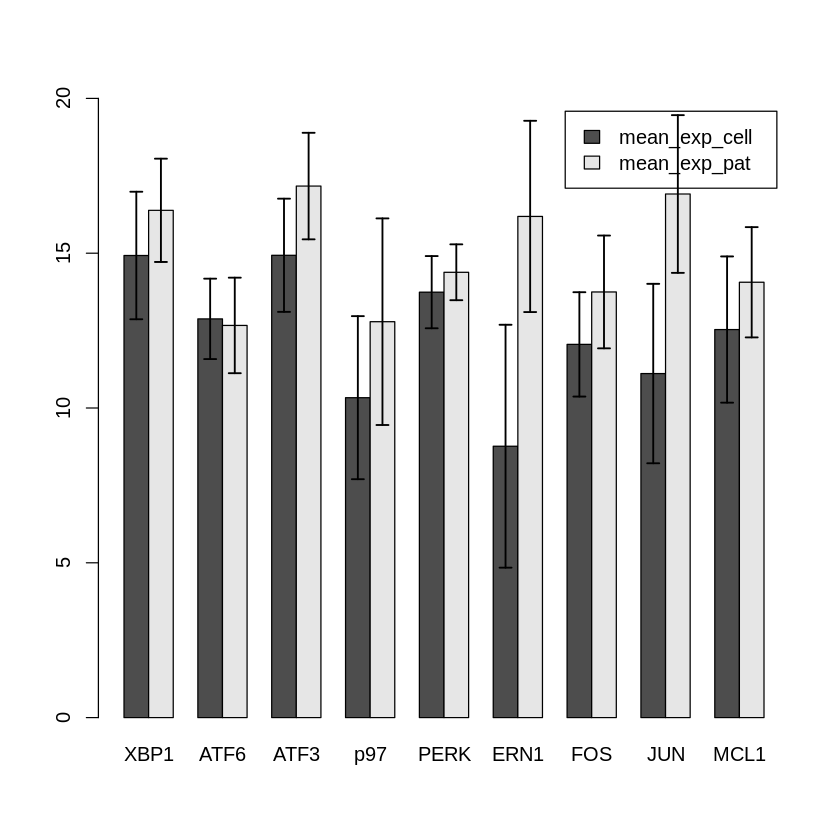

In [6]:
g_chk_exp = c('ENSG00000100219', 'ENSG00000178607', 'ENSG00000118217', 
             'ENSG00000162772', 'ENSG00000172071', 'ENSG00000165280', 'ENSG00000170345', 'ENSG00000177606', 
             'ENSG00000143384')
g_chk_exp_bool = rownames(norm_combined) %in% g_chk_exp
#head(g_chk_exp_bool)
#sum(g_chk_exp_bool)
g_chk_exp_final = norm_combined[g_chk_exp_bool,]
# head(g_chk_exp_final)
g_chk_exp_cell = g_chk_exp_final[,colnames(MM_cell_line)]
# g_chk_exp_cell
g_chk_exp_pat = g_chk_exp_final[,colnames(MM_patients)]
# g_chk_exp_pat
mean_exp_cell = rowMeans(g_chk_exp_cell)
mean_exp_pat = rowMeans(g_chk_exp_pat)
mean_exp_pat

sd_exp_cell = apply(g_chk_exp_cell, 1, sd)
sd_exp_pat = apply(g_chk_exp_pat, 1, sd)
sd_all = rbind(sd_exp_cell, sd_exp_pat)

options(repr.plot.width = 7, repr.plot.height = 7)


#c('XBP1', 'ATF6', 'ATF3', 'VCP', 'EIF2AK3', 'ERN1')
bplot = barplot(rbind(mean_exp_cell, mean_exp_pat),beside = TRUE, legend = TRUE, names.arg = c('XBP1', 'ATF6', 
'ATF3', 'p97', 'PERK', 'ERN1', 'FOS', 'JUN', 'MCL1'), ylim = c(0,20))
arrows(bplot, rbind(mean_exp_cell, mean_exp_pat) - sd_all * 2, bplot,
       rbind(mean_exp_cell, mean_exp_pat) + sd_all * 2, lwd = 1.5, angle = 90,
       code = 3, length = 0.05)# + stat_compare_means()


ENSG00000100219 ENSG00000118217 ENSG00000143384 ENSG00000162772
Cell Lines 14.92599        12.87852        14.93257        10.33338       
Patients   16.38473        12.66667        17.16855        12.78724       
           ENSG00000165280 ENSG00000170345 ENSG00000172071 ENSG00000177606
Cell Lines 13.74094         8.765867       12.05462        11.11228       
Patients   14.38375        16.188250       13.74819        16.91215       
           ENSG00000178607
Cell Lines 12.53387       
Patients   14.06181

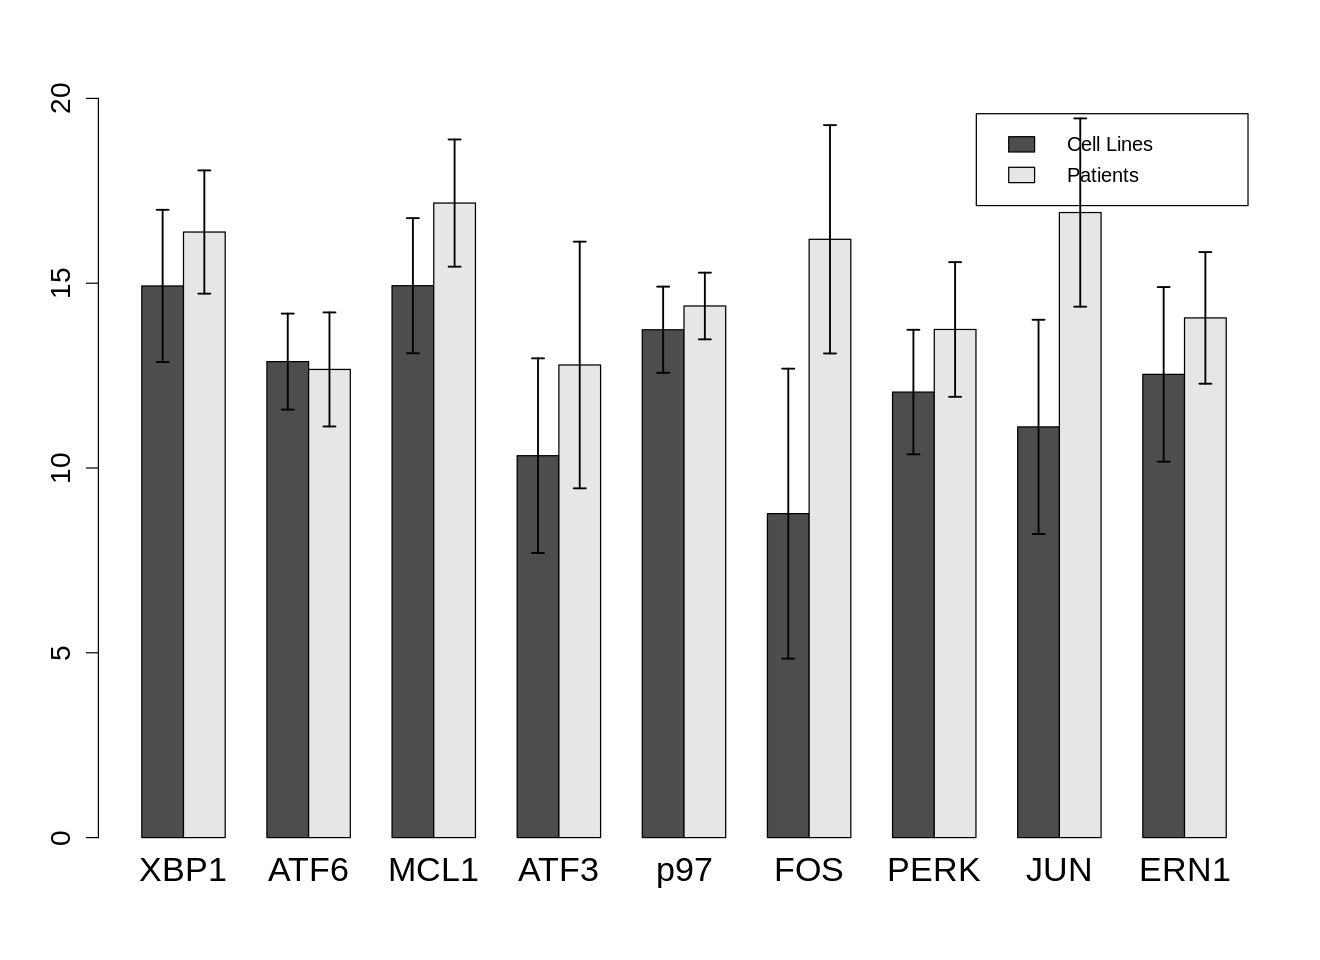

In [7]:
bp = rbind(mean_exp_cell, mean_exp_pat)
rownames(bp) = c('Cell Lines', 'Patients')
bp
#c('XBP1', 'ATF6', 'ATF3', 'VCP', 'EIF2AK3', 'ERN1')
options(repr.plot.width = 11, repr.plot.height = 8)
bplot = barplot(bp,beside = TRUE, legend = TRUE, names.arg = c('XBP1', 'ATF6',
'MCL1', 'ATF3', 'p97', 'FOS', 'PERK', 'JUN', 'ERN1'), ylim = c(0,20), cex.names = 1.7, cex.axis = 1.4)
arrows(bplot, rbind(mean_exp_cell, mean_exp_pat) - sd_all * 2, bplot,
       rbind(mean_exp_cell, mean_exp_pat) + sd_all * 2, lwd = 1.5, angle = 90,
       code = 3, length = 0.05)

In [8]:
wilcox.test(g_chk_exp_pat['ENSG00000143384',], g_chk_exp_cell['ENSG00000143384',])


	Wilcoxon rank sum test with continuity correction

data:  g_chk_exp_pat["ENSG00000143384", ] and g_chk_exp_cell["ENSG00000143384", ]
W = 49300, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


TPM      poc     
MMRF_2801_1_BM 14.50078 Patients
MMRF_2718_1_BM 15.18807 Patients
MMRF_2815_1_BM 15.62729 Patients
MMRF_1656_1_BM 15.15783 Patients
MMRF_2461_1_BM 15.25675 Patients
MMRF_2057_1_BM 17.23732 Patients

TPM      poc       
ALMC1   14.76946 Cell Lines
ALMC2   14.39417 Cell Lines
AMO1    11.60714 Cell Lines
ANBL6   16.32298 Cell Lines
COLO677 13.22725 Cell Lines
Delta47 15.48817 Cell Lines

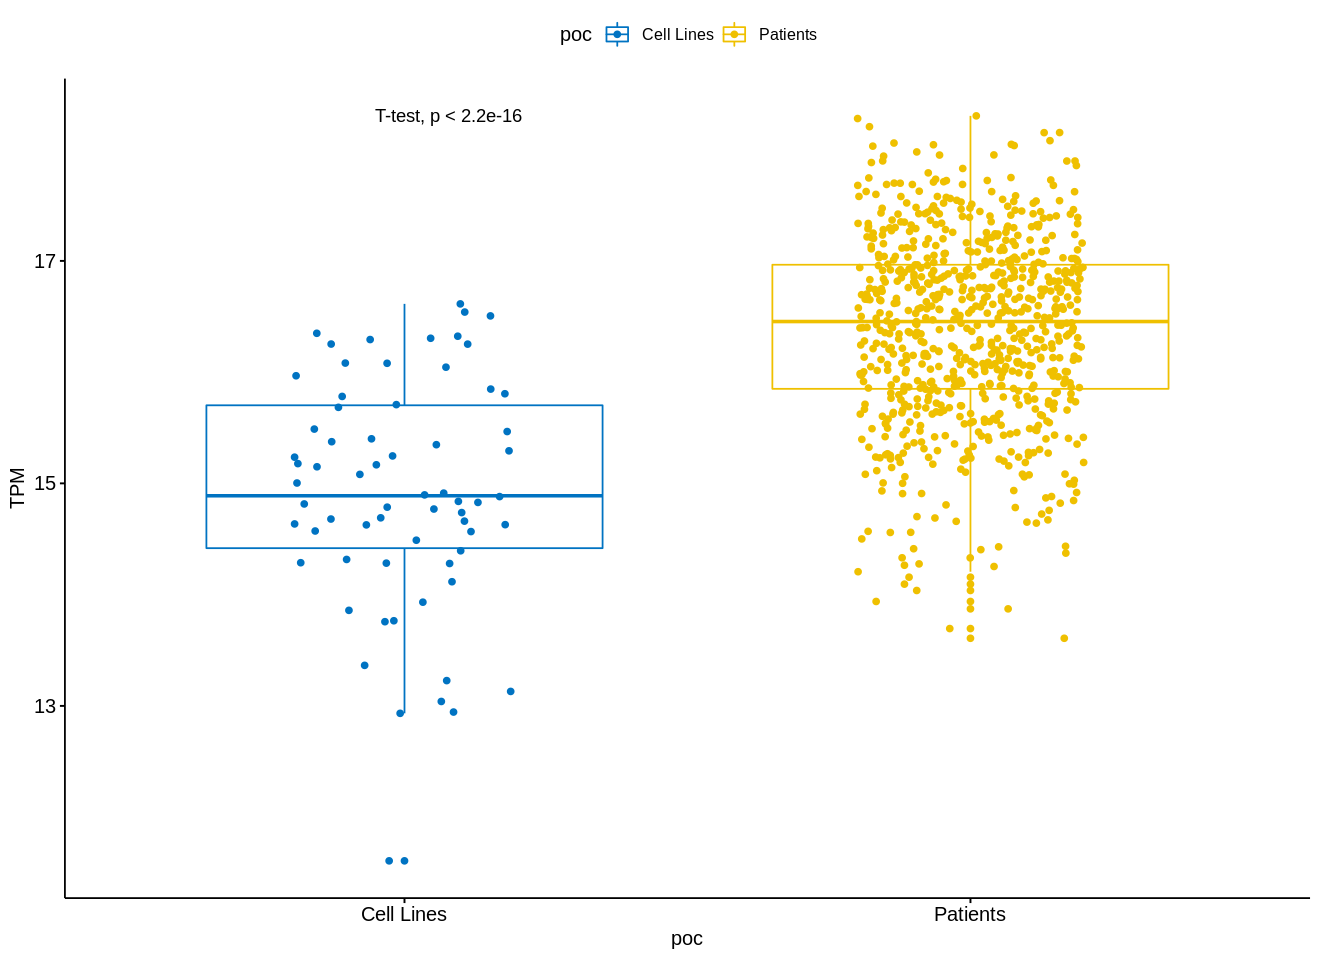

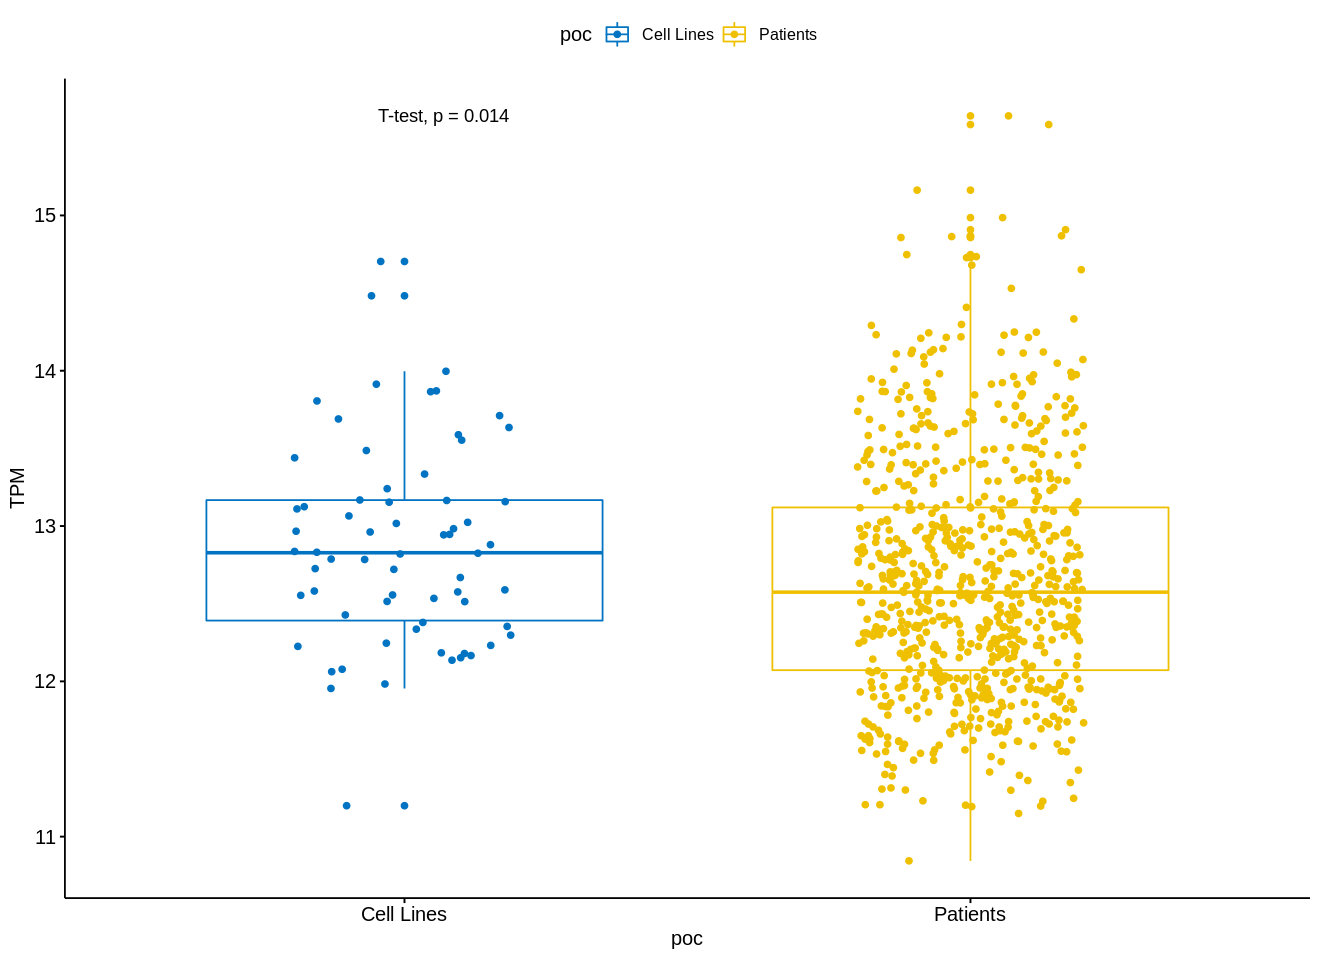

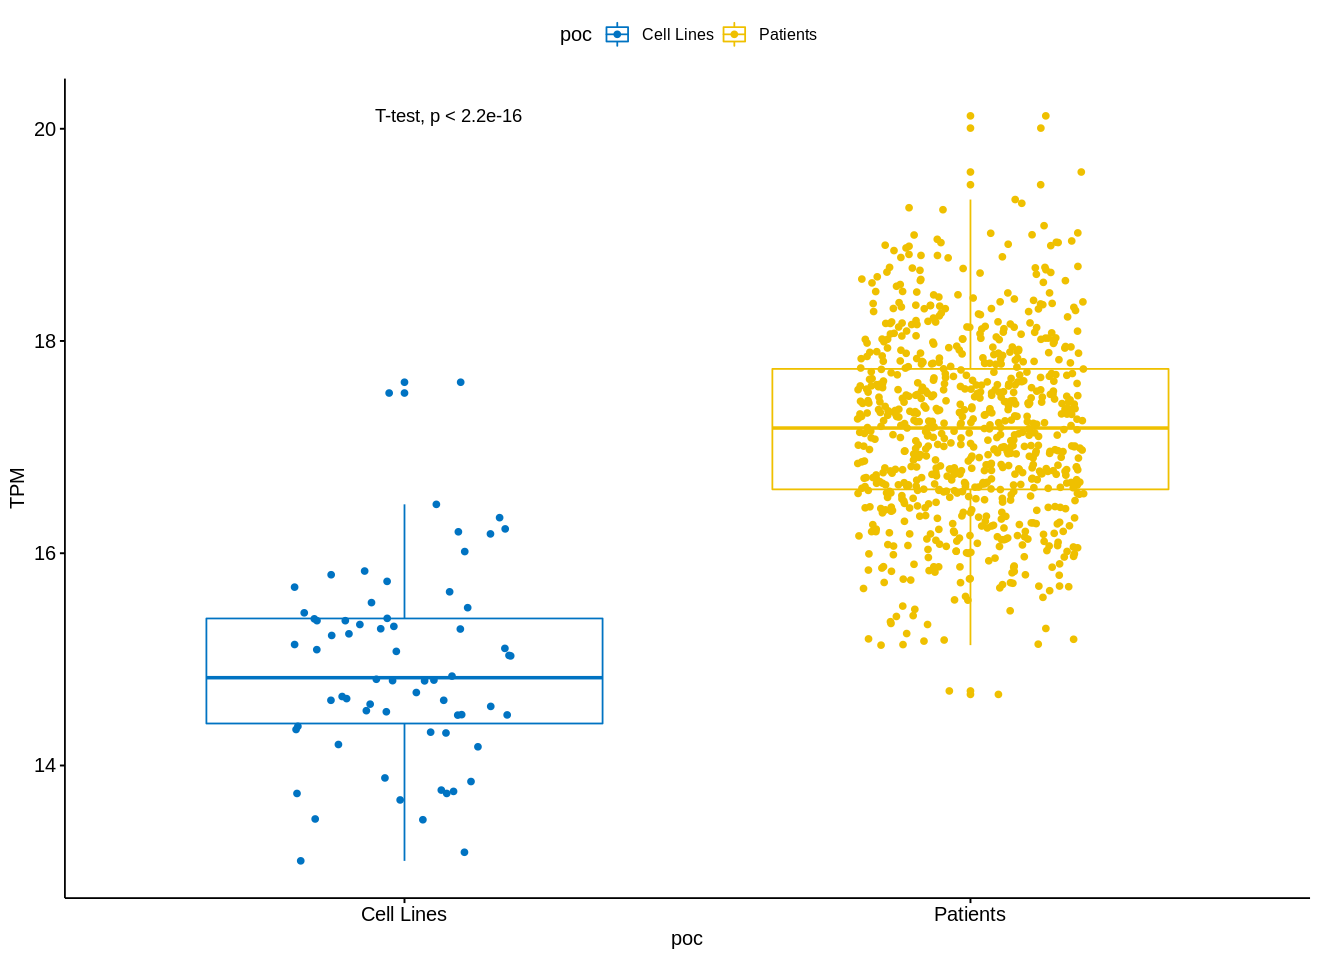

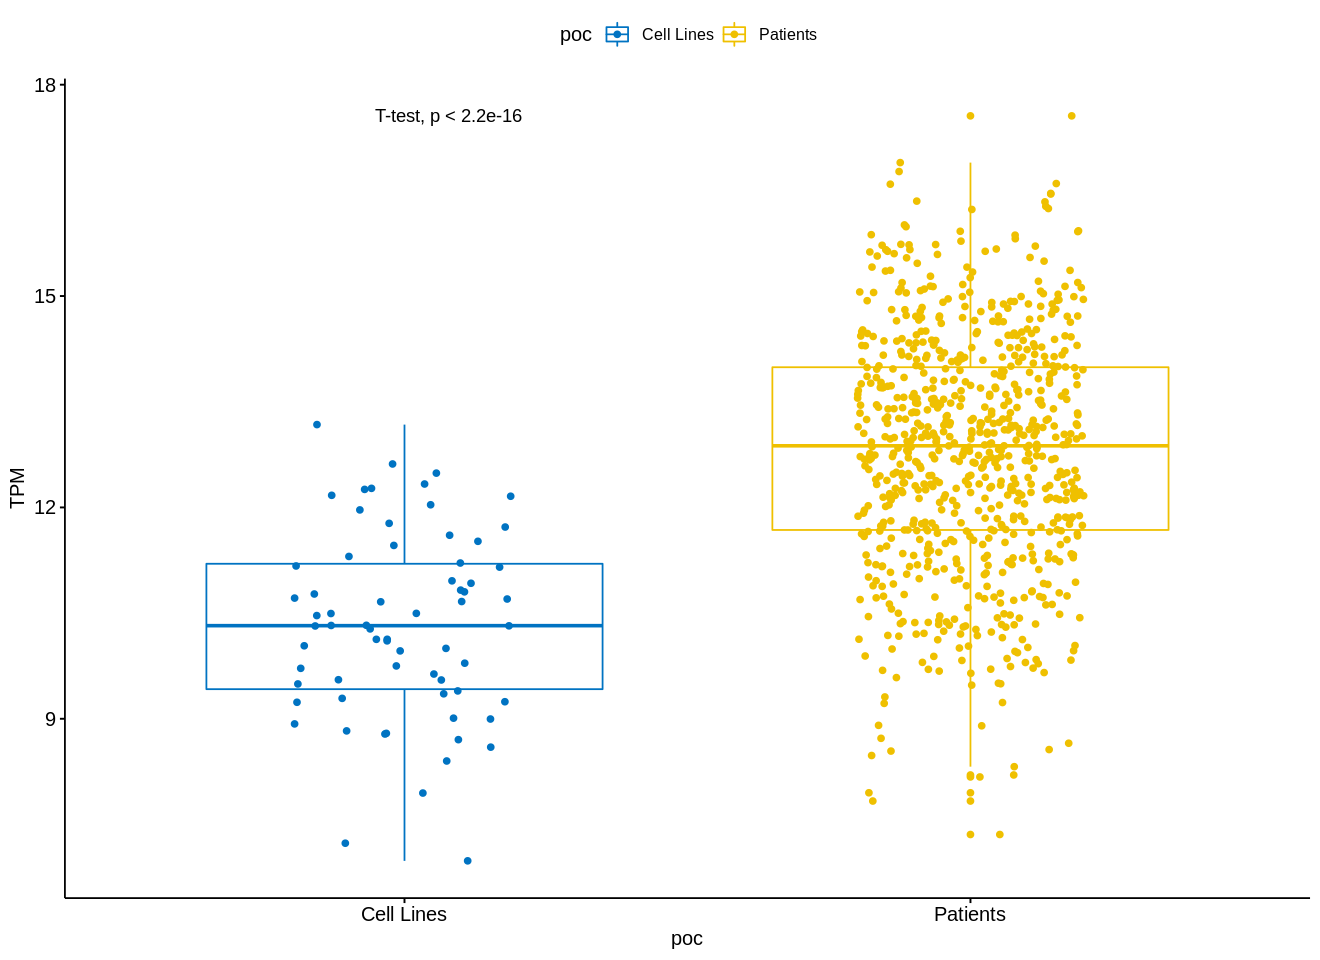

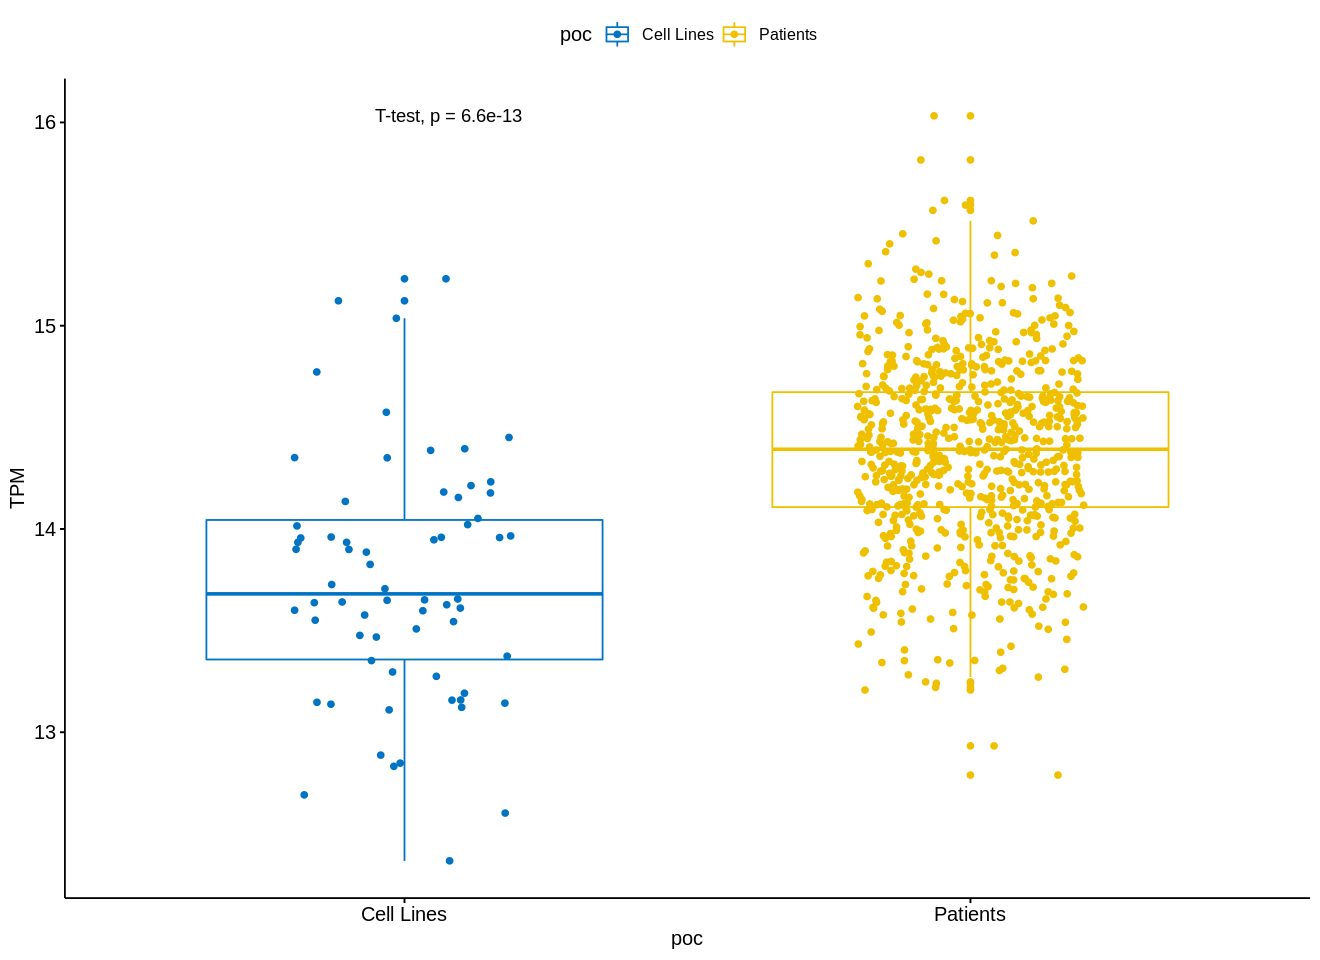

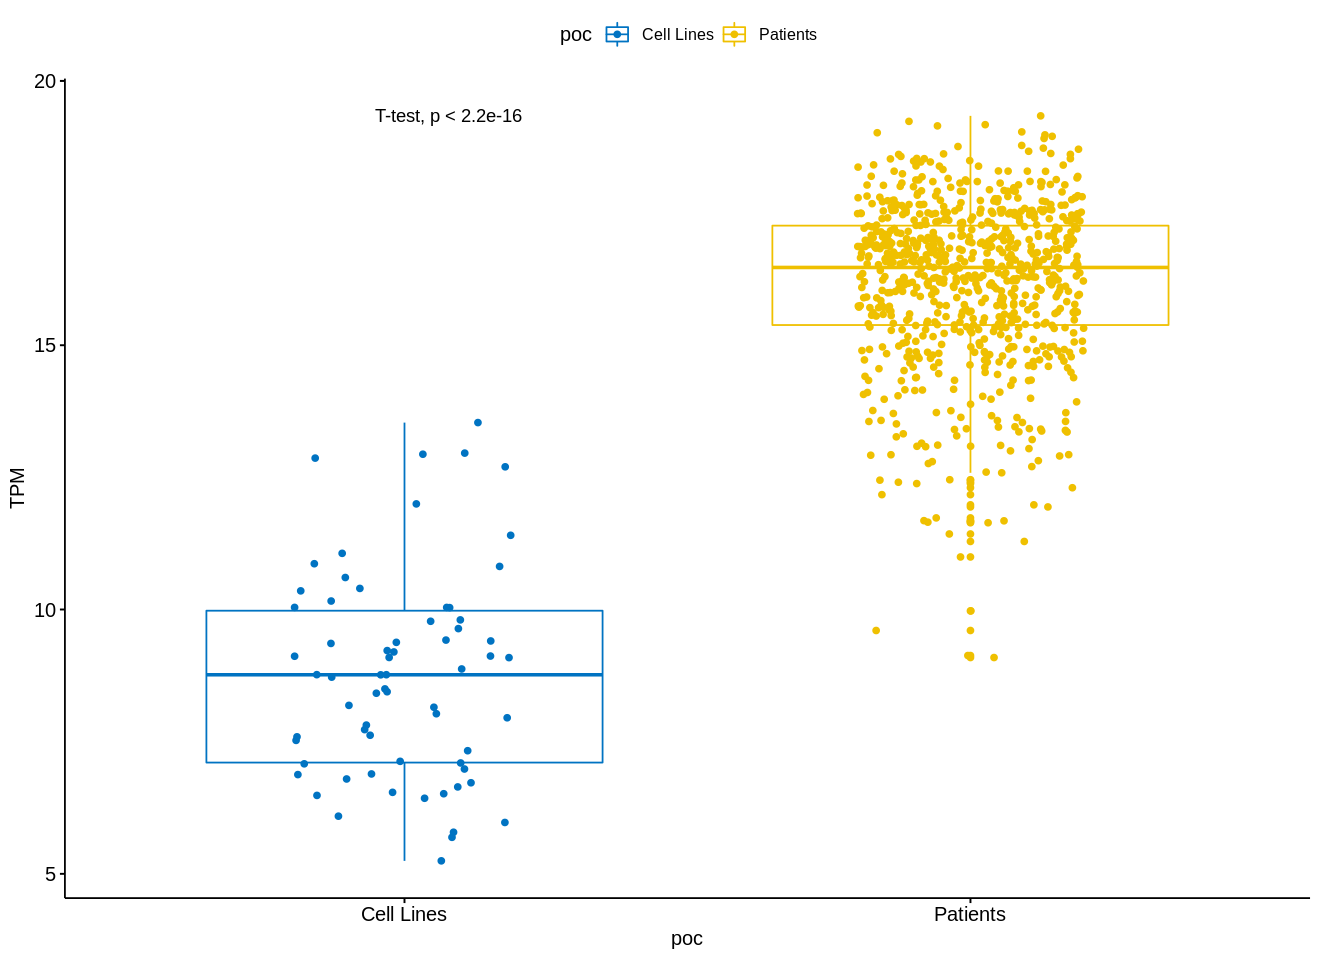

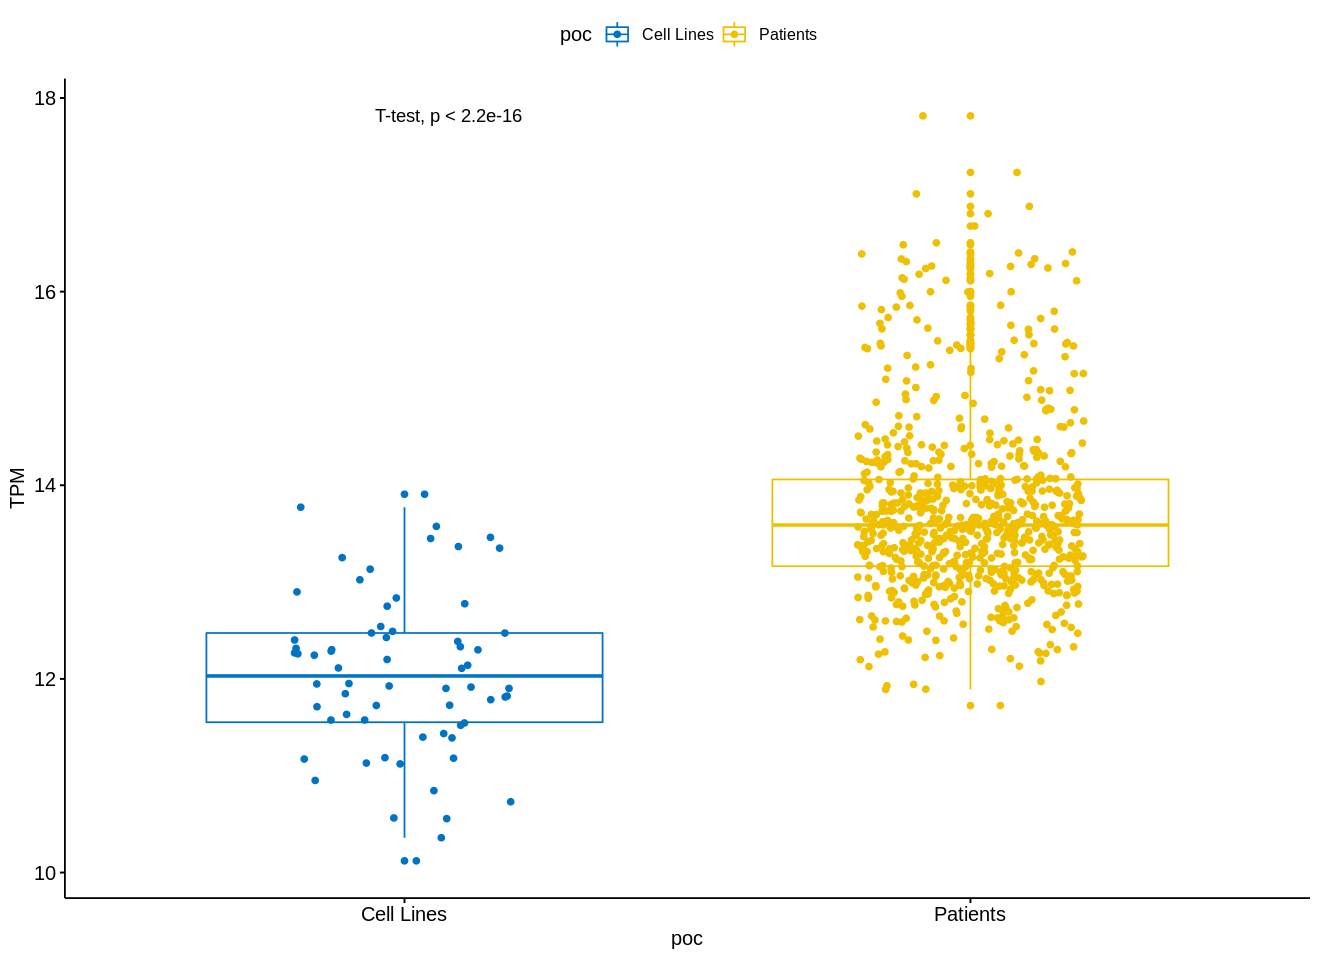

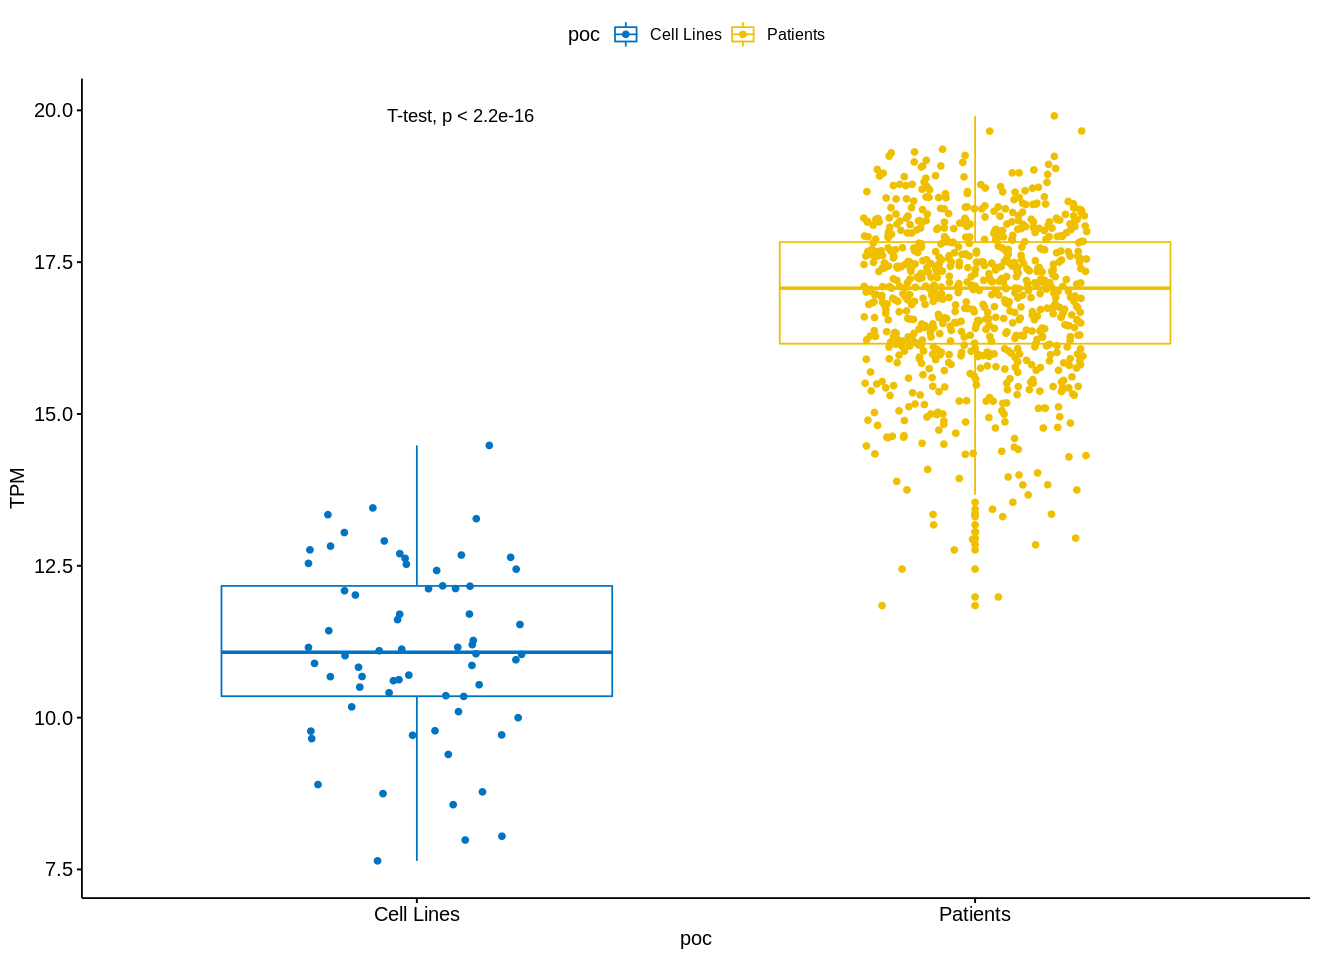

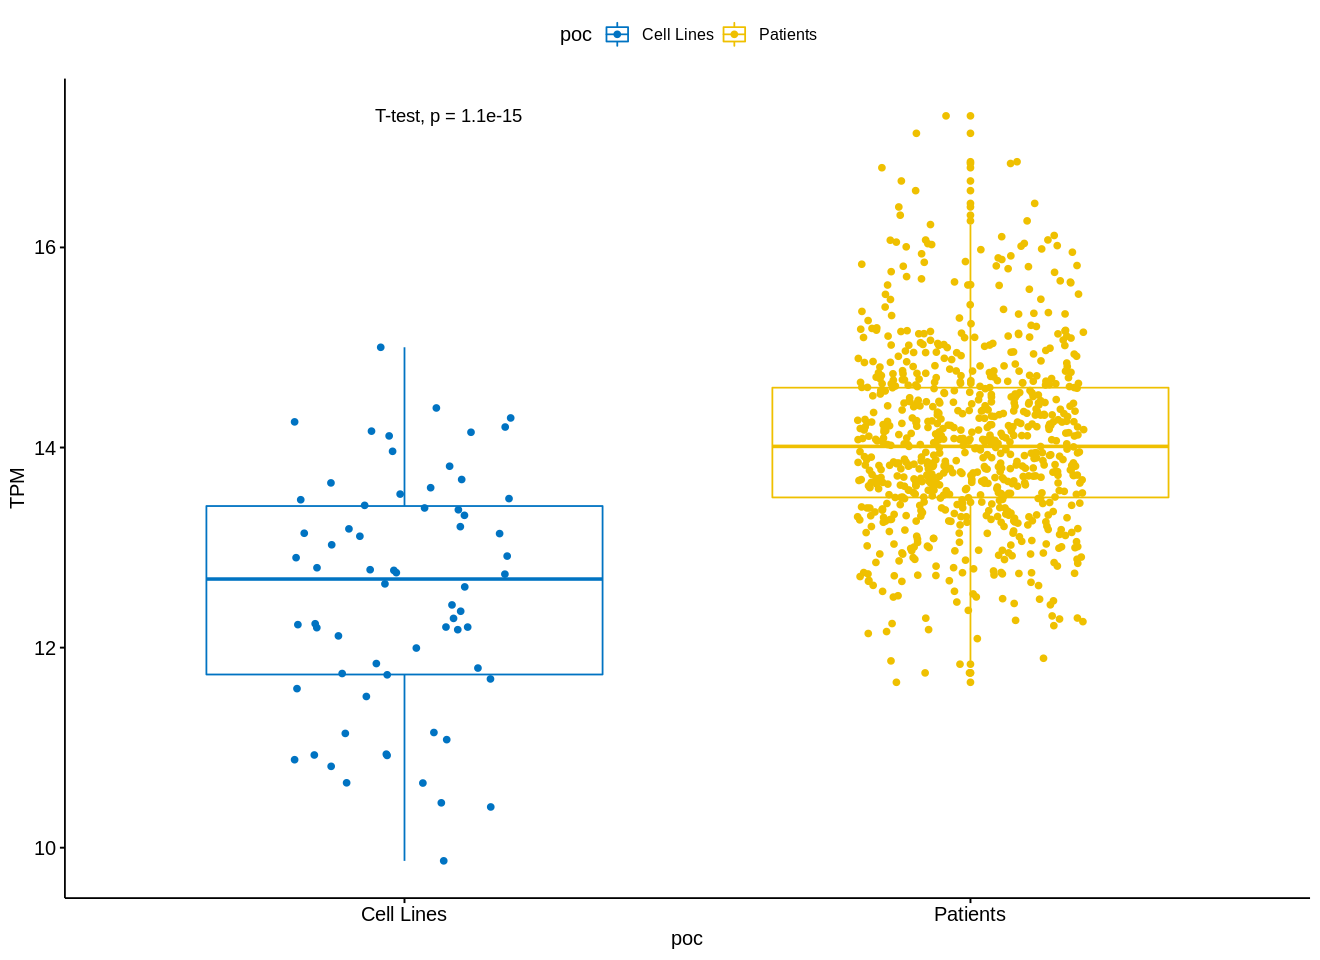

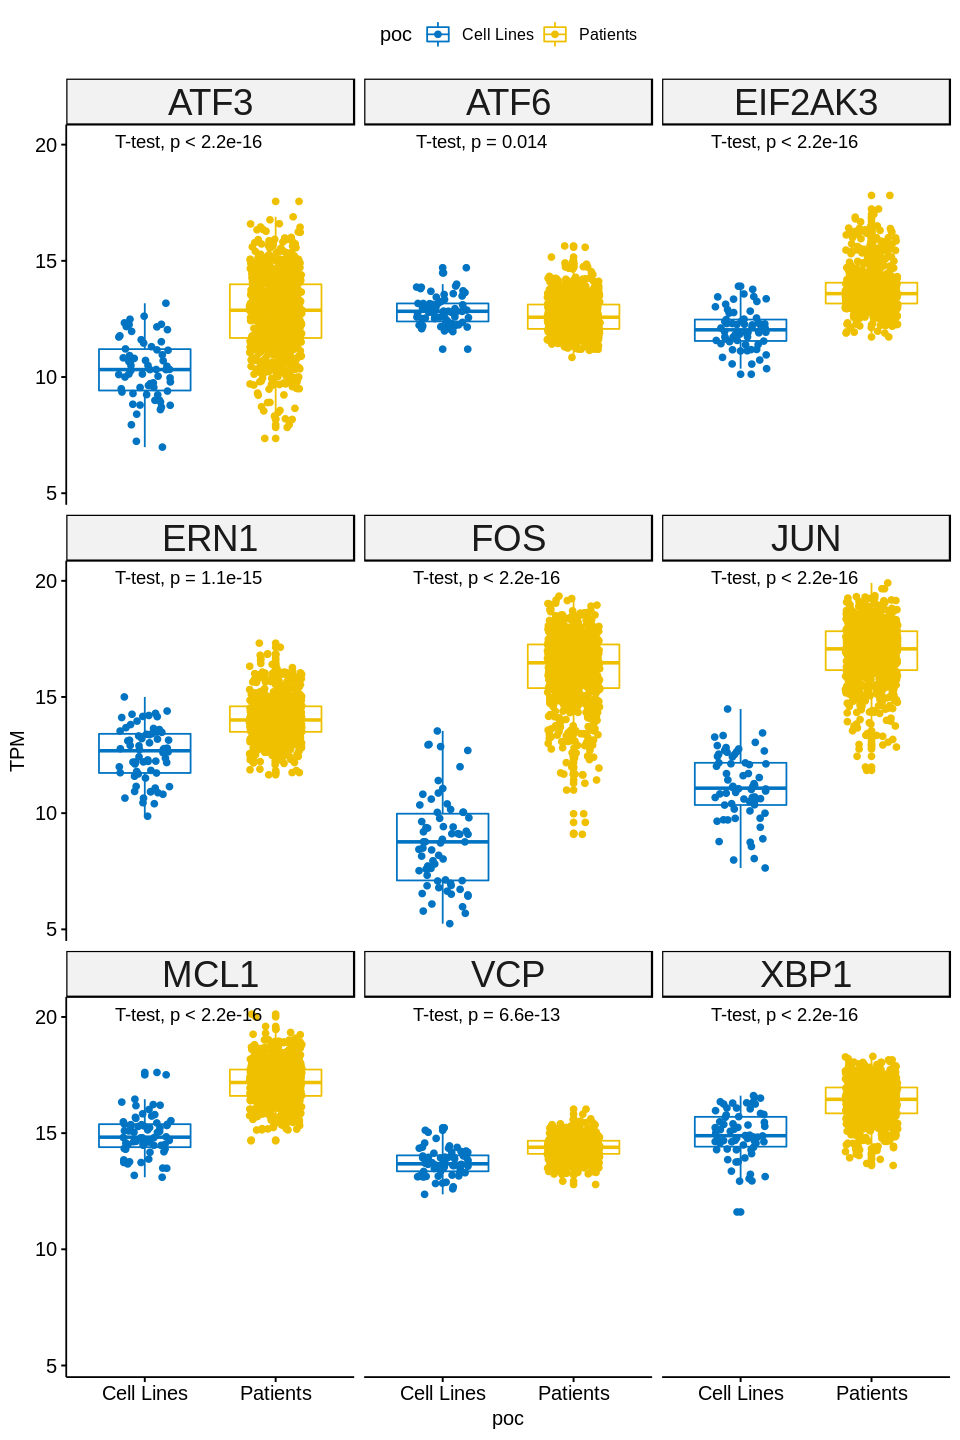

In [9]:
# cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
# cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
# cor_il6_dep = cor_il6_dep[keepc414,]
# cor_il6_ndep = cor_il6_ndep[keepc414,]

# head(cor_il6_dep)
# head(cor_il6_ndep)


# cor_il6_dep = colMeans(cor_il6_dep)
# cor_il6_ndep = colMeans(cor_il6_ndep)

# cor_il6_dep = as.data.frame(cor_il6_dep)
# cor_il6_dep$type = 'IL6 Dependent'
# cor_il6_ndep = as.data.frame(cor_il6_ndep)
# cor_il6_ndep$type = 'IL6 Independent'

# colnames(cor_il6_dep) = c('cor', 'type')
# colnames(cor_il6_ndep) = c('cor', 'type')

# cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


# p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
#           color = "type", palette = "jco",
#           add = "jitter")
# p + stat_compare_means()
xbp1pat = as.data.frame(g_chk_exp_pat['ENSG00000100219',])
xbp1pat$poc = 'Patients'
colnames(xbp1pat) = c('TPM', 'poc')
xbp1cell = as.data.frame(g_chk_exp_cell['ENSG00000100219',])
xbp1cell$poc = 'Cell Lines'
colnames(xbp1cell) = c('TPM', 'poc')
head(xbp1pat)
head(xbp1cell)
xbp1_b = rbind(xbp1cell, xbp1pat)

p <- ggboxplot(xbp1_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')


atf6pat = as.data.frame(g_chk_exp_pat['ENSG00000118217',])
atf6pat$poc = 'Patients'
colnames(atf6pat) = c('TPM', 'poc')
atf6cell = as.data.frame(g_chk_exp_cell['ENSG00000118217',])
atf6cell$poc = 'Cell Lines'
colnames(atf6cell) = c('TPM', 'poc')
atf6_b = rbind(atf6cell, atf6pat)
p <- ggboxplot(atf6_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')

mcl1pat = as.data.frame(g_chk_exp_pat['ENSG00000143384',])
mcl1pat$poc = 'Patients'
colnames(mcl1pat) = c('TPM', 'poc')
mcl1cell = as.data.frame(g_chk_exp_cell['ENSG00000143384',])
mcl1cell$poc = 'Cell Lines'
colnames(mcl1cell) = c('TPM', 'poc')
mcl1_b = rbind(mcl1cell, mcl1pat)
p <- ggboxplot(mcl1_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')

atf3pat = as.data.frame(g_chk_exp_pat['ENSG00000162772',])
atf3pat$poc = 'Patients'
colnames(atf3pat) = c('TPM', 'poc')
atf3cell = as.data.frame(g_chk_exp_cell['ENSG00000162772',])
atf3cell$poc = 'Cell Lines'
colnames(atf3cell) = c('TPM', 'poc')
atf3_b = rbind(atf3cell, atf3pat)
p <- ggboxplot(atf3_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')

vcppat = as.data.frame(g_chk_exp_pat['ENSG00000165280',])
vcppat$poc = 'Patients'
colnames(vcppat) = c('TPM', 'poc')
vcpcell = as.data.frame(g_chk_exp_cell['ENSG00000165280',])
vcpcell$poc = 'Cell Lines'
colnames(vcpcell) = c('TPM', 'poc')
vcp_b = rbind(vcpcell, vcppat)
p <- ggboxplot(vcp_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')

fospat = as.data.frame(g_chk_exp_pat['ENSG00000170345',])
fospat$poc = 'Patients'
colnames(fospat) = c('TPM', 'poc')
foscell = as.data.frame(g_chk_exp_cell['ENSG00000170345',])
foscell$poc = 'Cell Lines'
colnames(foscell) = c('TPM', 'poc')
fos_b = rbind(foscell, fospat)
p <- ggboxplot(fos_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')

eif2ak3pat = as.data.frame(g_chk_exp_pat['ENSG00000172071',])
eif2ak3pat$poc = 'Patients'
colnames(eif2ak3pat) = c('TPM', 'poc')
eif2ak3cell = as.data.frame(g_chk_exp_cell['ENSG00000172071',])
eif2ak3cell$poc = 'Cell Lines'
colnames(eif2ak3cell) = c('TPM', 'poc')
eif2ak3_b = rbind(eif2ak3cell, eif2ak3pat)
p <- ggboxplot(eif2ak3_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')

junpat = as.data.frame(g_chk_exp_pat['ENSG00000177606',])
junpat$poc = 'Patients'
colnames(junpat) = c('TPM', 'poc')
juncell = as.data.frame(g_chk_exp_cell['ENSG00000177606',])
juncell$poc = 'Cell Lines'
colnames(juncell) = c('TPM', 'poc')
jun_b = rbind(juncell, junpat)
p <- ggboxplot(jun_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')

ern1pat = as.data.frame(g_chk_exp_pat['ENSG00000178607',])
ern1pat$poc = 'Patients'
colnames(ern1pat) = c('TPM', 'poc')
ern1cell = as.data.frame(g_chk_exp_cell['ENSG00000178607',])
ern1cell$poc = 'Cell Lines'
colnames(ern1cell) = c('TPM', 'poc')
ern1_b = rbind(ern1cell, ern1pat)
p <- ggboxplot(ern1_b, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter")
p + stat_compare_means(method = 't.test')


xbp1_b$Subtype = 'XBP1'
atf6_b$Subtype = 'ATF6'
mcl1_b$Subtype = 'MCL1'
atf3_b$Subtype = 'ATF3'
vcp_b$Subtype = 'VCP'
fos_b$Subtype = 'FOS'
eif2ak3_b$Subtype = 'EIF2AK3'
jun_b$Subtype = 'JUN'
ern1_b$Subtype = 'ERN1'

gcf = rbind(xbp1_b, atf6_b)
gcf = rbind(gcf, mcl1_b)
gcf = rbind(gcf, atf3_b)
gcf = rbind(gcf, vcp_b)
gcf = rbind(gcf, fos_b)
gcf = rbind(gcf, eif2ak3_b)
gcf = rbind(gcf, jun_b)
gcf = rbind(gcf, ern1_b)

p <- ggboxplot(gcf, x = "poc", y = "TPM",
          color = "poc", palette = "jco",
          add = "jitter") + stat_compare_means(method = 't.test')
options(repr.plot.height = 12, repr.plot.width = 8)
facet(p, facet.by = 'Subtype', 
      panel.labs.font = list(face = NULL,color = NULL, size = 22, angle = NULL))#, scales = 'free_x'))

XBP1     Subtype
MMRF_2801_1_BM 14.50078 Patient
MMRF_2718_1_BM 15.18807 Patient
MMRF_2815_1_BM 15.62729 Patient
MMRF_1656_1_BM 15.15783 Patient
MMRF_2461_1_BM 15.25675 Patient
MMRF_2057_1_BM 17.23732 Patient

XBP1     Subtype   
UTMC2 14.82893 Cell Lines
VP6   15.80578 Cell Lines
XG1   16.29294 Cell Lines
XG2   15.84763 Cell Lines
XG6   15.29272 Cell Lines
XG7   14.88123 Cell Lines

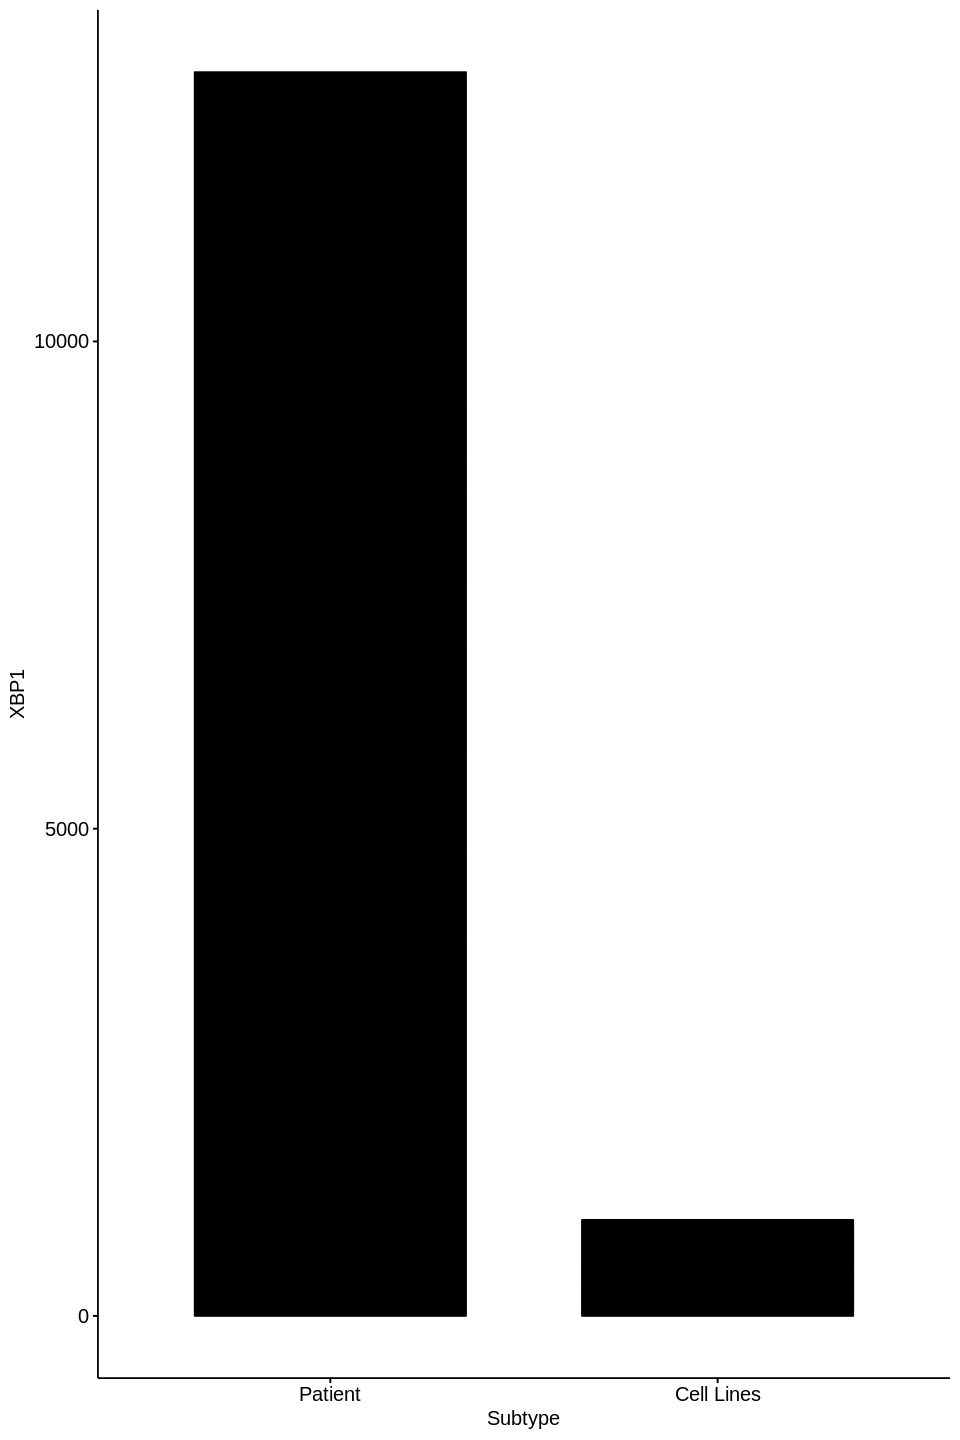

In [10]:
test219pat = as.data.frame(g_chk_exp_pat['ENSG00000100219',])
test219pat$Subtype = 'Patient'
colnames(test219pat) = c('XBP1', 'Subtype')
head(test219pat)
test219cell = as.data.frame(g_chk_exp_cell['ENSG00000100219',])
test219cell$Subtype = 'Cell Lines'
colnames(test219cell) = c('XBP1', 'Subtype')
tail(rbind(test219pat,test219cell))
ggbarplot(rbind(test219pat,test219cell), x = 'Subtype', y = 'XBP1')

In [11]:
head((cbind(mean_exp_cell, mean_exp_pat)))
head(g_chk_exp_cell)
head(t(sd_all))
head(g_chk_exp_pat)
# ggbarplot(t(rbind(mean_exp_cell, mean_exp_pat)))
# ggbarplot(ToothGrowth, x = "dose", y = "len", add = "mean_se",
#           color = "supp", palette = "jco", 
#           position = position_dodge(0.8))

mean_exp_cell mean_exp_pat
ENSG00000100219 14.925995     16.38473    
ENSG00000118217 12.878518     12.66667    
ENSG00000143384 14.932565     17.16855    
ENSG00000162772 10.333376     12.78724    
ENSG00000165280 13.740939     14.38375    
ENSG00000170345  8.765867     16.18825

ALMC1     ALMC2     AMO1     ANBL6     COLO677   Delta47 
ENSG00000100219 14.769457 14.394174 11.60714 16.322978 13.227251 15.48817
ENSG00000118217 12.534177 12.151915 13.15342 12.575816 13.164495 12.58144
ENSG00000143384 14.804208 17.611397 17.50961 14.474404 13.736338 15.38172
ENSG00000162772  9.635216 10.826331 11.77419  9.395542  8.401117 10.77124
ENSG00000165280 13.946763 13.158845 13.11010 13.655596 13.627238 13.63734
ENSG00000170345  8.151320  7.096997  9.09261  6.643801 10.039289 10.86639
                DP6       EJM       FLAM76    FR4       ⋯ RPMI8226 SKMM1    
ENSG00000100219 15.235657 14.283071 15.707980 15.466084 ⋯ 14.57203 13.756742
ENSG00000118217 12.836506 12.245736 13.016752 12.353673 ⋯ 12.72568 11.982824
ENSG00000143384 15.680521 14.506139 15.075076 14.476349 ⋯ 13.49575 13.882436
ENSG00000162772  8.927456  8.793351  9.750274 10.700045 ⋯ 10.31752  8.783988
ENSG00000165280 14.350995 14.574160 15.036525 13.374250 ⋯ 13.55121 13.705973
ENSG00000170345 10.040045  8.766502  9.378987  7.952003 ⋯ 12.86435  8.498234
                SKMM2     U266     UTMC2    VP6       XG1       XG2      
ENSG00000100219 14.286945 15.37463 14.82893 15.805784 16.292935 15.847626
ENSG00000118217 12.553668 12.06209 12.82496 12.588880 12.961582 12.231471
ENSG00000143384 13.101280 15.22511 14.17602 15.103326 14.577851 14.556618
ENSG00000162772  9.716319 12.17197 11.51909  9.242192 10.275743  8.597526
ENSG00000165280 13.955694 13.72669 14.05200 13.143107 13.825675 14.231855
ENSG00000170345 10.353031  8.72029 13.53649  5.971329  7.621426  9.405176
                XG6       XG7     
ENSG00000100219 15.292717 14.88123
ENSG00000118217 13.634534 13.71103
ENSG00000143384 15.037025 16.33514
ENSG00000162772 10.319416 11.15251
ENSG00000165280 14.450174 13.95778
ENSG00000170345  9.089936 10.81533

sd_exp_cell sd_exp_pat
ENSG00000100219 1.0297030   0.8339282 
ENSG00000118217 0.6494052   0.7714711 
ENSG00000143384 0.9141708   0.8602839 
ENSG00000162772 1.3167365   1.6684846 
ENSG00000165280 0.5830971   0.4508877 
ENSG00000170345 1.9612054   1.5444867

MMRF_2801_1_BM MMRF_2718_1_BM MMRF_2815_1_BM MMRF_1656_1_BM
ENSG00000100219 14.50078       15.18807       15.62729       15.15783      
ENSG00000118217 11.55490       11.73305       13.11645       12.28920      
ENSG00000143384 16.86084       16.56122       17.03413       17.59335      
ENSG00000162772 14.49457       12.16583       13.73209       11.23175      
ENSG00000165280 14.14564       14.11700       14.17436       14.82683      
ENSG00000170345 16.84846       15.32162       13.08954       14.92815      
                MMRF_2461_1_BM MMRF_2057_1_BM MMRF_1910_1_BM MMRF_2341_1_BM
ENSG00000100219 15.25675       17.23732       17.38403       16.21119      
ENSG00000118217 11.90794       13.76056       14.12051       11.70651      
ENSG00000143384 18.16565       17.01003       18.55245       16.71260      
ENSG00000162772 15.65833       12.18175       15.03401       10.88839      
ENSG00000165280 14.69317       14.07217       14.43076       13.61416      
ENSG00000170345 16.58442       15.77372       18.72849       15.61620      
                MMRF_2501_1_BM MMRF_1383_1_BM ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ENSG00000100219 16.98516       16.54525       ⋯ 17.68737       14.91813      
ENSG00000118217 12.33549       12.95435       ⋯ 12.65400       12.69998      
ENSG00000143384 15.72227       16.78513       ⋯ 18.02024       16.69280      
ENSG00000162772  9.74194       13.58540       ⋯ 14.69366       13.86547      
ENSG00000165280 14.56317       14.83917       ⋯ 15.03167       14.30362      
ENSG00000170345 13.00162       17.54182       ⋯ 17.28150       13.92871      
                MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ENSG00000100219 17.94177       16.97104       15.53373       15.55508      
ENSG00000118217 13.49286       11.78232       11.54807       11.41632      
ENSG00000143384 17.24939       16.08136       16.64394       17.34048      
ENSG00000162772 11.78868       10.18351       12.01361       13.57820      
ENSG00000165280 14.75180       14.80125       15.36399       14.89139      
ENSG00000170345 16.90281       15.99280       16.99080       14.82359      
                MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000100219 17.41981       16.05091       15.99356       16.99375      
ENSG00000118217 13.81885       12.18983       12.55557       13.39022      
ENSG00000143384 17.33931       16.34737       16.79501       19.01859      
ENSG00000162772 14.62867       10.30084       12.20152       15.91475      
ENSG00000165280 14.23488       14.45372       13.84192       14.73611      
ENSG00000170345 18.61144       16.37063       13.36093       18.19360

In [12]:
# separating out patient and cell line columns from norm_combined 

norm_pat = norm_combined[,colnames(MM_patients)]#pat_bool]
norm_cell = norm_combined[,colnames(MM_cell_line)]

# checking output head

head(norm_pat)
head(norm_cell)

MMRF_2801_1_BM MMRF_2718_1_BM MMRF_2815_1_BM MMRF_1656_1_BM
ENSG00000000003  6.060798       9.545865       7.504912       5.678664     
ENSG00000000419 10.957643      11.180638      11.796341      10.495380     
ENSG00000000457  8.464263       9.266066       8.504619      10.465857     
ENSG00000000460  7.361361       8.102342       6.578214       8.019636     
ENSG00000000938  8.864747       6.942817       7.872284       8.063233     
ENSG00000000971  8.976686       9.666459       9.285435       7.717287     
                MMRF_2461_1_BM MMRF_2057_1_BM MMRF_1910_1_BM MMRF_2341_1_BM
ENSG00000000003  9.831334       5.882917       5.839145       6.162487     
ENSG00000000419 11.022594      11.404325      10.675590      10.560857     
ENSG00000000457  8.991437       9.954385       9.798282       9.614478     
ENSG00000000460  7.149116       8.146953       8.315703       8.425506     
ENSG00000000938 11.141904       5.882917       8.540640       8.609911     
ENSG00000000971  8.495919       6.037327       8.073008       6.039664     
                MMRF_2501_1_BM MMRF_1383_1_BM ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ENSG00000000003  9.012450      10.080853      ⋯  5.131689       6.907446     
ENSG00000000419 10.541196      10.548945      ⋯ 11.124923      11.843401     
ENSG00000000457  9.901645       9.854608      ⋯  9.384906       8.525344     
ENSG00000000460  7.797638       7.725440      ⋯  7.505744       6.925478     
ENSG00000000938  6.225164       6.277881      ⋯ 11.916476       6.851781     
ENSG00000000971  6.582150       6.067497      ⋯ 11.664665       6.426298     
                MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ENSG00000000003  5.196712       7.948939      7.400009        8.320791     
ENSG00000000419 11.180281      10.426509      8.784326       11.123679     
ENSG00000000457  9.514931       9.744664      8.746203        7.907656     
ENSG00000000460  8.229035       7.322156      7.515750        6.363182     
ENSG00000000938  6.496629       5.841891      8.650335        7.430139     
ENSG00000000971  5.750688       5.442846      6.297891        6.805684     
                MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003  6.082664       5.345835       5.900425       5.872658     
ENSG00000000419 11.761265      10.632905      10.805345      10.830429     
ENSG00000000457  9.229529       9.503027       9.627453      10.065296     
ENSG00000000460  7.140238       7.818035       7.873429       7.606155     
ENSG00000000938  7.276126       5.803804       7.723670       6.729497     
ENSG00000000971  6.116758      11.042982       6.640096       6.157982

ALMC1     ALMC2     AMO1      ANBL6     COLO677   Delta47  
ENSG00000000003  5.121115  4.830701  6.753159  5.087762  4.830701  4.830701
ENSG00000000419 11.192958 11.058860 11.481792 11.894072 10.306507 10.979705
ENSG00000000457  9.936576  9.672406 10.518177  9.901600  9.772317  9.566903
ENSG00000000460 10.840491  9.650001 10.386322 10.898915 10.791701  9.882322
ENSG00000000938  4.830701  5.715836  8.861104  5.236351  5.110011  5.299783
ENSG00000000971  5.506729  7.282633  5.824017  5.653577  5.658535  5.491225
                DP6       EJM       FLAM76    FR4       ⋯ RPMI8226  SKMM1    
ENSG00000000003  5.122115  6.930293  5.303622  4.830701 ⋯  5.183315  4.830701
ENSG00000000419 11.075250 11.003090 10.138017 11.723434 ⋯ 11.203237 10.090880
ENSG00000000457  9.781765  9.028327  9.709607 10.338227 ⋯  9.284631  9.782236
ENSG00000000460 11.077974 10.424602 10.251060 10.602664 ⋯ 10.359418 10.360492
ENSG00000000938  6.654161  5.316598  5.165852 11.191736 ⋯  4.830701  7.279769
ENSG00000000971  8.827028  5.664625  6.050852  5.213020 ⋯  7.226316  5.705353
                SKMM2     U266      UTMC2     VP6       XG1       XG2      
ENSG00000000003  4.830701  4.830701  4.830701  4.830701  4.830701  4.830701
ENSG00000000419 11.337907 10.916534 10.580120 11.126976 11.934854 11.032084
ENSG00000000457  8.783722 10.035066  9.673136  9.484374  9.654509  8.863879
ENSG00000000460 10.104075 10.378362 10.589037  9.883744 10.433379 10.133464
ENSG00000000938  9.363245  6.271504  9.895878 10.190136  9.735164  5.239458
ENSG00000000971  6.555933  5.130448  7.075538  5.971329  6.803862  8.441138
                XG6       XG7      
ENSG00000000003  5.118442  6.661173
ENSG00000000419 12.378849 12.643881
ENSG00000000457  9.861965  9.674925
ENSG00000000460  8.981951  8.534477
ENSG00000000938 11.103832  8.793222
ENSG00000000971  7.936526  7.174217

In [13]:
g2k = rownames(MM_combined.filtered)
CCLE_cell_line = data.frame(fread("CCLE_RNAseq_genes_counts_20180929.gct"))
gid = CCLE_cell_line$Name
gid2 = substr(gid, 1, 15)
rownames(CCLE_cell_line) = gid2

CCLE_cell_line = CCLE_cell_line[-1]
CCLE_cell_line = CCLE_cell_line[-1]

CCLE_cell_line_meta = data.frame(fread("Cell_lines_annotations_20181226.txt"))
CCLE_cell_line_meta_2 = CCLE_cell_line_meta[(CCLE_cell_line_meta$type == 'multiple_myeloma'),]

CCLE_bool2 = colnames(CCLE_cell_line) %in% CCLE_cell_line_meta_2$CCLE_ID
CCLE_cell_line = CCLE_cell_line[,CCLE_bool2]
CCLE_cell_line = CCLE_cell_line[g2k,]
length(CCLE_cell_line[,1])
head(CCLE_cell_line)

[1] 22459

AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003    56                                  
ENSG00000000419 10884                                  
ENSG00000000457  2572                                  
ENSG00000000460  3844                                  
ENSG00000000938  3761                                  
ENSG00000000971    51                                  
                EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003  642                                  
ENSG00000000419 7383                                  
ENSG00000000457 1482                                  
ENSG00000000460 2741                                  
ENSG00000000938    4                                  
ENSG00000000971   54                                  
                HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003   15                                    
ENSG00000000419 7458                                    
ENSG00000000457 2286                                    
ENSG00000000460 5379                                    
ENSG00000000938   17                                    
ENSG00000000971   18                                    
                JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003   17                                   
ENSG00000000419 5989                                   
ENSG00000000457 2691                                   
ENSG00000000460 3464                                   
ENSG00000000938   18                                   
ENSG00000000971 1617                                   
                KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003  204                                        
ENSG00000000419 5646                                        
ENSG00000000457 1948                                        
ENSG00000000460 2487                                        
ENSG00000000938 4547                                        
ENSG00000000971   36                                        
                KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003    13                                  
ENSG00000000419  9925                                  
ENSG00000000457  1876                                  
ENSG00000000460  2782                                  
ENSG00000000938 13572                                  
ENSG00000000971    62                                  
                KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003     4                                   
ENSG00000000419  4271                                   
ENSG00000000457  2182                                   
ENSG00000000460  2757                                   
ENSG00000000938 11348                                   
ENSG00000000971    11                                   
                KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003    7                                   
ENSG00000000419 5864                                   
ENSG00000000457 2068                                   
ENSG00000000460 2402                                   
ENSG00000000938   42                                   
ENSG00000000971  155                                   
                KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003   14                                    
ENSG00000000419 5662                                    
ENSG00000000457 2849                                    
ENSG00000000460 5753                                    
ENSG00000000938    2                                    
ENSG00000000971   27                                    
                KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE ⋯
ENSG00000000003   24                                       ⋯
ENSG00000000419 7070                                       ⋯
ENSG00000000457 2044                                       ⋯
ENSG00000000460 4794                                       ⋯
ENSG00000000938    9                                       ⋯
ENSG00000000971   12                                       ⋯
            

In [14]:
CCLE_cell_names = c('AMO1', 'EJM', 'HUNS1',
                   'JJN3', 'Karpas620', 'KE97',
                   'KHM1B', 'KMM1', 'KMS11_Sus', 'KMS12BM',
                   'KMS18', 'KMS20', 'KMS21BM', 'KMS26', 'KMS27',
                   'KMS28BM', 'KMS34', 'L363', 'LP1', 'MM1S',
                   'MOLP2', 'MOLP8', 'NCIH929', 'OPM2',
                   'RPMI8226', 'SKMM2', 'U266')
colnames(CCLE_cell_line) = CCLE_cell_names

MM_combined_ccle.filtered = cbind(CCLE_cell_line, MM_patients)

In [15]:
# utilizing IQR to get vector of top 5000 and top 10000 genes

keepi = apply(norm_pat, 1, IQR)
keepis = sort(keepi, decreasing = TRUE)
keepi5000 = keepi %in% keepis[1:5000]
keepi10000 = keepi %in% keepis[1:10000]

In [16]:
# making function for doing correlation analysis and generating violin plots

makeplots = function(corset, pnames, clnames, titl) {
    
    MM.cor.v = cor(corset, method = "s")

    #clnames = colnames(MM_cell_line)
    tumor_cell_all = data.frame()

    for(patients in pnames){
        cell_line_tumor_cor = MM.cor.v[patients, clnames]
        cell_line_tumor_cor = data.frame(patient = patients, 
                                         sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
        tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
    }

    cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
    cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
    tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

      p <- ggplot(tumor_cell_all, aes(sample, cor))
      print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + ylab('R') +
              xlab("") + labs(title = titl) +
              stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", 
                           fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  
            theme(panel.background = element_rect(color = 'white'), 
                  axis.text.x = element_text(angle = 70, hjust = 1, size=8))# + stat_compare_means()
      )
   # return(cell_line_order)
}

In [17]:
MM_combined_ccle.filtered[is.na(MM_combined_ccle.filtered)] <- 0

norm_CCLE_combined = vst(as.matrix(MM_combined_ccle.filtered))
norm_CCLE_combined_5000 = norm_CCLE_combined[keepi5000, ]
norm_CCLE_combined_10000 = norm_CCLE_combined[keepi10000, ]

converting counts to integer mode


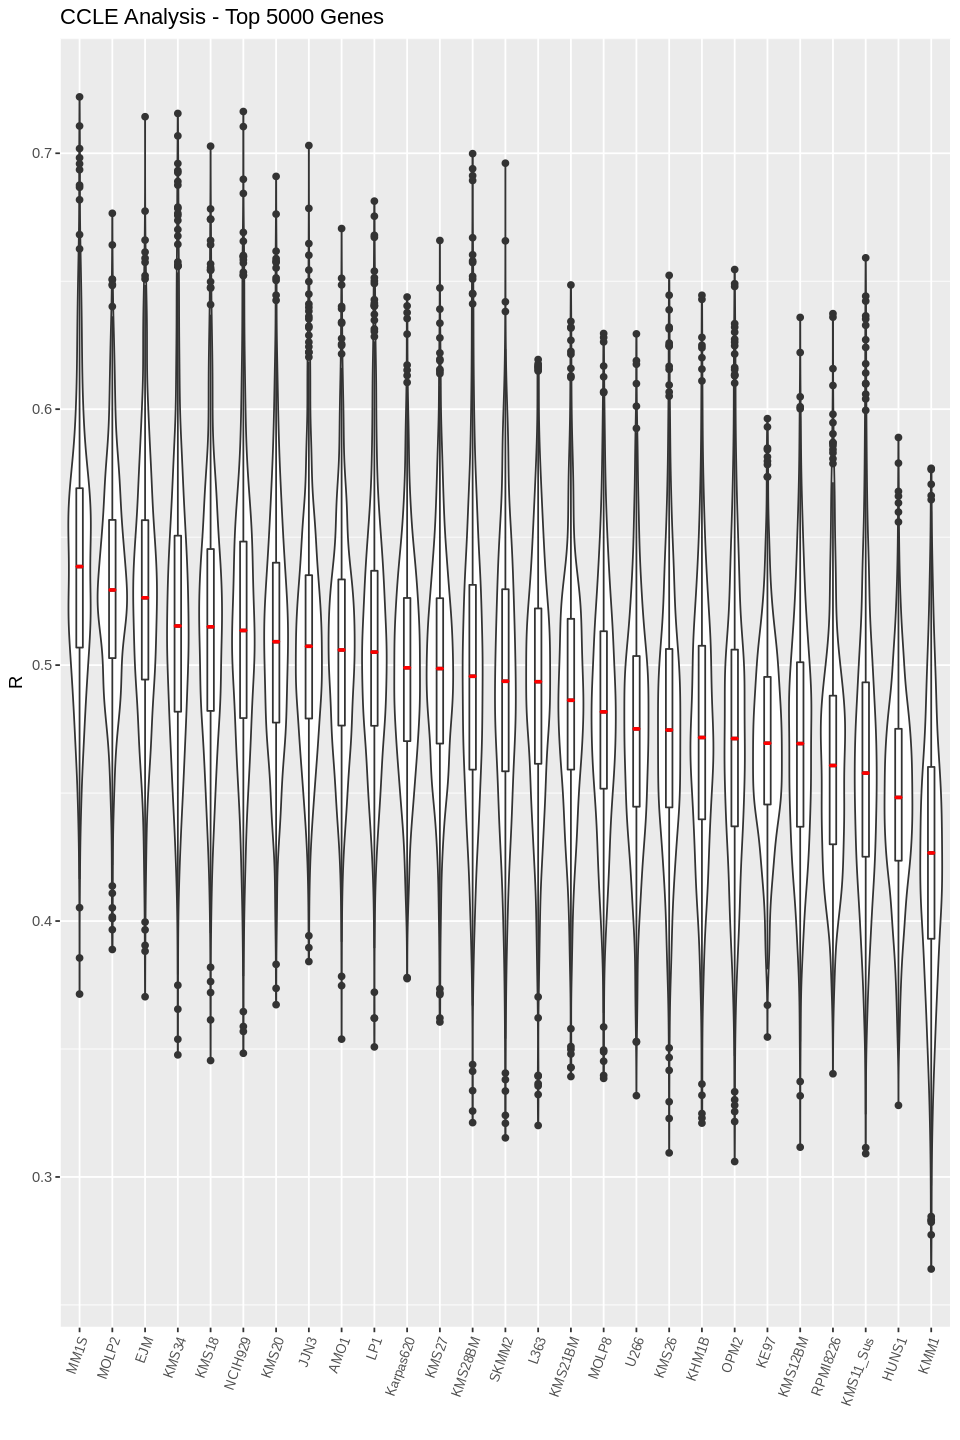

In [18]:
MM.cor.ccle_5000 = cor(norm_CCLE_combined_5000, method = "s")
MM.cor.ccle_10000 = cor(norm_CCLE_combined_10000, method = "s")
makeplots(norm_CCLE_combined_5000, colnames(MM_patients), colnames(CCLE_cell_line), 'CCLE Analysis - Top 5000 Genes')

In [19]:
options(repr.plot.height = 7)
# options
# makeplots(norm_combined_5000, colnames(MM_patients), colnames(MM_cell_line), '')

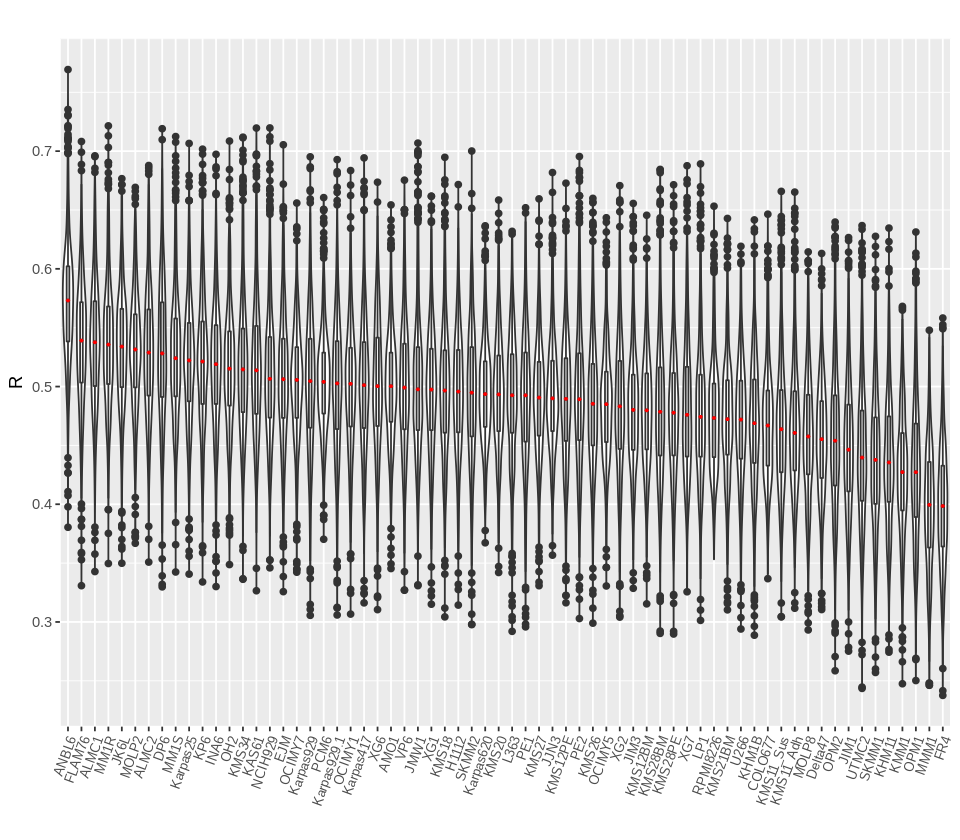

In [20]:
# subsetting top 5000 / 10000 genes

norm_combined_5000 = norm_combined[keepi5000, ]
norm_combined_10000 = norm_combined[keepi10000, ]

# plots for main analysis using top 5000 / 10000 genes
MM.cor.keats_5000 = cor(norm_combined_5000, method = "s")
MM.cor.keats_10000 = cor(norm_combined_10000, method = "s")
makeplots(norm_combined_5000, colnames(MM_patients), colnames(MM_cell_line), '')

In [21]:
head(MM.cor.keats_5000)
head(MM.cor.keats_5000[,-4])
head(rowMeans(MM.cor.keats_5000))


ALMC1     ALMC2     AMO1      ANBL6     COLO677   Delta47   DP6      
ALMC1   1.0000000 0.8805543 0.6609546 0.8378547 0.7245722 0.6196183 0.7282441
ALMC2   0.8805543 1.0000000 0.6965940 0.8212237 0.7300516 0.6733004 0.7572519
AMO1    0.6609546 0.6965940 1.0000000 0.7046144 0.7022450 0.6754221 0.7172928
ANBL6   0.8378547 0.8212237 0.7046144 1.0000000 0.7454699 0.6287094 0.7471954
COLO677 0.7245722 0.7300516 0.7022450 0.7454699 1.0000000 0.6366578 0.6643708
Delta47 0.6196183 0.6733004 0.6754221 0.6287094 0.6366578 1.0000000 0.6824999
        EJM       FLAM76    FR4       ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ALMC1   0.7788833 0.7237444 0.6392978 ⋯ 0.4933652      0.5608761     
ALMC2   0.7803343 0.7241273 0.6482803 ⋯ 0.5030934      0.5449484     
AMO1    0.6837732 0.6494910 0.7097921 ⋯ 0.4617705      0.4862120     
ANBL6   0.7971106 0.7274122 0.6223820 ⋯ 0.5302751      0.5576177     
COLO677 0.6968655 0.6713107 0.6762673 ⋯ 0.4302207      0.4595897     
Delta47 0.6473087 0.6169356 0.6983876 ⋯ 0.4118112      0.4574231     
        MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ALMC1   0.5295802      0.5410907      0.5011998      0.4615494     
ALMC2   0.5057200      0.5184882      0.4956884      0.4409726     
AMO1    0.5037828      0.5159635      0.4900506      0.4383311     
ANBL6   0.5747904      0.5828614      0.5452453      0.4989375     
COLO677 0.4626344      0.4758554      0.4696209      0.3884765     
Delta47 0.4699077      0.4776275      0.4221748      0.4077812     
        MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ALMC1   0.4826397      0.5674340      0.5677463      0.4909093     
ALMC2   0.5019886      0.5493966      0.5574249      0.4650666     
AMO1    0.4448761      0.5099458      0.5302259      0.4479705     
ANBL6   0.5341686      0.5867033      0.5985728      0.5124632     
COLO677 0.4160818      0.4894215      0.4917832      0.4297638     
Delta47 0.4445880      0.4707260      0.5020782      0.4271368

ALMC1     ALMC2     AMO1      COLO677   Delta47   DP6       EJM      
ALMC1   1.0000000 0.8805543 0.6609546 0.7245722 0.6196183 0.7282441 0.7788833
ALMC2   0.8805543 1.0000000 0.6965940 0.7300516 0.6733004 0.7572519 0.7803343
AMO1    0.6609546 0.6965940 1.0000000 0.7022450 0.6754221 0.7172928 0.6837732
ANBL6   0.8378547 0.8212237 0.7046144 0.7454699 0.6287094 0.7471954 0.7971106
COLO677 0.7245722 0.7300516 0.7022450 1.0000000 0.6366578 0.6643708 0.6968655
Delta47 0.6196183 0.6733004 0.6754221 0.6366578 1.0000000 0.6824999 0.6473087
        FLAM76    FR4       H1112     ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ALMC1   0.7237444 0.6392978 0.7297035 ⋯ 0.4933652      0.5608761     
ALMC2   0.7241273 0.6482803 0.7520602 ⋯ 0.5030934      0.5449484     
AMO1    0.6494910 0.7097921 0.7229638 ⋯ 0.4617705      0.4862120     
ANBL6   0.7274122 0.6223820 0.7343609 ⋯ 0.5302751      0.5576177     
COLO677 0.6713107 0.6762673 0.6962504 ⋯ 0.4302207      0.4595897     
Delta47 0.6169356 0.6983876 0.6821241 ⋯ 0.4118112      0.4574231     
        MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ALMC1   0.5295802      0.5410907      0.5011998      0.4615494     
ALMC2   0.5057200      0.5184882      0.4956884      0.4409726     
AMO1    0.5037828      0.5159635      0.4900506      0.4383311     
ANBL6   0.5747904      0.5828614      0.5452453      0.4989375     
COLO677 0.4626344      0.4758554      0.4696209      0.3884765     
Delta47 0.4699077      0.4776275      0.4221748      0.4077812     
        MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ALMC1   0.4826397      0.5674340      0.5677463      0.4909093     
ALMC2   0.5019886      0.5493966      0.5574249      0.4650666     
AMO1    0.4448761      0.5099458      0.5302259      0.4479705     
ANBL6   0.5341686      0.5867033      0.5985728      0.5124632     
COLO677 0.4160818      0.4894215      0.4917832      0.4297638     
Delta47 0.4445880      0.4707260      0.5020782      0.4271368

ALMC1     ALMC2      AMO1     ANBL6   COLO677   Delta47 
0.5505737 0.5458768 0.5166567 0.5832425 0.4860008 0.4715627

In [22]:
MM.cor.ccle_5000 = MM.cor.ccle_5000[colnames(MM_patients),colnames(CCLE_cell_line)]
MM.cor.ccle_10000 = MM.cor.ccle_10000[colnames(MM_patients),colnames(CCLE_cell_line)]
MM.cor.keats_5000 = MM.cor.keats_5000[colnames(MM_patients),colnames(MM_cell_line)]
MM.cor.keats_10000 = MM.cor.keats_10000[colnames(MM_patients),colnames(MM_cell_line)]

head(MM.cor.keats_5000)
head(MM.cor.ccle_5000)

ALMC1     ALMC2     AMO1      ANBL6     COLO677   Delta47  
MMRF_2801_1_BM 0.4836378 0.4686470 0.4673668 0.5159783 0.4629237 0.4362713
MMRF_2718_1_BM 0.4849495 0.4742135 0.4445732 0.4986851 0.4238263 0.3830669
MMRF_2815_1_BM 0.5091862 0.5064330 0.4771496 0.5271903 0.4292123 0.4188493
MMRF_1656_1_BM 0.5877339 0.5993928 0.5491432 0.6033711 0.5202250 0.5126301
MMRF_2461_1_BM 0.4458148 0.4464983 0.4315844 0.4731300 0.4183847 0.3849694
MMRF_2057_1_BM 0.5746095 0.5751956 0.4935160 0.6114980 0.4710572 0.5040224
               DP6       EJM       FLAM76    FR4       ⋯ RPMI8226  SKMM1    
MMRF_2801_1_BM 0.4432058 0.4562471 0.4641367 0.3809849 ⋯ 0.4822432 0.4170597
MMRF_2718_1_BM 0.4297896 0.4505229 0.4578769 0.3609131 ⋯ 0.4499876 0.3868856
MMRF_2815_1_BM 0.4921401 0.4548180 0.4632074 0.3782369 ⋯ 0.4585764 0.4255826
MMRF_1656_1_BM 0.6000781 0.5334721 0.5721010 0.4599265 ⋯ 0.5209036 0.4941841
MMRF_2461_1_BM 0.4378271 0.4082587 0.4347655 0.3289497 ⋯ 0.4180156 0.3369164
MMRF_2057_1_BM 0.5667370 0.5380960 0.5972272 0.4307854 ⋯ 0.4736886 0.4809370
               SKMM2     U266      UTMC2     VP6       XG1       XG2      
MMRF_2801_1_BM 0.4518690 0.4246406 0.3811980 0.4448189 0.4333487 0.4284234
MMRF_2718_1_BM 0.4312632 0.4052534 0.4083806 0.4212332 0.4175788 0.3938507
MMRF_2815_1_BM 0.4658892 0.4159600 0.4697735 0.4492242 0.4476904 0.4208229
MMRF_1656_1_BM 0.5514529 0.4984455 0.4998297 0.5496792 0.5424570 0.5512444
MMRF_2461_1_BM 0.3819786 0.3803042 0.3383132 0.3959002 0.3969621 0.3828487
MMRF_2057_1_BM 0.5447272 0.5161323 0.4839423 0.5289913 0.5552722 0.5130774
               XG6       XG7      
MMRF_2801_1_BM 0.4318117 0.4243849
MMRF_2718_1_BM 0.4134381 0.3975064
MMRF_2815_1_BM 0.4527162 0.5060379
MMRF_1656_1_BM 0.5797852 0.5676018
MMRF_2461_1_BM 0.4399801 0.4236413
MMRF_2057_1_BM 0.5647444 0.5132685

AMO1      EJM       HUNS1     JJN3      Karpas620 KE97     
MMRF_2801_1_BM 0.5039581 0.4920968 0.4506607 0.5035400 0.5040112 0.4685971
MMRF_2718_1_BM 0.4605498 0.4750617 0.4343354 0.4839602 0.4849160 0.4508199
MMRF_2815_1_BM 0.4748134 0.4684548 0.4217429 0.4916215 0.4740706 0.4552962
MMRF_1656_1_BM 0.5606936 0.5465071 0.4817067 0.5663151 0.5710594 0.5207093
MMRF_2461_1_BM 0.4492349 0.4473054 0.4032457 0.4462340 0.4462662 0.4445144
MMRF_2057_1_BM 0.4959185 0.5499780 0.4093202 0.5124752 0.4901212 0.4311738
               KHM1B     KMM1      KMS11_Sus KMS12BM   ⋯ L363      LP1      
MMRF_2801_1_BM 0.4485621 0.3974373 0.4333748 0.5080662 ⋯ 0.4798732 0.4506603
MMRF_2718_1_BM 0.4130524 0.3951616 0.4486378 0.4512746 ⋯ 0.4506717 0.4791804
MMRF_2815_1_BM 0.4127452 0.3847460 0.4857255 0.4143103 ⋯ 0.4486637 0.5433457
MMRF_1656_1_BM 0.5005300 0.4898367 0.5415043 0.4952852 ⋯ 0.5407061 0.5614059
MMRF_2461_1_BM 0.4018028 0.3384326 0.3827268 0.4025347 ⋯ 0.4150288 0.4411939
MMRF_2057_1_BM 0.5041642 0.4653826 0.4843200 0.4582576 ⋯ 0.5150796 0.5378282
               MM1S      MOLP2     MOLP8     NCIH929   OPM2      RPMI8226 
MMRF_2801_1_BM 0.4975035 0.5253753 0.4586451 0.4727095 0.4339002 0.4921976
MMRF_2718_1_BM 0.4829110 0.4632297 0.4261210 0.4341703 0.4333351 0.4533886
MMRF_2815_1_BM 0.5260749 0.4768965 0.4523233 0.4982941 0.4862659 0.4500183
MMRF_1656_1_BM 0.6177540 0.5671795 0.5429852 0.5957694 0.5369808 0.5030716
MMRF_2461_1_BM 0.4479695 0.4877246 0.4021942 0.4203391 0.3969750 0.4214464
MMRF_2057_1_BM 0.5458419 0.5208051 0.5128310 0.5416283 0.5088606 0.4531670
               SKMM2     U266     
MMRF_2801_1_BM 0.4664182 0.4633109
MMRF_2718_1_BM 0.4390122 0.4491175
MMRF_2815_1_BM 0.4671324 0.4333869
MMRF_1656_1_BM 0.5313682 0.4986228
MMRF_2461_1_BM 0.3878265 0.3995958
MMRF_2057_1_BM 0.5334816 0.4912058

In [23]:
print(colnames(MM.cor.keats_5000))

 [1] "ALMC1"       "ALMC2"       "AMO1"        "ANBL6"       "COLO677"    
 [6] "Delta47"     "DP6"         "EJM"         "FLAM76"      "FR4"        
[11] "H1112"       "INA6"        "JIM1"        "JIM3"        "JJN3"       
[16] "JK6L"        "JMW1"        "Karpas25"    "Karpas417"   "Karpas620"  
[21] "Karpas929"   "Karpas929.1" "KAS61"       "KHM11"       "KHM1B"      
[26] "KMM1"        "KMS11_Adh"   "KMS11_Sus"   "KMS12BM"     "KMS12PE"    
[31] "KMS18"       "KMS20"       "KMS21BM"     "KMS26"       "KMS27"      
[36] "KMS28BM"     "KMS28PE"     "KMS34"       "KP6"         "L363"       
[41] "LP1"         "MM1R"        "MM1S"        "MMM1"        "MOLP2"      
[46] "MOLP8"       "NCIH929"     "OCIMY1"      "OCIMY5"      "OCIMY7"     
[51] "OH2"         "OPM1"        "OPM2"        "PCM6"        "PE1"        
[56] "PE2"         "RPMI8226"    "SKMM1"       "SKMM2"       "U266"       
[61] "UTMC2"       "VP6"         "XG1"         "XG2"         "XG6"        
[66] "XG7"        


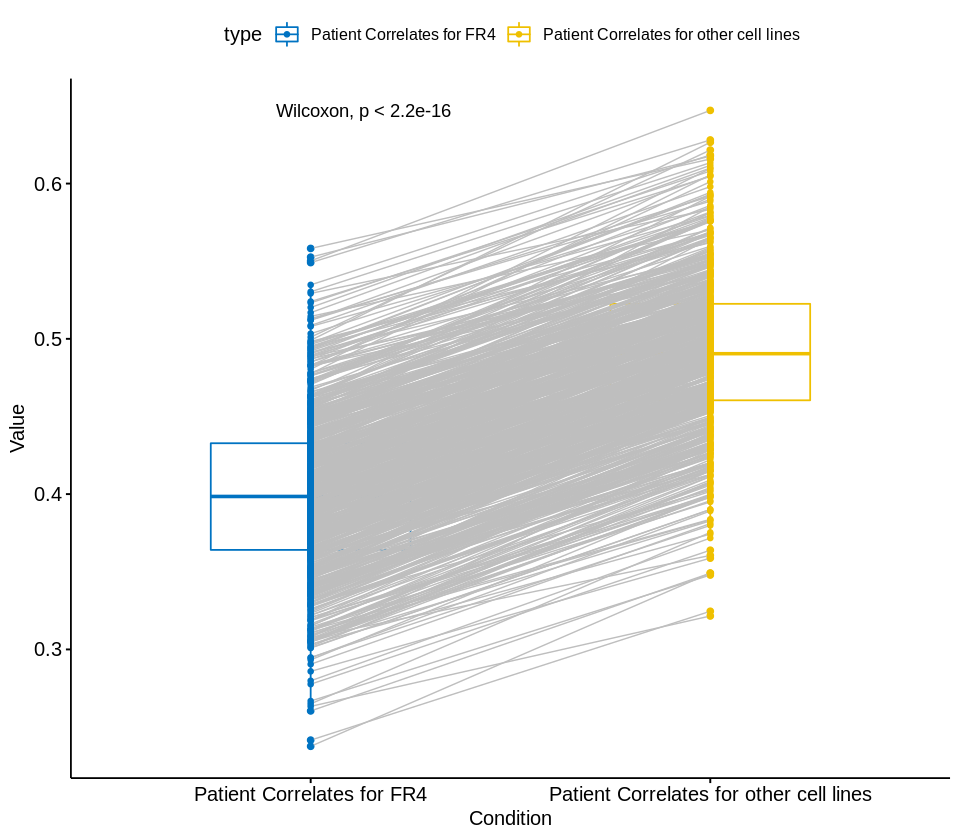

In [24]:
cor_FR4 = MM.cor.keats_5000[,'FR4']
cor_oth = MM.cor.keats_5000[,-10]
cor_oth = rowMeans(cor_oth)
cor_FR4 = as.data.frame(cor_FR4)
cor_FR4$type = 'Patient Correlates for FR4'
cor_oth = as.data.frame(cor_oth)
cor_oth$type = 'Patient Correlates for other cell lines'
colnames(cor_FR4) = c('cor', 'type')
colnames(cor_oth) = c('cor', 'type')
cor_FR4_bound = rbind(cor_FR4, cor_oth)
ggpaired(cor_FR4_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

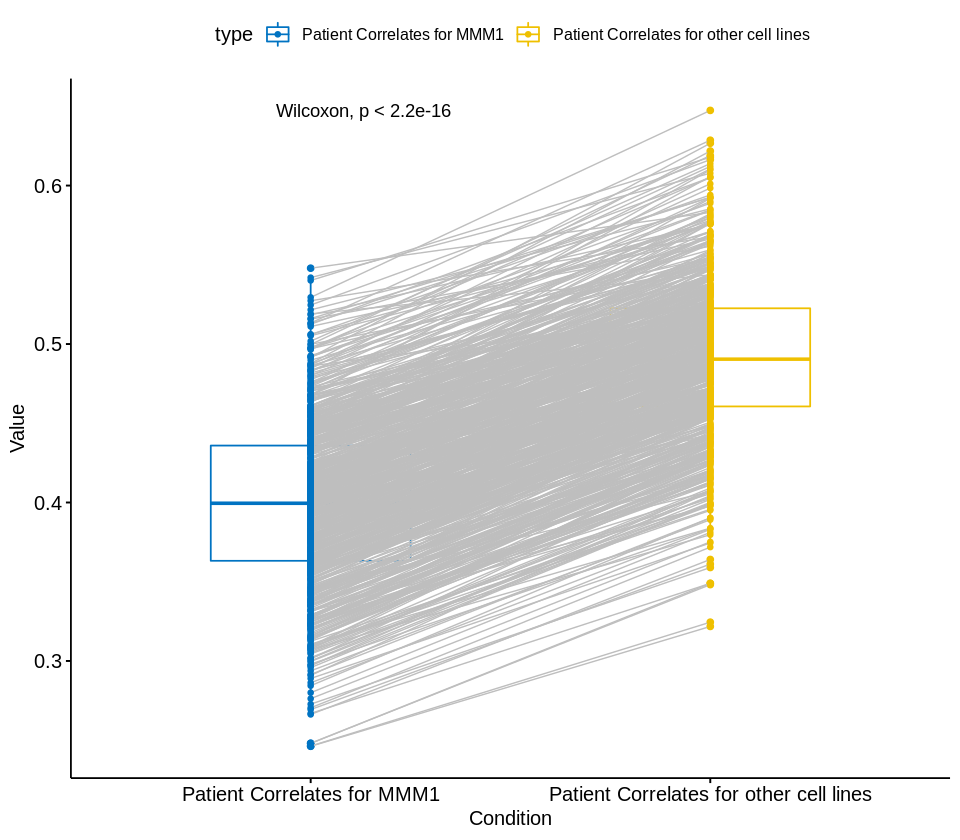

In [25]:
cor_MMM1 = MM.cor.keats_5000[,'MMM1']
cor_oth = MM.cor.keats_5000[,-44]
cor_oth = rowMeans(cor_oth)
cor_MMM1 = as.data.frame(cor_MMM1)
cor_MMM1$type = 'Patient Correlates for MMM1'
cor_oth = as.data.frame(cor_oth)
cor_oth$type = 'Patient Correlates for other cell lines'
colnames(cor_MMM1) = c('cor', 'type')
colnames(cor_oth) = c('cor', 'type')
cor_MMM1_bound = rbind(cor_MMM1, cor_oth)
ggpaired(cor_MMM1_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

cor       type 
MMRF_2801_1_BM 0.5159783 ANBL6
MMRF_2718_1_BM 0.4986851 ANBL6
MMRF_2815_1_BM 0.5271903 ANBL6
MMRF_1656_1_BM 0.6033711 ANBL6
MMRF_2461_1_BM 0.4731300 ANBL6
MMRF_2057_1_BM 0.6114980 ANBL6

cor       type            
MMRF_2801_1_BM 0.4426285 Other Cell Lines
MMRF_2718_1_BM 0.4275664 Other Cell Lines
MMRF_2815_1_BM 0.4640295 Other Cell Lines
MMRF_1656_1_BM 0.5470971 Other Cell Lines
MMRF_2461_1_BM 0.4002616 Other Cell Lines
MMRF_2057_1_BM 0.5169845 Other Cell Lines

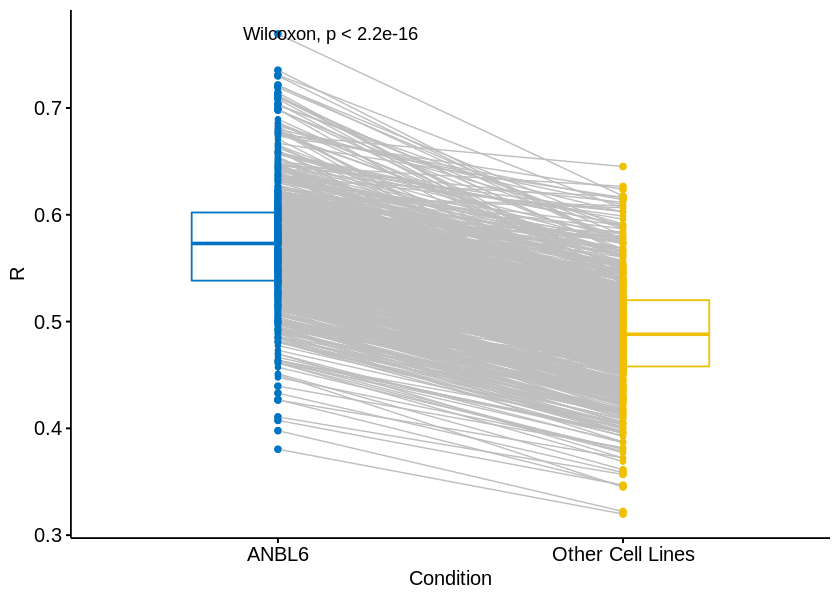

In [26]:
cor_ANBL6 = MM.cor.keats_5000[,'ANBL6']
cor_oth = MM.cor.keats_5000[,-4]
cor_oth = rowMeans(cor_oth)
cor_ANBL6 = as.data.frame(cor_ANBL6)
cor_ANBL6$type = 'ANBL6'
cor_oth = as.data.frame(cor_oth)
cor_oth$type = 'Other Cell Lines'
colnames(cor_ANBL6) = c('cor', 'type')
colnames(cor_oth) = c('cor', 'type')
cor_ANBL6_bound = rbind(cor_ANBL6, cor_oth)
head(cor_ANBL6)
head(cor_oth)
options(repr.plot.width = 7, repr.plot.height = 5)
ggpaired(cor_ANBL6_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco", ylab = 'R', legend = 'FALSE')+
  stat_compare_means(paired = TRUE)

# cor_414 = MM.cor.keats_5000[,cell_names_414]
# head(cor_414)

# cor_414_carrier = cor_414[keepc414,]
# head(cor_414_carrier)

# cor_414_opat = cor_414[!keepc414,]
# head(cor_414_opat)

# cor_414_carrier = colMeans(cor_414_carrier)
# head(cor_414_carrier)

# cor_414_opat = colMeans(cor_414_opat)
# head(cor_414_opat)

# cor_414_carrier = as.data.frame(cor_414_carrier)
# cor_414_carrier$type = 'Patients with Translocation'
# cor_414_opat = as.data.frame(cor_414_opat)
# cor_414_opat$type = 'Patients without Translocation'

# head(cor_414_carrier)
# head(cor_414_opat)

# colnames(cor_414_carrier) = c('cor', 'type')
# colnames(cor_414_opat) = c('cor', 'type')
# head(cor_414_carrier)
# head(cor_414_opat)

# cor_414_bound = rbind(cor_414_carrier, cor_414_opat)
# head(cor_414_bound)

# ggpaired(cor_414_bound, x = "type", y = "cor",
#          color = "type", line.color = "gray", line.size = 0.4,
#          palette = "jco")+
#   stat_compare_means(paired = TRUE)

cor       type 
MMRF_2801_1_BM 0.5159783 ANBL6
MMRF_2718_1_BM 0.4986851 ANBL6
MMRF_2815_1_BM 0.5271903 ANBL6
MMRF_1656_1_BM 0.6033711 ANBL6
MMRF_2461_1_BM 0.4731300 ANBL6
MMRF_2057_1_BM 0.6114980 ANBL6

cor       type  
MMRF_2801_1_BM 0.4641367 FLAM76
MMRF_2718_1_BM 0.4578769 FLAM76
MMRF_2815_1_BM 0.4632074 FLAM76
MMRF_1656_1_BM 0.5721010 FLAM76
MMRF_2461_1_BM 0.4347655 FLAM76
MMRF_2057_1_BM 0.5972272 FLAM76

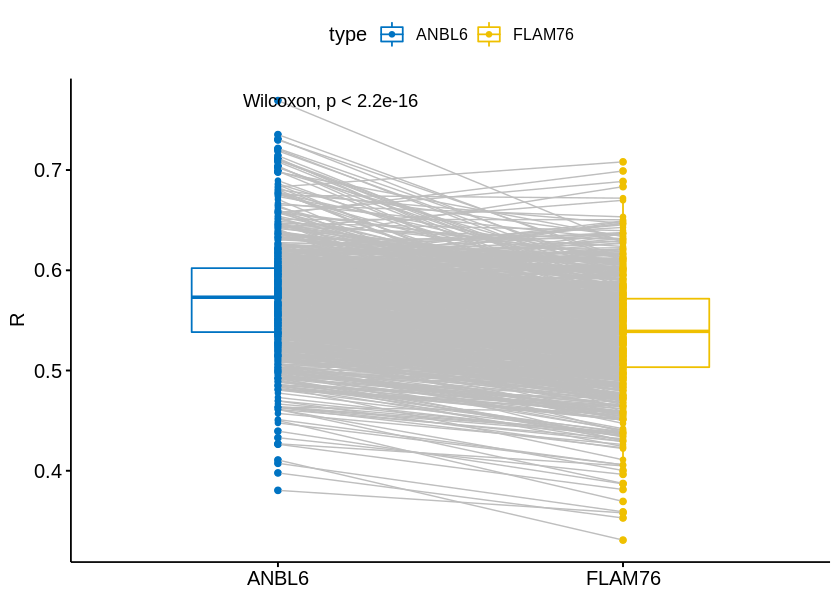

In [27]:
cor_ANBL6 = MM.cor.keats_5000[,'ANBL6']
cor_flam76 = MM.cor.keats_5000[,'FLAM76']
# cor_flam76 = rowMeans(cor_flam76)
cor_ANBL6 = as.data.frame(cor_ANBL6)
cor_ANBL6$type = 'ANBL6'
cor_flam76 = as.data.frame(cor_flam76)
cor_flam76$type = 'FLAM76'
colnames(cor_ANBL6) = c('cor', 'type')
colnames(cor_flam76) = c('cor', 'type')
cor_ANBL6_bound2 = rbind(cor_ANBL6, cor_flam76)
head(cor_ANBL6)
head(cor_flam76)
ggpaired(cor_ANBL6_bound2, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco", ylab = 'R', xlab = FALSE)+
  stat_compare_means(paired = TRUE)

In [28]:
head(cor_ANBL6_bound)
head(cor_ANBL6_bound2)
tail(cor_ANBL6_bound)
tail(cor_ANBL6_bound2)

cor       type 
MMRF_2801_1_BM 0.5159783 ANBL6
MMRF_2718_1_BM 0.4986851 ANBL6
MMRF_2815_1_BM 0.5271903 ANBL6
MMRF_1656_1_BM 0.6033711 ANBL6
MMRF_2461_1_BM 0.4731300 ANBL6
MMRF_2057_1_BM 0.6114980 ANBL6

cor       type 
MMRF_2801_1_BM 0.5159783 ANBL6
MMRF_2718_1_BM 0.4986851 ANBL6
MMRF_2815_1_BM 0.5271903 ANBL6
MMRF_1656_1_BM 0.6033711 ANBL6
MMRF_2461_1_BM 0.4731300 ANBL6
MMRF_2057_1_BM 0.6114980 ANBL6

cor       type            
MMRF_1641_1_BM1 0.4646303 Other Cell Lines
MMRF_2795_1_BM1 0.4102761 Other Cell Lines
MMRF_2316_1_BM1 0.4414167 Other Cell Lines
MMRF_2440_1_BM1 0.5045730 Other Cell Lines
MMRF_2731_1_BM1 0.5222735 Other Cell Lines
MMRF_1355_1_BM1 0.4405961 Other Cell Lines

cor       type  
MMRF_1641_1_BM1 0.4823974 FLAM76
MMRF_2795_1_BM1 0.4616064 FLAM76
MMRF_2316_1_BM1 0.5010841 FLAM76
MMRF_2440_1_BM1 0.5669222 FLAM76
MMRF_2731_1_BM1 0.5542486 FLAM76
MMRF_1355_1_BM1 0.4831361 FLAM76

cor       type  Subtype            
MMRF_2801_1_BM 0.5159783 ANBL6 ANBL6 v. All Others
MMRF_2718_1_BM 0.4986851 ANBL6 ANBL6 v. All Others
MMRF_2815_1_BM 0.5271903 ANBL6 ANBL6 v. All Others
MMRF_1656_1_BM 0.6033711 ANBL6 ANBL6 v. All Others
MMRF_2461_1_BM 0.4731300 ANBL6 ANBL6 v. All Others
MMRF_2057_1_BM 0.6114980 ANBL6 ANBL6 v. All Others

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


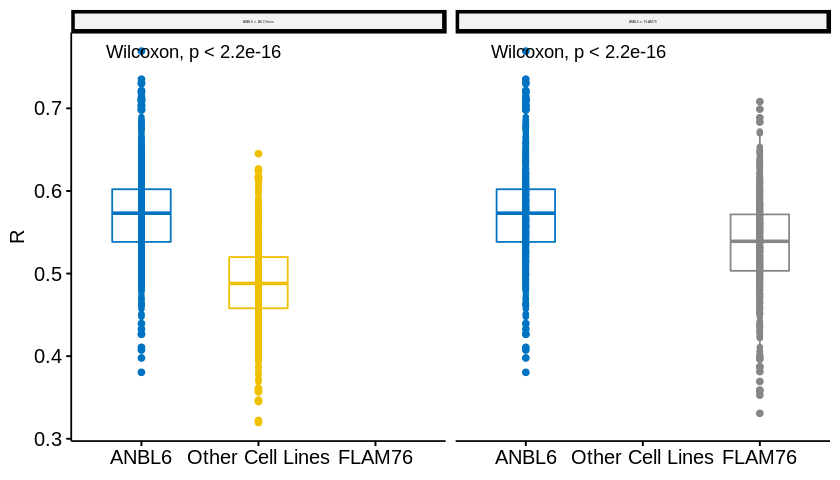

In [29]:
cor_ANBL6_bound$Subtype = 'ANBL6 v. All Others'
cor_ANBL6_bound2$Subtype = 'ANBL6 v. FLAM76'
# best_fr4_sc$Subtype = 'Best Correlated Patient to FR4 (R = 0.56)'
# worst_fr4_sc$Subtype = 'Worst Correlated Patient to FR4 (R = 0.24)'


# best_anbl_sc$Subtype = 'Best Correlated Patient to ANBL6 (R = 0.77)'
# worst_anbl_sc$Subtype = 'Worst Correlated Patient to ANBL6(R = 0.38)'
# best_fr4_sc$Subtype = 'Best Correlated Patient to FR4 (R = 0.56)'
# worst_fr4_sc$Subtype = 'Worst Correlated Patient to FR4 (R = 0.24)'


# colnames(best_anbl_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
# colnames(worst_anbl_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
# colnames(best_fr4_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
# colnames(worst_fr4_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')

# colnames(worst_anbl_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
# colnames(best_fr4_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
# colnames(worst_fr4_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')


# head(best_anbl_sc)
cor_b_final3 = rbind(cor_ANBL6_bound, cor_ANBL6_bound2)
# cor_b_final2 = rbind(cor_b_final2, best_fr4_sc)
# cor_b_final2 = rbind(cor_b_final2, worst_fr4_sc)

p = ggpaired(cor_b_final3, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.2,
         palette = "jco", ylab = "R", xlab = "FALSE", legend = 'FALSE', group = 1)+#, facet.by = "Subtype")+
  stat_compare_means(paired = TRUE)

head(cor_b_final3)
# ggscatter(worst_mmm1_sc, x = 'Cell Line Counts', y = 'Patient Counts')#, label = 'gene_names', 
#          label.select = sig_up_wmmm12, 
#           xlab = 'MMM1 Gene Counts', ylab  = 'Patient Gene Counts (Best Correlated)')

# p = ggscatter(cor_b_final2, x = "type", y = "cor", #xlab = 'Cell Line Counts', 
#               ylab = 'R')#, xlim = c(5,25), ylim = c(5,25))#, facet.by = 'Subtype')#,
#          color = "type", line.color = "gray", line.size = 0.4,
#          palette = "jco", ylab = "R", xlab = "FALSE", legend = 'FALSE')+#, facet.by = "Subtype")+
#   stat_compare_means(paired = TRUE)

# pdf('bplots.pdf')

# options(repr.plot.height = 5)
options(repr.plot.height = 4 )
facet(p, facet.by = "Subtype",#, nrow = 2, ncol = 2, 
      panel.labs.font = list(face = NULL,color = NULL, size = 2, angle = NULL),
     panel.labs.background = list(linetype = 1, size = 2))#, scales = 'free_x')

In [30]:
#### DATA FOR TRANSLOCATIONS ####

MM_patients_trans = data.frame(fread("IA13a.structural.variants.annot.translocations.clean.maxHom0.8.minMap0.2.clonality.readRange10000bp.cnvRange2000bp.common.txt"))
MM_patient_trans_ids = MM_patients_trans[,'sample']

[1] 89

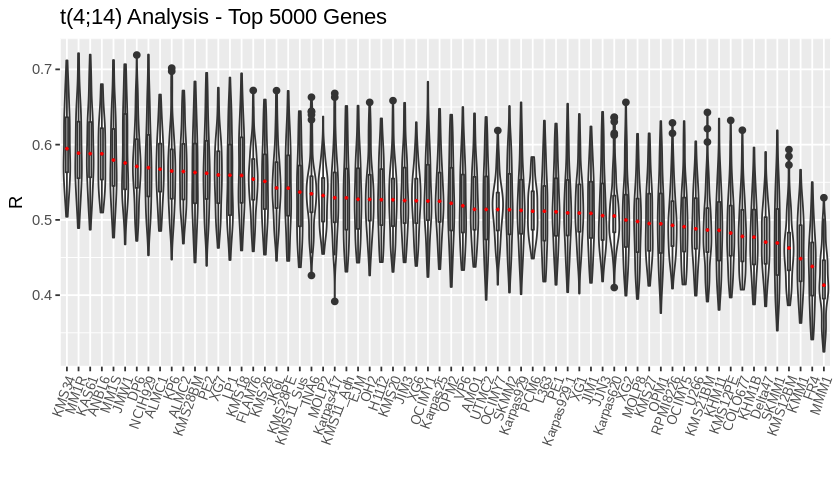

In [31]:
# extracting patients with 4;14 translocation who are also newly diagnosed

keep414 = as.logical(MM_patients_trans[,'t.4.14.'])
MM_patients_trans_414 = MM_patient_trans_ids[keep414]
MM_patients_trans_414 = unique(MM_patients_trans_414)
MM_patients_new_trans_414 = filter(as.data.frame(MM_patients_trans_414),
                                   str_extract(as.data.frame(MM_patients_trans_414)[,1], "_[0-9]_") == "_1_")
keepc414 = colnames(MM_patients) %in% MM_patients_new_trans_414[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_414 = norm_pat[,keepc414]
norm_combined_414 = cbind(norm_cell, norm_pat_414)
norm_combined_414_5000 = norm_combined_414[keepi5000, ]
# norm_combined_414_10000 = norm_combined_414[keepi10000, ]

# plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_414, colnames(norm_pat_414), 't(4;14) Analysis - All Genes')
makeplots(norm_combined_414_5000, colnames(norm_pat_414), colnames(MM_cell_line), 't(4;14) Analysis - Top 5000 Genes')
# makeplots(norm_combined_414_10000, colnames(norm_pat_414), 't(4;14) Analysis - Top 10000 Genes')
length(MM_patients_new_trans_414[,1])

[1] 140

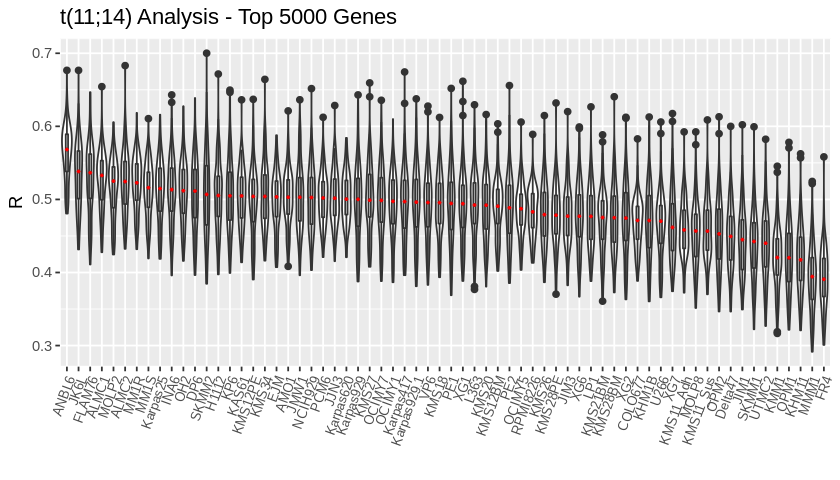

In [32]:
# extracting patients with 11;14 translocation who are also newly diagnosed

keep1114 = as.logical(MM_patients_trans[,'t.11.14.'])
MM_patients_trans_1114 = MM_patient_trans_ids[keep1114]
MM_patients_trans_1114 = unique(MM_patients_trans_1114)
MM_patients_new_trans_1114 = filter(as.data.frame(MM_patients_trans_1114),
                                   str_extract(as.data.frame(MM_patients_trans_1114)[,1], "_[0-9]_") == "_1_")
keepc1114 = colnames(MM_patients) %in% MM_patients_new_trans_1114[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_1114 = norm_pat[,keepc1114]
norm_combined_1114 = cbind(norm_cell, norm_pat_1114)
norm_combined_1114_5000 = norm_combined_1114[keepi5000, ]
# norm_combined_1114_10000 = norm_combined_1114[keepi10000, ]

# plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_1114, colnames(norm_pat_1114), 't(11;14) Analysis - All Genes')
makeplots(norm_combined_1114_5000, colnames(norm_pat_1114), colnames(MM_cell_line), 't(11;14) Analysis - Top 5000 Genes')
# makeplots(norm_combined_1114_10000, colnames(norm_pat_1114), 't(11;14) Analysis - Top 10000 Genes')
length(MM_patients_new_trans_1114[,1])

[1] 30

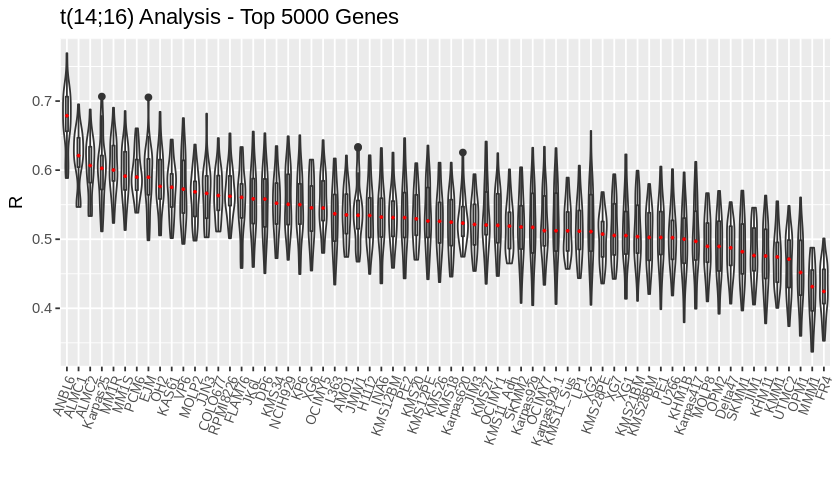

In [33]:
# extracting patients with 14;16 translocation who are also newly diagnosed

keep1416 = as.logical(MM_patients_trans[,'t.14.16.'])
MM_patients_trans_1416 = MM_patient_trans_ids[keep1416]
MM_patients_trans_1416 = unique(MM_patients_trans_1416)
MM_patients_new_trans_1416 = filter(as.data.frame(MM_patients_trans_1416),
                                   str_extract(as.data.frame(MM_patients_trans_1416)[,1], "_[0-9]_") == "_1_")
keepc1416 = colnames(MM_patients) %in% MM_patients_new_trans_1416[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_1416 = norm_pat[,keepc1416]
norm_combined_1416 = cbind(norm_cell, norm_pat_1416)
norm_combined_1416_5000 = norm_combined_1416[keepi5000, ]
# norm_combined_1416_10000 = norm_combined_1416[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_1416, colnames(norm_pat_1416), 't(14;16) Analysis - All Genes')
makeplots(norm_combined_1416_5000, colnames(norm_pat_1416), colnames(MM_cell_line), 't(14;16) Analysis - Top 5000 Genes')
# makeplots(norm_combined_1416_10000, colnames(norm_pat_1416), 't(14;16) Analysis - Top 10000 Genes')
length(MM_patients_new_trans_1416[,1])

[1] 8

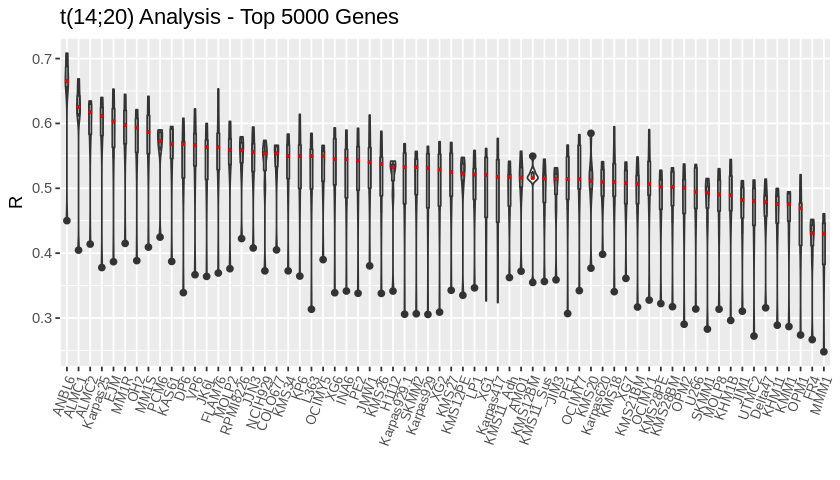

In [34]:
# extracting patients with 14;16 translocation who are also newly diagnosed

keep1420 = as.logical(MM_patients_trans[,'t.14.20.'])
MM_patients_trans_1420 = MM_patient_trans_ids[keep1420]
MM_patients_trans_1420 = unique(MM_patients_trans_1420)
MM_patients_new_trans_1420 = filter(as.data.frame(MM_patients_trans_1420),
                                   str_extract(as.data.frame(MM_patients_trans_1420)[,1], "_[0-9]_") == "_1_")
keepc1420 = colnames(MM_patients) %in% MM_patients_new_trans_1420[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_1420 = norm_pat[,keepc1420]
norm_combined_1420 = cbind(norm_cell, norm_pat_1420)
norm_combined_1420_5000 = norm_combined_1420[keepi5000, ]
# norm_combined_1416_10000 = norm_combined_1416[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_1416, colnames(norm_pat_1416), 't(14;16) Analysis - All Genes')
makeplots(norm_combined_1420_5000, colnames(norm_pat_1420), colnames(MM_cell_line), 't(14;20) Analysis - Top 5000 Genes')
# makeplots(norm_combined_1416_10000, colnames(norm_pat_1416), 't(14;16) Analysis - Top 10000 Genes')
length(MM_patients_new_trans_1420[,1])

In [35]:
#### Cell line info ####

MM_pat_mut = read.delim("MMRF_CoMMpass_IA13a_IGV_All_Canonical_Variants.mut", stringsAsFactors = F)

[1] 248

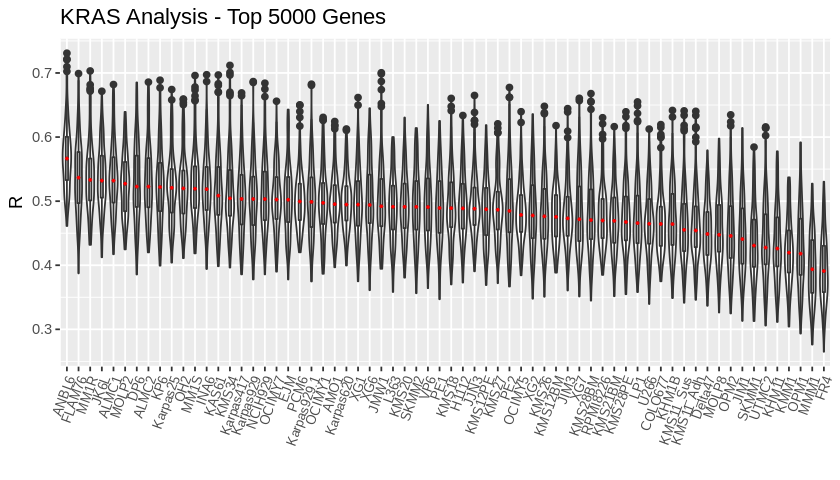

In [36]:
# extracting patients with KRAS mutation who are also newly diagnosed

KRAS_mut = filter(MM_pat_mut, GENE == "KRAS") %>%
  select(sample, EFFECT, HGVS_P, FEATURE) %>%
  filter(EFFECT == "missense_variant") %>%
  mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
  filter(position %in% c(12, 13, 61))

MM_pat_mut_KRAS = unique(KRAS_mut$sample)
keepcKRAS = colnames(MM_patients) %in% MM_pat_mut_KRAS

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_KRAS = norm_pat[,keepcKRAS]
norm_combined_KRAS = cbind(norm_cell, norm_pat_KRAS)
norm_combined_KRAS_5000 = norm_combined_KRAS[keepi5000, ]
# norm_combined_KRAS_10000 = norm_combined_KRAS[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_KRAS, colnames(norm_pat_KRAS), 'KRAS Analysis - All Genes')
makeplots(norm_combined_KRAS_5000, colnames(norm_pat_KRAS), colnames(MM_cell_line), 'KRAS Analysis - Top 5000 Genes')
# makeplots(norm_combined_KRAS_10000, colnames(norm_pat_KRAS), 'KRAS Analysis - Top 10000 Genes')
length(MM_pat_mut_KRAS)

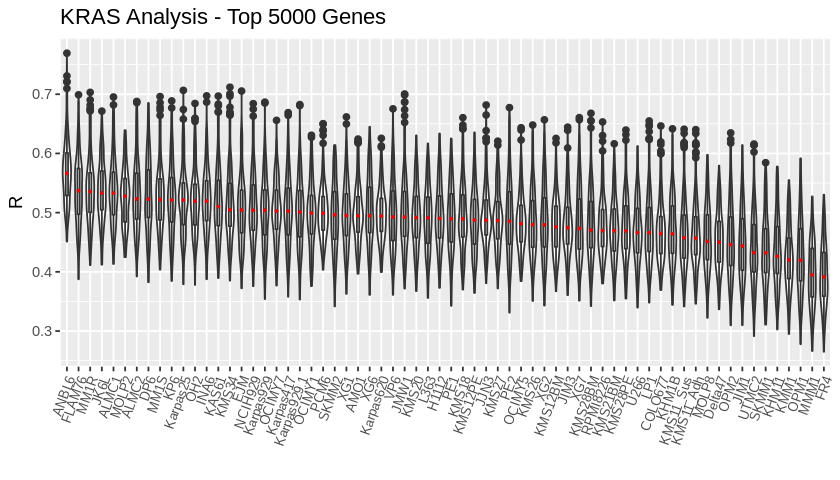

In [37]:
# extracting patients with KRAS mutation who are also newly diagnosed

# KRAS_mut2 = filter(MM_pat_mut, GENE == "KRAS") %>%
#   select(sample, EFFECT, HGVS_P, FEATURE) %>%
#   filter(EFFECT == "missense_variant") %>%
#   mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
#   filter(position %in% c(600))
KRAS_mut2 = filter(MM_pat_mut, EFFECT %in% c("missense_variant",
                                         "frameshift_variant",
                                         "stop_gained",
                                         "start_lost",
                                         "stop_lost",
                                         "missense_variant&splice_region_variant",
                                         "frameshift_variant&splice_region_variant",
                                         "disruptive_inframe_deletion",
                                         "stop_gained&splice_region_variant",
                                         "frameshift_variant&stop_gained",
                                         "frameshift_variant&splice_acceptor_variant&splice_region_variant&intron_variant",
                                         "frameshift_variant&splice_donor_variant&splice_region_variant&intron_variant",
                                         "splice_donor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&splice_region_variant",
                                         "disruptive_inframe_insertion",
                                         "stop_gained&disruptive_inframe_deletion",
                                         "frameshift_variant&start_lost",
                                         "stop_gained&disruptive_inframe_insertion",
                                         "disruptive_inframe_deletion&splice_region_variant",
                                         "disruptive_inframe_insertion&splice_region_variant",
                                         "start_lost&splice_region_variant",
                                         "start_lost&inframe_deletion",
                                         "frameshift_variant&stop_lost",
                                         "splice_acceptor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&inframe_deletion")) %>%
  filter(str_extract(sample, "_[0-9]_") == "_1_")  %>%
  filter(GENE == 'KRAS')

MM_pat_mut_KRAS2 = unique(KRAS_mut2$sample)
keepcKRAS2 = colnames(MM_patients) %in% MM_pat_mut_KRAS2

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_KRAS2 = norm_pat[,keepcKRAS2]
norm_combined_KRAS2 = cbind(norm_cell, norm_pat_KRAS2)
norm_combined_KRAS_50002 = norm_combined_KRAS2[keepi5000, ]
# norm_combined_KRAS_10000 = norm_combined_KRAS[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_KRAS, colnames(norm_pat_KRAS), 'KRAS Analysis - All Genes')
makeplots(norm_combined_KRAS_50002, colnames(norm_pat_KRAS2), colnames(MM_cell_line), 'KRAS Analysis - Top 5000 Genes')
# makeplots(norm_combined_KRAS_10000, colnames(norm_pat_KRAS), 'KRAS Analysis - Top 10000 Genes')

[1] 235

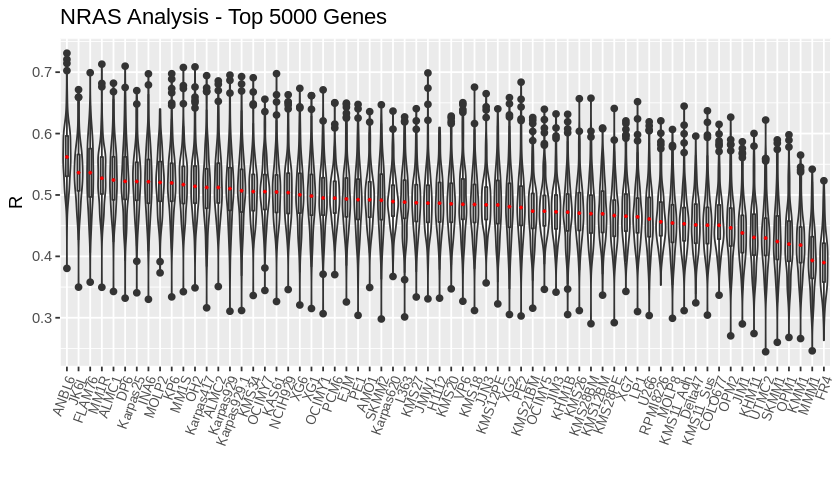

In [38]:
# extracting patients with NRAS mutation who are also newly diagnosed

NRAS_mut = filter(MM_pat_mut, GENE == "NRAS") %>%
  select(sample, EFFECT, HGVS_P, FEATURE) %>%
  filter(EFFECT == "missense_variant") %>%
  mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
  filter(position %in% c(12, 13, 61))

MM_pat_mut_NRAS = unique(NRAS_mut$sample)
keepcNRAS = colnames(MM_patients) %in% MM_pat_mut_NRAS

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_NRAS = norm_pat[,keepcNRAS]
norm_combined_NRAS = cbind(norm_cell, norm_pat_NRAS)
norm_combined_NRAS_5000 = norm_combined_NRAS[keepi5000, ]
# norm_combined_NRAS_10000 = norm_combined_NRAS[keepi10000, ]

# plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_NRAS, colnames(norm_pat_NRAS), 'NRAS Analysis - All Genes')
makeplots(norm_combined_NRAS_5000, colnames(norm_pat_NRAS), colnames(MM_cell_line), 'NRAS Analysis - Top 5000 Genes')
# makeplots(norm_combined_NRAS_10000, colnames(norm_pat_NRAS), 'NRAS Analysis - Top 10000 Genes')
length(MM_pat_mut_NRAS)

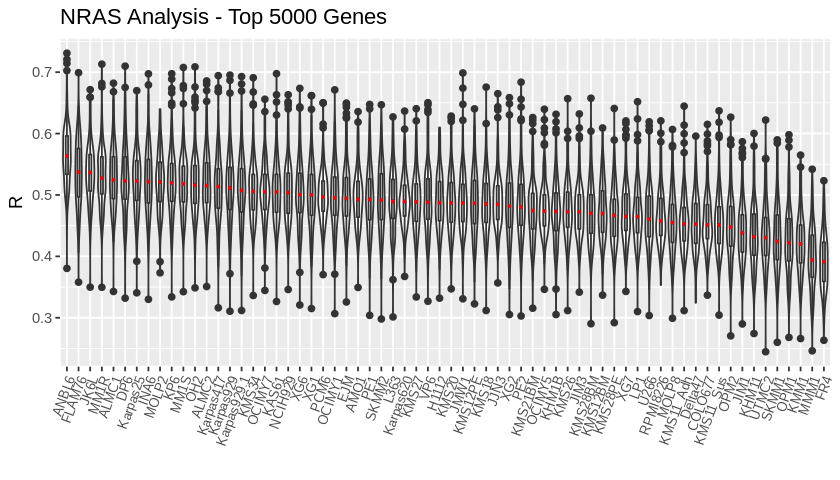

In [39]:
# extracting patients with NRAS mutation who are also newly diagnosed

# NRAS_mut2 = filter(MM_pat_mut, GENE == "NRAS") %>%
#   select(sample, EFFECT, HGVS_P, FEATURE) %>%
#   filter(EFFECT == "missense_variant") %>%
#   mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
#   filter(position %in% c(600))
NRAS_mut2 = filter(MM_pat_mut, EFFECT %in% c("missense_variant",
                                         "frameshift_variant",
                                         "stop_gained",
                                         "start_lost",
                                         "stop_lost",
                                         "missense_variant&splice_region_variant",
                                         "frameshift_variant&splice_region_variant",
                                         "disruptive_inframe_deletion",
                                         "stop_gained&splice_region_variant",
                                         "frameshift_variant&stop_gained",
                                         "frameshift_variant&splice_acceptor_variant&splice_region_variant&intron_variant",
                                         "frameshift_variant&splice_donor_variant&splice_region_variant&intron_variant",
                                         "splice_donor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&splice_region_variant",
                                         "disruptive_inframe_insertion",
                                         "stop_gained&disruptive_inframe_deletion",
                                         "frameshift_variant&start_lost",
                                         "stop_gained&disruptive_inframe_insertion",
                                         "disruptive_inframe_deletion&splice_region_variant",
                                         "disruptive_inframe_insertion&splice_region_variant",
                                         "start_lost&splice_region_variant",
                                         "start_lost&inframe_deletion",
                                         "frameshift_variant&stop_lost",
                                         "splice_acceptor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&inframe_deletion")) %>%
  filter(str_extract(sample, "_[0-9]_") == "_1_")  %>%
  filter(GENE == 'NRAS')

MM_pat_mut_NRAS2 = unique(NRAS_mut2$sample)
keepcNRAS2 = colnames(MM_patients) %in% MM_pat_mut_NRAS2

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_NRAS2 = norm_pat[,keepcNRAS2]
norm_combined_NRAS2 = cbind(norm_cell, norm_pat_NRAS2)
norm_combined_NRAS_50002 = norm_combined_NRAS2[keepi5000, ]
# norm_combined_NRAS_10000 = norm_combined_NRAS[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_NRAS, colnames(norm_pat_NRAS), 'NRAS Analysis - All Genes')
makeplots(norm_combined_NRAS_50002, colnames(norm_pat_NRAS2), colnames(MM_cell_line), 'NRAS Analysis - Top 5000 Genes')
# makeplots(norm_combined_NRAS_10000, colnames(norm_pat_NRAS), 'NRAS Analysis - Top 10000 Genes')

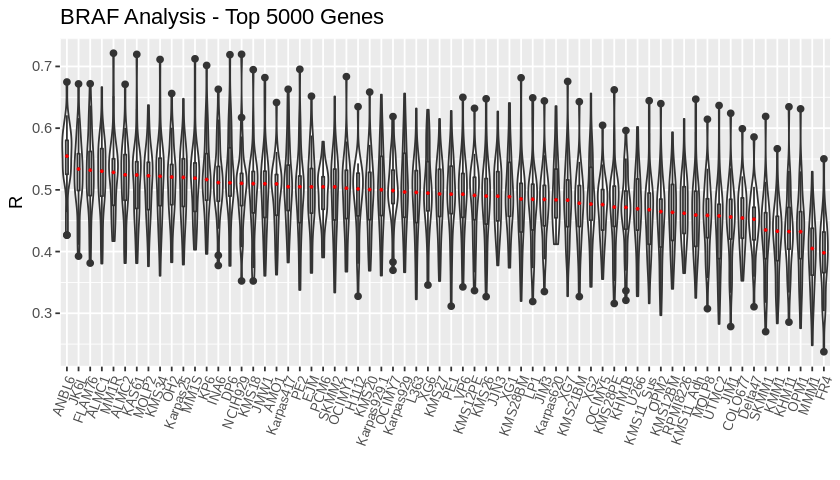

In [40]:
# extracting patients with BRAF mutation who are also newly diagnosed

BRAF_mut = filter(MM_pat_mut, GENE == "BRAF") %>%
  select(sample, EFFECT, HGVS_P, FEATURE) %>%
  filter(EFFECT == "missense_variant") %>%
  mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
  filter(position %in% c(600))

MM_pat_mut_BRAF = unique(BRAF_mut$sample)
keepcBRAF = colnames(MM_patients) %in% MM_pat_mut_BRAF

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_BRAF = norm_pat[,keepcBRAF]
norm_combined_BRAF = cbind(norm_cell, norm_pat_BRAF)
norm_combined_BRAF_5000 = norm_combined_BRAF[keepi5000, ]
# norm_combined_BRAF_10000 = norm_combined_BRAF[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_BRAF, colnames(norm_pat_BRAF), 'BRAF Analysis - All Genes')
makeplots(norm_combined_BRAF_5000, colnames(norm_pat_BRAF), colnames(MM_cell_line), 'BRAF Analysis - Top 5000 Genes')
# makeplots(norm_combined_BRAF_10000, colnames(norm_pat_BRAF), 'BRAF Analysis - Top 10000 Genes')

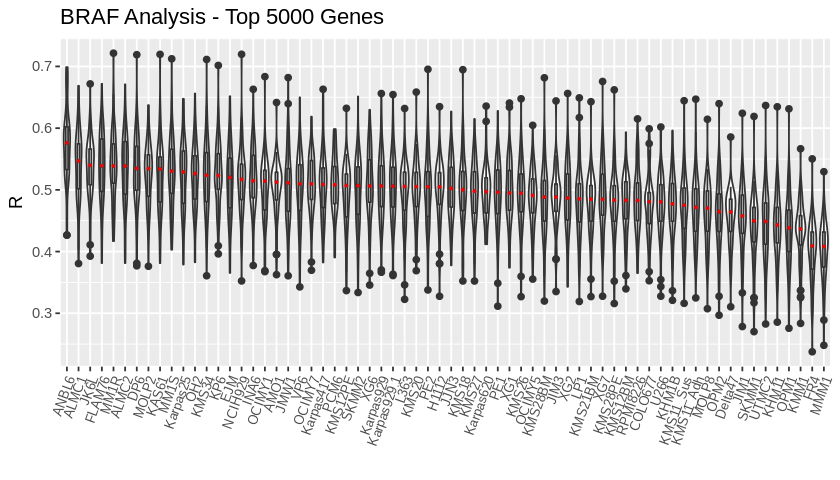

In [41]:
# extracting patients with BRAF mutation who are also newly diagnosed

# BRAF_mut2 = filter(MM_pat_mut, GENE == "BRAF") %>%
#   select(sample, EFFECT, HGVS_P, FEATURE) %>%
#   filter(EFFECT == "missense_variant") %>%
#   mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
#   filter(position %in% c(600))
BRAF_mut2 = filter(MM_pat_mut, EFFECT %in% c("missense_variant",
                                         "frameshift_variant",
                                         "stop_gained",
                                         "start_lost",
                                         "stop_lost",
                                         "missense_variant&splice_region_variant",
                                         "frameshift_variant&splice_region_variant",
                                         "disruptive_inframe_deletion",
                                         "stop_gained&splice_region_variant",
                                         "frameshift_variant&stop_gained",
                                         "frameshift_variant&splice_acceptor_variant&splice_region_variant&intron_variant",
                                         "frameshift_variant&splice_donor_variant&splice_region_variant&intron_variant",
                                         "splice_donor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&splice_region_variant",
                                         "disruptive_inframe_insertion",
                                         "stop_gained&disruptive_inframe_deletion",
                                         "frameshift_variant&start_lost",
                                         "stop_gained&disruptive_inframe_insertion",
                                         "disruptive_inframe_deletion&splice_region_variant",
                                         "disruptive_inframe_insertion&splice_region_variant",
                                         "start_lost&splice_region_variant",
                                         "start_lost&inframe_deletion",
                                         "frameshift_variant&stop_lost",
                                         "splice_acceptor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&inframe_deletion")) %>%
  filter(str_extract(sample, "_[0-9]_") == "_1_")  %>%
  filter(GENE == 'BRAF')

MM_pat_mut_BRAF2 = unique(BRAF_mut2$sample)
keepcBRAF2 = colnames(MM_patients) %in% MM_pat_mut_BRAF2

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_BRAF2 = norm_pat[,keepcBRAF2]
norm_combined_BRAF2 = cbind(norm_cell, norm_pat_BRAF2)
norm_combined_BRAF_50002 = norm_combined_BRAF2[keepi5000, ]
# norm_combined_BRAF_10000 = norm_combined_BRAF[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_BRAF, colnames(norm_pat_BRAF), 'BRAF Analysis - All Genes')
makeplots(norm_combined_BRAF_50002, colnames(norm_pat_BRAF2), colnames(MM_cell_line), 'BRAF Analysis - Top 5000 Genes')
# makeplots(norm_combined_BRAF_10000, colnames(norm_pat_BRAF), 'BRAF Analysis - Top 10000 Genes')

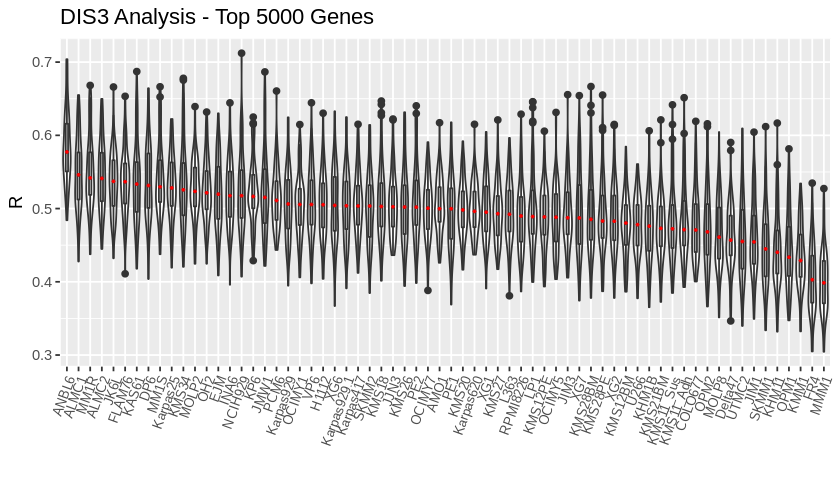

In [42]:
# extracting patients with DIS3 mutation who are also newly diagnosed

DIS3_mut = filter(MM_pat_mut, EFFECT %in% c("missense_variant",
                                         "frameshift_variant",
                                         "stop_gained",
                                         "start_lost",
                                         "stop_lost",
                                         "missense_variant&splice_region_variant",
                                         "frameshift_variant&splice_region_variant",
                                         "disruptive_inframe_deletion",
                                         "stop_gained&splice_region_variant",
                                         "frameshift_variant&stop_gained",
                                         "frameshift_variant&splice_acceptor_variant&splice_region_variant&intron_variant",
                                         "frameshift_variant&splice_donor_variant&splice_region_variant&intron_variant",
                                         "splice_donor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&splice_region_variant",
                                         "disruptive_inframe_insertion",
                                         "stop_gained&disruptive_inframe_deletion",
                                         "frameshift_variant&start_lost",
                                         "stop_gained&disruptive_inframe_insertion",
                                         "disruptive_inframe_deletion&splice_region_variant",
                                         "disruptive_inframe_insertion&splice_region_variant",
                                         "start_lost&splice_region_variant",
                                         "start_lost&inframe_deletion",
                                         "frameshift_variant&stop_lost",
                                         "splice_acceptor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&inframe_deletion")) %>%
  filter(str_extract(sample, "_[0-9]_") == "_1_")  %>%
  filter(GENE == 'DIS3')

MM_pat_mut_DIS3 = unique(DIS3_mut$sample)
keepcDIS3 = colnames(MM_patients) %in% MM_pat_mut_DIS3

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_DIS3 = norm_pat[,keepcDIS3]
norm_combined_DIS3 = cbind(norm_cell, norm_pat_DIS3)
norm_combined_DIS3_5000 = norm_combined_DIS3[keepi5000, ]
# norm_combined_DIS3_10000 = norm_combined_DIS3[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_DIS3, colnames(norm_pat_DIS3), 'DIS3 Analysis - All Genes')
makeplots(norm_combined_DIS3_5000, colnames(norm_pat_DIS3), colnames(MM_cell_line), 'DIS3 Analysis - Top 5000 Genes')
# makeplots(norm_combined_DIS3_10000, colnames(norm_pat_DIS3), 'DIS3 Analysis - Top 10000 Genes')

[1] 88

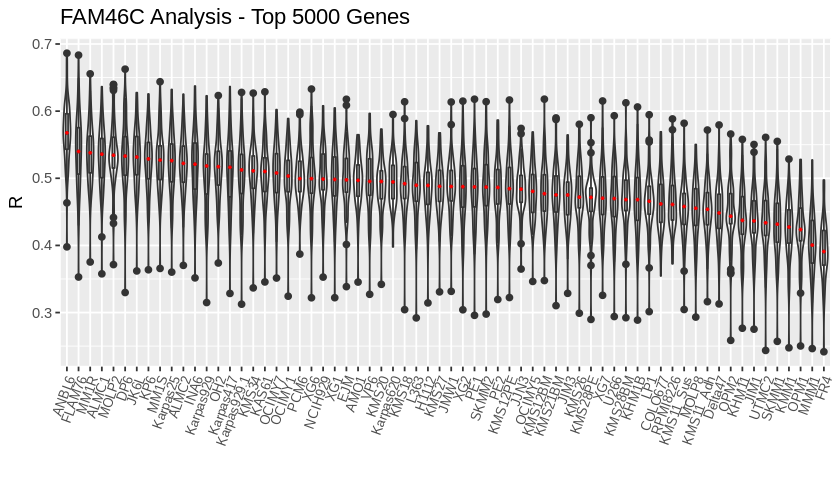

In [43]:
# extracting patients with FAM46C mutation who are also newly diagnosed

FAM46C_mut = filter(MM_pat_mut, EFFECT %in% c("missense_variant",
                                         "frameshift_variant",
                                         "stop_gained",
                                         "start_lost",
                                         "stop_lost",
                                         "missense_variant&splice_region_variant",
                                         "frameshift_variant&splice_region_variant",
                                         "disruptive_inframe_deletion",
                                         "stop_gained&splice_region_variant",
                                         "frameshift_variant&stop_gained",
                                         "frameshift_variant&splice_acceptor_variant&splice_region_variant&intron_variant",
                                         "frameshift_variant&splice_donor_variant&splice_region_variant&intron_variant",
                                         "splice_donor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&splice_region_variant",
                                         "disruptive_inframe_insertion",
                                         "stop_gained&disruptive_inframe_deletion",
                                         "frameshift_variant&start_lost",
                                         "stop_gained&disruptive_inframe_insertion",
                                         "disruptive_inframe_deletion&splice_region_variant",
                                         "disruptive_inframe_insertion&splice_region_variant",
                                         "start_lost&splice_region_variant",
                                         "start_lost&inframe_deletion",
                                         "frameshift_variant&stop_lost",
                                         "splice_acceptor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&inframe_deletion")) %>%
  filter(str_extract(sample, "_[0-9]_") == "_1_")  %>%
  filter(GENE == 'FAM46C')

MM_pat_mut_FAM46C = unique(FAM46C_mut$sample)
length(MM_pat_mut_FAM46C)
keepcFAM46C = colnames(MM_patients) %in% MM_pat_mut_FAM46C

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_FAM46C = norm_pat[,keepcFAM46C]
norm_combined_FAM46C = cbind(norm_cell, norm_pat_FAM46C)
norm_combined_FAM46C_5000 = norm_combined_FAM46C[keepi5000, ]
# norm_combined_FAM46C_10000 = norm_combined_FAM46C[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_FAM46C, colnames(norm_pat_FAM46C), 'FAM46C Analysis - All Genes')
makeplots(norm_combined_FAM46C_5000, colnames(norm_pat_FAM46C), colnames(MM_cell_line), 'FAM46C Analysis - Top 5000 Genes')
# makeplots(norm_combined_FAM46C_10000, colnames(norm_pat_FAM46C), 'FAM46C Analysis - Top 10000 Genes')

In [44]:
cell_names_414 = c('JIM1', 'JIM3', 'JMW1', 'KAS61', 'KHM11', 
                  'KMS11_Adh', 'KMS11_Sus', 'KMS18', 'KMS26',
                  'KMS28BM', 'KMS28PE', 'KMS34', 'LP1',
                  'NCIH929', 'OPM1', 'OPM2', 'PE2', 'UTMC2',
                  'XG7')

cell_names_1114 = c('FLAM76', 'H1112', 'INA6', 'Karpas620', 'KMS12BM',
                   'KMS12PE', 'KMS21BM', 'KMS27', 'MMM1', 'MOLP8',
                   'OCIMY7', 'PE1', 'SKMM2', 'U266', 'XG1')

cell_names_1416 = c('ANBL6', 'JJN3', 'KMS11_Adh', 'KMS11_Sus',
                   'MM1R', 'MM1S', 'OCIMY5', 'PCM6', 'VP6')

cell_names_1420 = c('ALMC1', 'ALMC2', 'EJM', 'Karpas25', 'OH2', 'SKMM1')

In [45]:
MM.cor.keats_5000_means = sort(colMeans(MM.cor.keats_5000))
MM.cor.keats_10000_means = sort(colMeans(MM.cor.keats_10000))
head(MM.cor.keats_5000_means)

MMM1       FR4      KMM1      OPM1     KHM11     SKMM1 
0.3980913 0.3985122 0.4272517 0.4300588 0.4372499 0.4376553

In [46]:
head(sort(colMeans(MM.cor.keats_10000)))

MMM1       FR4      KMM1      OPM1     SKMM1     KHM11 
0.5956000 0.5998491 0.6250690 0.6258181 0.6356623 0.6366446

In [47]:
rank_gen = c(1:length(MM.cor.keats_10000_means))

In [48]:
MM.cor.keats_5000_means = as.data.frame(MM.cor.keats_5000_means)
MM.cor.keats_5000_means$rank = rank_gen
MM.cor.keats_5000_means$type = 'Top 5000 genes'
MM.cor.keats_5000_means = MM.cor.keats_5000_means[-1]
MM.cor.keats_10000_means = as.data.frame(MM.cor.keats_10000_means)
MM.cor.keats_10000_means$rank = rank_gen
MM.cor.keats_10000_means$type = 'Top 10000 genes'
MM.cor.keats_10000_means = MM.cor.keats_10000_means[-1]
head(MM.cor.keats_5000_means)

rank type          
MMM1  1    Top 5000 genes
FR4   2    Top 5000 genes
KMM1  3    Top 5000 genes
OPM1  4    Top 5000 genes
KHM11 5    Top 5000 genes
SKMM1 6    Top 5000 genes

In [49]:
head(MM.cor.keats_10000_means)

rank type           
MMM1  1    Top 10000 genes
FR4   2    Top 10000 genes
KMM1  3    Top 10000 genes
OPM1  4    Top 10000 genes
SKMM1 5    Top 10000 genes
KHM11 6    Top 10000 genes

Warning message:
"Computation failed in `stat_compare_means()`:
arguments imply differing number of rows: 0, 1"

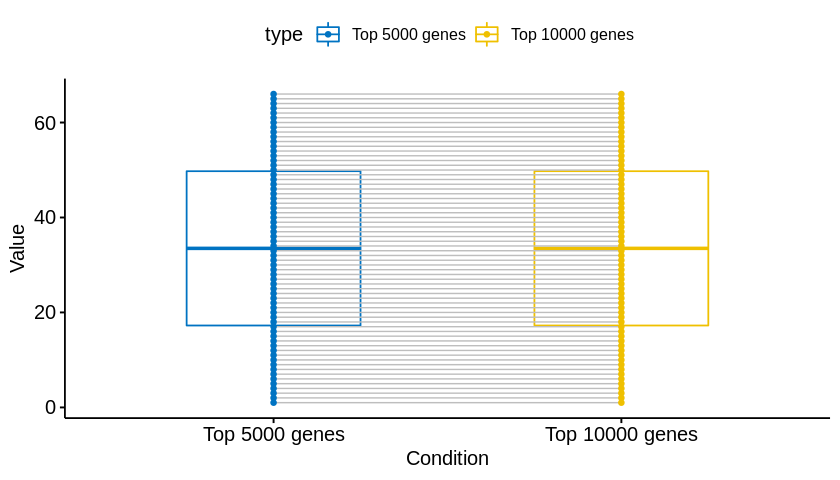

In [50]:
MM.cor.keats_bound_ranks = rbind(MM.cor.keats_5000_means, MM.cor.keats_10000_means)
ggpaired(MM.cor.keats_bound_ranks, x = "type", y = "rank",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

KMM1     HUNS1 KMS11_Sus  RPMI8226      KE97   KMS12BM 
0.4271982 0.4496104 0.4622572 0.4633144 0.4706885 0.4707009

rank type          
KMM1      1    Top 5000 genes
HUNS1     2    Top 5000 genes
KMS11_Sus 3    Top 5000 genes
RPMI8226  4    Top 5000 genes
KE97      5    Top 5000 genes
KMS12BM   6    Top 5000 genes

Warning message:
"Computation failed in `stat_compare_means()`:
arguments imply differing number of rows: 0, 1"

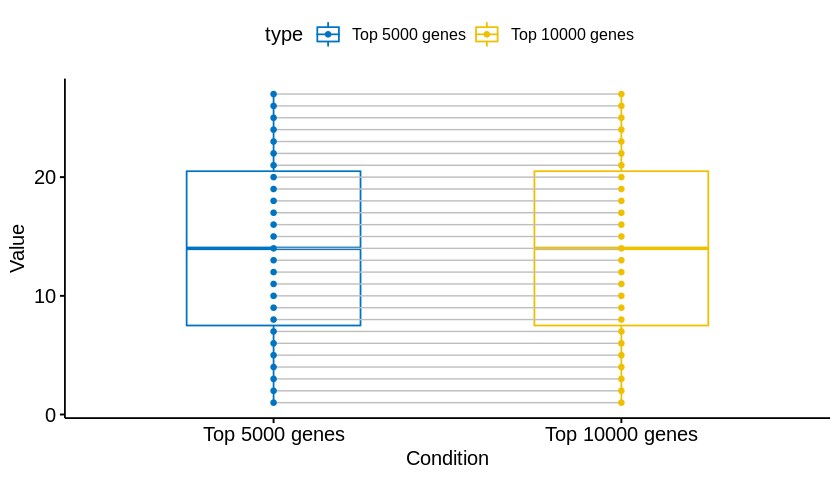

In [51]:
MM.cor.ccle_5000_means = sort(colMeans(MM.cor.ccle_5000))
MM.cor.ccle_10000_means = sort(colMeans(MM.cor.ccle_10000))
head(MM.cor.ccle_5000_means)

rank_gen2 = c(1:length(MM.cor.ccle_10000_means))

MM.cor.ccle_5000_means = as.data.frame(MM.cor.ccle_5000_means)
MM.cor.ccle_5000_means$rank = rank_gen2
MM.cor.ccle_5000_means$type = 'Top 5000 genes'
MM.cor.ccle_5000_means = MM.cor.ccle_5000_means[-1]
MM.cor.ccle_10000_means = as.data.frame(MM.cor.ccle_10000_means)
MM.cor.ccle_10000_means$rank = rank_gen2
MM.cor.ccle_10000_means$type = 'Top 10000 genes'
MM.cor.ccle_10000_means = MM.cor.ccle_10000_means[-1]
head(MM.cor.ccle_5000_means)

MM.cor.ccle_bound_ranks = rbind(MM.cor.ccle_5000_means, MM.cor.ccle_10000_means)
ggpaired(MM.cor.ccle_bound_ranks, x = "type", y = "rank",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [52]:
ccle_bool = colnames(MM.cor.ccle_5000) %in% colnames(MM.cor.keats_5000)
keats_bool = colnames(MM.cor.keats_5000) %in% colnames(MM.cor.ccle_5000)
cor_ccle = MM.cor.ccle_5000[,ccle_bool]
cor_keats = MM.cor.keats_5000[,keats_bool]
head(cor_ccle)
head(cor_keats)



AMO1      EJM       JJN3      Karpas620 KHM1B     KMM1     
MMRF_2801_1_BM 0.5039581 0.4920968 0.5035400 0.5040112 0.4485621 0.3974373
MMRF_2718_1_BM 0.4605498 0.4750617 0.4839602 0.4849160 0.4130524 0.3951616
MMRF_2815_1_BM 0.4748134 0.4684548 0.4916215 0.4740706 0.4127452 0.3847460
MMRF_1656_1_BM 0.5606936 0.5465071 0.5663151 0.5710594 0.5005300 0.4898367
MMRF_2461_1_BM 0.4492349 0.4473054 0.4462340 0.4462662 0.4018028 0.3384326
MMRF_2057_1_BM 0.4959185 0.5499780 0.5124752 0.4901212 0.5041642 0.4653826
               KMS11_Sus KMS12BM   KMS18     KMS20     ⋯ L363      LP1      
MMRF_2801_1_BM 0.4333748 0.5080662 0.4859864 0.4936116 ⋯ 0.4798732 0.4506603
MMRF_2718_1_BM 0.4486378 0.4512746 0.4508372 0.4584257 ⋯ 0.4506717 0.4791804
MMRF_2815_1_BM 0.4857255 0.4143103 0.5307634 0.4831544 ⋯ 0.4486637 0.5433457
MMRF_1656_1_BM 0.5415043 0.4952852 0.5608239 0.5887942 ⋯ 0.5407061 0.5614059
MMRF_2461_1_BM 0.3827268 0.4025347 0.4378423 0.4398148 ⋯ 0.4150288 0.4411939
MMRF_2057_1_BM 0.4843200 0.4582576 0.5133635 0.4955756 ⋯ 0.5150796 0.5378282
               MM1S      MOLP2     MOLP8     NCIH929   OPM2      RPMI8226 
MMRF_2801_1_BM 0.4975035 0.5253753 0.4586451 0.4727095 0.4339002 0.4921976
MMRF_2718_1_BM 0.4829110 0.4632297 0.4261210 0.4341703 0.4333351 0.4533886
MMRF_2815_1_BM 0.5260749 0.4768965 0.4523233 0.4982941 0.4862659 0.4500183
MMRF_1656_1_BM 0.6177540 0.5671795 0.5429852 0.5957694 0.5369808 0.5030716
MMRF_2461_1_BM 0.4479695 0.4877246 0.4021942 0.4203391 0.3969750 0.4214464
MMRF_2057_1_BM 0.5458419 0.5208051 0.5128310 0.5416283 0.5088606 0.4531670
               SKMM2     U266     
MMRF_2801_1_BM 0.4664182 0.4633109
MMRF_2718_1_BM 0.4390122 0.4491175
MMRF_2815_1_BM 0.4671324 0.4333869
MMRF_1656_1_BM 0.5313682 0.4986228
MMRF_2461_1_BM 0.3878265 0.3995958
MMRF_2057_1_BM 0.5334816 0.4912058

AMO1      EJM       JJN3      Karpas620 KHM1B     KMM1     
MMRF_2801_1_BM 0.4673668 0.4562471 0.4731079 0.4921371 0.4254129 0.3806225
MMRF_2718_1_BM 0.4445732 0.4505229 0.4589806 0.4765847 0.3870918 0.3884877
MMRF_2815_1_BM 0.4771496 0.4548180 0.4729271 0.4701697 0.4093895 0.4057427
MMRF_1656_1_BM 0.5491432 0.5334721 0.5527335 0.5693685 0.5009793 0.4790330
MMRF_2461_1_BM 0.4315844 0.4082587 0.4187224 0.4388577 0.3925248 0.3460373
MMRF_2057_1_BM 0.4935160 0.5380960 0.4924452 0.4827985 0.5242224 0.4665961
               KMS11_Sus KMS12BM   KMS18     KMS20     ⋯ L363      LP1      
MMRF_2801_1_BM 0.4274935 0.5006807 0.4497052 0.4485385 ⋯ 0.4482483 0.4129649
MMRF_2718_1_BM 0.4247725 0.4366829 0.4312164 0.4183374 ⋯ 0.4271259 0.4424903
MMRF_2815_1_BM 0.4879803 0.4167777 0.5085335 0.4683514 ⋯ 0.4335089 0.4997834
MMRF_1656_1_BM 0.5414798 0.5047992 0.5438584 0.5737132 ⋯ 0.5483577 0.5362321
MMRF_2461_1_BM 0.3853988 0.3999826 0.4067667 0.4225298 ⋯ 0.3874653 0.3765732
MMRF_2057_1_BM 0.4969552 0.4697971 0.5065338 0.4898366 ⋯ 0.5262518 0.5034078
               MM1S      MOLP2     MOLP8     NCIH929   OPM2      RPMI8226 
MMRF_2801_1_BM 0.4669039 0.4943391 0.4285214 0.4549121 0.3932352 0.4822432
MMRF_2718_1_BM 0.4696201 0.4488484 0.4113562 0.4215528 0.4055411 0.4499876
MMRF_2815_1_BM 0.5176563 0.4635870 0.4328909 0.5060657 0.4712077 0.4585764
MMRF_1656_1_BM 0.6060320 0.5707406 0.5165505 0.6089285 0.5150611 0.5209036
MMRF_2461_1_BM 0.4251734 0.4649626 0.3687259 0.4107223 0.3619527 0.4180156
MMRF_2057_1_BM 0.5403312 0.5340702 0.4978372 0.5396234 0.5005648 0.4736886
               SKMM2     U266     
MMRF_2801_1_BM 0.4518690 0.4246406
MMRF_2718_1_BM 0.4312632 0.4052534
MMRF_2815_1_BM 0.4658892 0.4159600
MMRF_1656_1_BM 0.5514529 0.4984455
MMRF_2461_1_BM 0.3819786 0.3803042
MMRF_2057_1_BM 0.5447272 0.5161323

In [53]:
# cor_ccle = sort(colMeans(cor_ccle))
# cor_keats = sort(colMeans(cor_keats))

# rank_gen3 = c(1:length(cor_ccle))

# cor_ccle = as.data.frame(cor_ccle)
# cor_ccle$rank = rank_gen3
# cor_ccle$type = 'CCLE repository'
# cor_ccle = cor_ccle[-1]
# cor_keats = as.data.frame(cor_keats)
# cor_keats$rank = rank_gen3
# cor_keats$type = 'Keats Lab repository'
# cor_keats = cor_keats[-1]


# repo_bound = rbind(cor_keats, cor_ccle)
ggpaired(repo_bound, x = "type", y = "rank",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

# MM.cor.ccle_5000_means = as.data.frame(MM.cor.ccle_5000_means)
# MM.cor.ccle_5000_means$rank = rank_gen2
# MM.cor.ccle_5000_means$type = 'Top 5000 genes'
# MM.cor.ccle_5000_means = MM.cor.ccle_5000_means[-1]
# MM.cor.ccle_10000_means = as.data.frame(MM.cor.ccle_10000_means)
# MM.cor.ccle_10000_means$rank = rank_gen2
# MM.cor.ccle_10000_means$type = 'Top 10000 genes'
# MM.cor.ccle_10000_means = MM.cor.ccle_10000_means[-1]
# head(MM.cor.ccle_5000_means)

ERROR: Error in is.data.frame(x): object 'repo_bound' not found


cor_ccle  rank type           
MM1S    0.5404834 1    CCLE repository
MOLP2   0.5309103 2    CCLE repository
EJM     0.5277429 3    CCLE repository
KMS34   0.5195273 4    CCLE repository
KMS18   0.5160899 5    CCLE repository
NCIH929 0.5159499 6    CCLE repository

rank type            names    
AMO1      10   CCLE repository AMO1     
EJM        3   CCLE repository EJM      
JJN3       8   CCLE repository JJN3     
Karpas620 12   CCLE repository Karpas620
KHM1B     21   CCLE repository KHM1B    
KMM1      25   CCLE repository KMM1

cor_keats rank type                
MOLP2   0.5308248 1    Keats Lab repository
MM1S    0.5266702 2    Keats Lab repository
KMS34   0.5170698 3    Keats Lab repository
NCIH929 0.5107738 4    Keats Lab repository
EJM     0.5082741 5    Keats Lab repository
AMO1    0.5001054 6    Keats Lab repository

rank type                 names    
AMO1       6   Keats Lab repository AMO1     
EJM        5   Keats Lab repository EJM      
JJN3      10   Keats Lab repository JJN3     
Karpas620  8   Keats Lab repository Karpas620
KHM1B     21   Keats Lab repository KHM1B    
KMM1      25   Keats Lab repository KMM1

rank type                 names    
AMO1       6   Keats Lab repository AMO1     
EJM        5   Keats Lab repository EJM      
JJN3      10   Keats Lab repository JJN3     
Karpas620  8   Keats Lab repository Karpas620
KHM1B     21   Keats Lab repository KHM1B    
KMM1      25   Keats Lab repository KMM1

rank type            names   
MOLP81    17   CCLE repository MOLP8   
NCIH9291   6   CCLE repository NCIH929 
OPM21     20   CCLE repository OPM2    
RPMI82261 23   CCLE repository RPMI8226
SKMM21    14   CCLE repository SKMM2   
U2661     19   CCLE repository U266

[1] "AMO1"       "EJM"        "JJN3"       "Karpas620"  "KHM1B"     
 [6] "KMM1"       "KMS11_Sus"  "KMS12BM"    "KMS18"      "KMS20"     
[11] "KMS21BM"    "KMS26"      "KMS27"      "KMS28BM"    "KMS34"     
[16] "L363"       "LP1"        "MM1S"       "MOLP2"      "MOLP8"     
[21] "NCIH929"    "OPM2"       "RPMI8226"   "SKMM2"      "U266"      
[26] "AMO11"      "EJM1"       "JJN31"      "Karpas6201" "KHM1B1"    
[31] "KMM11"      "KMS11_Sus1" "KMS12BM1"   "KMS181"     "KMS201"    
[36] "KMS21BM1"   "KMS261"     "KMS271"     "KMS28BM1"   "KMS341"    
[41] "L3631"      "LP11"       "MM1S1"      "MOLP21"     "MOLP81"    
[46] "NCIH9291"   "OPM21"      "RPMI82261"  "SKMM21"     "U2661"

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


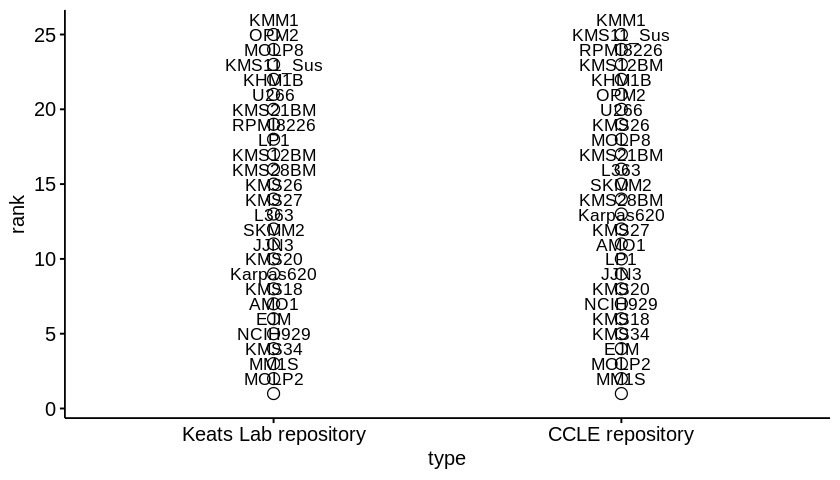

In [54]:
ccle_bool = colnames(MM.cor.ccle_5000) %in% colnames(MM.cor.keats_5000)
keats_bool = colnames(MM.cor.keats_5000) %in% colnames(MM.cor.ccle_5000)
cor_ccle = MM.cor.ccle_5000[,ccle_bool]
cor_keats = MM.cor.keats_5000[,keats_bool]
# head(cor_ccle)
# head(cor_keats)

# head(cor_ccle)
# head(cor_keats)
cor_ccle = sort(colMeans(cor_ccle), decreasing = TRUE)
cor_keats = sort(colMeans(cor_keats), decreasing = TRUE)

rank_gen3 = c(1:length(cor_ccle))

cor_ccle = as.data.frame(cor_ccle)
cor_ccle$rank = rank_gen3
cor_ccle$type = 'CCLE repository'
head(cor_ccle)
cor_ccle = cor_ccle[-1]
cor_ccle$names = row.names(cor_ccle)
# df <-data_frame[order(data_frame$c1),]
cor_ccle = cor_ccle[order(cor_ccle$names),]
head(cor_ccle)
cor_keats = as.data.frame(cor_keats)
cor_keats$rank = rank_gen3
cor_keats$type = 'Keats Lab repository'
head(cor_keats)
cor_keats = cor_keats[-1]
cor_keats$names = row.names(cor_keats)
cor_keats = cor_keats[order(cor_keats$names),]
head(cor_keats)

repo_bound = rbind(cor_keats, cor_ccle)
head(repo_bound)
tail(repo_bound)
row.names(repo_bound)
# repo_bound$names = row.names(repo_bound)
ggdotplot(repo_bound, x = 'type', y = 'rank', label = 'names')
# ggscatter(repo_bound, x = 'anbl_counts', y = 'pat', label = 'gene_names', 
#          label.select = sig_up_banbl2, xlab = 'ANBL6 Gene Counts', ylab = 'Patient Gene Counts (Best Correlated)')

ALMC1     ALMC2     AMO1      ANBL6     COLO677   Delta47  
ENSG00000000003  5.121115  4.830701  6.753159  5.087762  4.830701  4.830701
ENSG00000000419 11.192958 11.058860 11.481792 11.894072 10.306507 10.979705
ENSG00000000457  9.936576  9.672406 10.518177  9.901600  9.772317  9.566903
ENSG00000000460 10.840491  9.650001 10.386322 10.898915 10.791701  9.882322
ENSG00000000938  4.830701  5.715836  8.861104  5.236351  5.110011  5.299783
ENSG00000000971  5.506729  7.282633  5.824017  5.653577  5.658535  5.491225
                DP6       EJM       FLAM76    FR4       ⋯ RPMI8226  SKMM1    
ENSG00000000003  5.122115  6.930293  5.303622  4.830701 ⋯  5.183315  4.830701
ENSG00000000419 11.075250 11.003090 10.138017 11.723434 ⋯ 11.203237 10.090880
ENSG00000000457  9.781765  9.028327  9.709607 10.338227 ⋯  9.284631  9.782236
ENSG00000000460 11.077974 10.424602 10.251060 10.602664 ⋯ 10.359418 10.360492
ENSG00000000938  6.654161  5.316598  5.165852 11.191736 ⋯  4.830701  7.279769
ENSG00000000971  8.827028  5.664625  6.050852  5.213020 ⋯  7.226316  5.705353
                SKMM2     U266      UTMC2     VP6       XG1       XG2      
ENSG00000000003  4.830701  4.830701  4.830701  4.830701  4.830701  4.830701
ENSG00000000419 11.337907 10.916534 10.580120 11.126976 11.934854 11.032084
ENSG00000000457  8.783722 10.035066  9.673136  9.484374  9.654509  8.863879
ENSG00000000460 10.104075 10.378362 10.589037  9.883744 10.433379 10.133464
ENSG00000000938  9.363245  6.271504  9.895878 10.190136  9.735164  5.239458
ENSG00000000971  6.555933  5.130448  7.075538  5.971329  6.803862  8.441138
                XG6       XG7      
ENSG00000000003  5.118442  6.661173
ENSG00000000419 12.378849 12.643881
ENSG00000000457  9.861965  9.674925
ENSG00000000460  8.981951  8.534477
ENSG00000000938 11.103832  8.793222
ENSG00000000971  7.936526  7.174217

rank type            names    
AMO1      10   CCLE repository AMO1     
EJM        3   CCLE repository EJM      
JJN3       8   CCLE repository JJN3     
Karpas620 12   CCLE repository Karpas620
KHM1B     21   CCLE repository KHM1B    
KMM1      25   CCLE repository KMM1

rank type                 names    
AMO1       6   Keats Lab repository AMO1     
EJM        5   Keats Lab repository EJM      
JJN3      10   Keats Lab repository JJN3     
Karpas620  8   Keats Lab repository Karpas620
KHM1B     21   Keats Lab repository KHM1B    
KMM1      25   Keats Lab repository KMM1

rank names    
AMO1       6   AMO1     
EJM        5   EJM      
JJN3      10   JJN3     
Karpas620  8   Karpas620
KHM1B     21   KHM1B    
KMM1      25   KMM1

rank type                 names     rank type            names    
AMO1       6   Keats Lab repository AMO1      10   CCLE repository AMO1     
EJM        5   Keats Lab repository EJM        3   CCLE repository EJM      
JJN3      10   Keats Lab repository JJN3       8   CCLE repository JJN3     
Karpas620  8   Keats Lab repository Karpas620 12   CCLE repository Karpas620
KHM1B     21   Keats Lab repository KHM1B     21   CCLE repository KHM1B    
KMM1      25   Keats Lab repository KMM1      25   CCLE repository KMM1

[1] 10  3  8 12 21 25

Keats CCLE
AMO1       6    10  
EJM        5     3  
JJN3      10     8  
Karpas620  8    12  
KHM1B     21    21  
KMM1      25    25

Keats CCLE
MOLP2   1      2  
MM1S    2      1  
KMS34   3      4  
NCIH929 4      6  
EJM     5      3  
AMO1    6     10

Keats CCLE
MOLP2   1      2  
MM1S    2      1  
KMS34   3      4  
NCIH929 4      6  
EJM     5      3  
AMO1    6     10

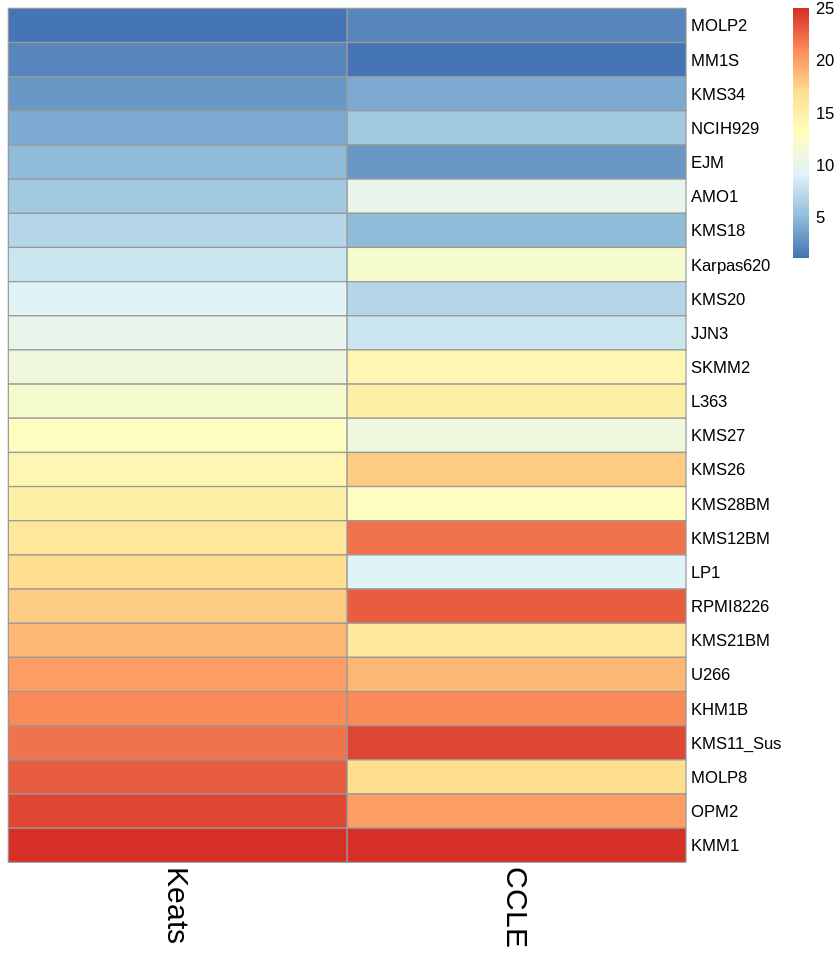

In [58]:
head(norm_cell)
head(cor_ccle)
head(cor_keats)
head(cor_keats[-2])
head(cbind(cor_keats, cor_ccle))
hm_4_rank = (cbind(cor_keats, cor_ccle))
hm_4_rank = hm_4_rank[-2]
hm_4_rank = hm_4_rank[-2]
hm_4_rank = hm_4_rank[-3]
hm_4_rank = hm_4_rank[-3]
colnames(hm_4_rank) = c('Keats', 'CCLE')
# hm_4_rank = hm_4_rank[,order(hm_4_rank$CCLE)]
head(hm_4_rank$CCLE)
head(hm_4_rank)
head(hm_4_rank[order(hm_4_rank$Keats),])
hm_4_rank = hm_4_rank[order(hm_4_rank$Keats),]
head(hm_4_rank)
# cor_keats = cor_keats[order(cor_keats$names)]
# library(RColorBrewer)

options(repr.plot.height = 8)

pheatmap(hm_4_rank, cluster_rows = FALSE, cluster_cols = FALSE, fontsize_col = 18)#, 
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(100))

In [ ]:
cor_414 = MM.cor.keats_5000[,cell_names_414]
head(cor_414)

cor_414_carrier = cor_414[keepc414,]
head(cor_414_carrier)

cor_414_opat = cor_414[!keepc414,]
head(cor_414_opat)

cor_414_carrier = colMeans(cor_414_carrier)
head(cor_414_carrier)

cor_414_opat = colMeans(cor_414_opat)
head(cor_414_opat)

cor_414_carrier = as.data.frame(cor_414_carrier)
cor_414_carrier$type = 'With'
cor_414_opat = as.data.frame(cor_414_opat)
cor_414_opat$type = 'W/O'

head(cor_414_carrier)
head(cor_414_opat)

colnames(cor_414_carrier) = c('cor', 'type')
colnames(cor_414_opat) = c('cor', 'type')
head(cor_414_carrier)
head(cor_414_opat)

cor_414_bound = rbind(cor_414_carrier, cor_414_opat)
head(cor_414_bound)

ggpaired(cor_414_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_1114 = MM.cor.keats_5000[,cell_names_1114]

cor_1114_carrier = cor_1114[keepc1114,]
cor_1114_opat = cor_1114[!keepc1114,]

cor_1114_carrier = colMeans(cor_1114_carrier)
cor_1114_opat = colMeans(cor_1114_opat)

cor_1114_carrier = as.data.frame(cor_1114_carrier)
cor_1114_carrier$type = 'With'
cor_1114_opat = as.data.frame(cor_1114_opat)
cor_1114_opat$type = 'W/O'

colnames(cor_1114_carrier) = c('cor', 'type')
colnames(cor_1114_opat) = c('cor', 'type')

cor_1114_bound = rbind(cor_1114_carrier, cor_1114_opat)

ggpaired(cor_1114_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_1416 = MM.cor.keats_5000[,cell_names_1416]

cor_1416_carrier = cor_1416[keepc1416,]
cor_1416_opat = cor_1416[!keepc1416,]

cor_1416_carrier = colMeans(cor_1416_carrier)
cor_1416_opat = colMeans(cor_1416_opat)

cor_1416_carrier = as.data.frame(cor_1416_carrier)
cor_1416_carrier$type = 'With'
cor_1416_opat = as.data.frame(cor_1416_opat)
cor_1416_opat$type = 'W/O'

colnames(cor_1416_carrier) = c('cor', 'type')
colnames(cor_1416_opat) = c('cor', 'type')

cor_1416_bound = rbind(cor_1416_carrier, cor_1416_opat)

ggpaired(cor_1416_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_1420 = MM.cor.keats_5000[,cell_names_1420]

cor_1420_carrier = cor_1420[keepc1420,]
cor_1420_opat = cor_1420[!keepc1420,]

cor_1420_carrier = colMeans(cor_1420_carrier)
cor_1420_opat = colMeans(cor_1420_opat)

cor_1420_carrier = as.data.frame(cor_1420_carrier)
cor_1420_carrier$type = 'Patients with Translocation'
cor_1420_opat = as.data.frame(cor_1420_opat)
cor_1420_opat$type = 'Patients without Translocation'

colnames(cor_1420_carrier) = c('cor', 'type')
colnames(cor_1420_opat) = c('cor', 'type')

cor_1420_bound = rbind(cor_1420_carrier, cor_1420_opat)

ggpaired(cor_1420_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cell_names_KRAS = c('COLO677', 'JIM3', 'JK6L', 
                    'JMW1', 'Karpas620', 'KHM1B', 
                    'KMS20', 'KMS28BM', 'KMS28PE', 
                    'KP6', 'MM1R', 'MM1S', 'OCIMY1', 
                    'RPMI8226', 'XG2', 'XG6', 'XG7')

cell_names_KRAS2 = c('AMO1', 'COLO677', 'FR4', 'H1112',
                      'JIM3', 'JK6L', 'JMW1', 'Karpas620',
                      'KHM1B', 'KMS20', 'KMS28BM', 'KMS28PE',
                      'KP6', 'MM1R', 'MM1S', 'MOLP8', 'OCIMY1',
                      'RPMI8226', 'XG2', 'XG6', 'XG7')

cell_names_NRAS = c('Karpas417', 'Karpas929', 'KHM11', 
                    'KMM1', 'KMS21BM', 'KMS27', 
                    'L363', 'MOLP8', 'NCIH929', 
                    'OCIMY7', 'OH2', 'PE2', 'XG1')

cell_names_NRAS2 = c('JK6L', 'Karpas417', 'Karpas929', 'KHM11',
                      'KMM1', 'KMS21BM', 'KMS27', 'L363',
                      'MOLP8', 'NCIH929', 'OCIMY7', 'OH2',
                      'PE2', 'XG1')



cell_names_BRAF = c('DP6', 'U266')

cell_names_DIS3 = c('Karpas620', 'KMM1', 'KMS26',
                    'KMS27', 'OPM1', 'OPM2', 'PCM6', 'PE2')

cell_names_FAM46C = c('ALMC1', 'INA6', 'JK6L', 'MM1R', 'MM1S', 
                      'MOLP8', 'NCIH929', 'OPM2', 'SKMM1', 'XG7')

In [ ]:
cor_KRAS = MM.cor.keats_5000[,cell_names_KRAS]

cor_KRAS_carrier = cor_KRAS[keepcKRAS,]
cor_KRAS_opat = cor_KRAS[!keepcKRAS,]

cor_KRAS_carrier = colMeans(cor_KRAS_carrier)
cor_KRAS_opat = colMeans(cor_KRAS_opat)

cor_KRAS_carrier = as.data.frame(cor_KRAS_carrier)
cor_KRAS_carrier$type = 'With'
cor_KRAS_opat = as.data.frame(cor_KRAS_opat)
cor_KRAS_opat$type = 'W/O'

colnames(cor_KRAS_carrier) = c('cor', 'type')
colnames(cor_KRAS_opat) = c('cor', 'type')

cor_KRAS_bound = rbind(cor_KRAS_carrier, cor_KRAS_opat)

ggpaired(cor_KRAS_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
# # cor_KRAS2 = MM.cor.keats_5000[,cell_names_KRAS2]
# head(MM.cor.keats_5000)
# length(MM.cor.keats_5000[1,])
# length(MM.cor.keats_5000[,1])
# head(cell_names_KRAS2)

# cell_KRAS2_bool = colnames(MM.cor.keats_5000) %in% cell_names_KRAS2

In [ ]:
cor_KRAS2 = MM.cor.keats_5000[,cell_names_KRAS2]

cor_KRAS2_carrier = cor_KRAS2[keepcKRAS2,]
cor_KRAS2_opat = cor_KRAS2[!keepcKRAS2,]

cor_KRAS2_carrier = colMeans(cor_KRAS2_carrier)
cor_KRAS2_opat = colMeans(cor_KRAS2_opat)

cor_KRAS2_carrier = as.data.frame(cor_KRAS2_carrier)
cor_KRAS2_carrier$type = 'With'
cor_KRAS2_opat = as.data.frame(cor_KRAS2_opat)
cor_KRAS2_opat$type = 'W/O'

colnames(cor_KRAS2_carrier) = c('cor', 'type')
colnames(cor_KRAS2_opat) = c('cor', 'type')

cor_KRAS2_bound = rbind(cor_KRAS2_carrier, cor_KRAS2_opat)

ggpaired(cor_KRAS2_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_NRAS = MM.cor.keats_5000[,cell_names_NRAS]

cor_NRAS_carrier = cor_NRAS[keepcNRAS,]
cor_NRAS_opat = cor_NRAS[!keepcNRAS,]

cor_NRAS_carrier = colMeans(cor_NRAS_carrier)
cor_NRAS_opat = colMeans(cor_NRAS_opat)

cor_NRAS_carrier = as.data.frame(cor_NRAS_carrier)
cor_NRAS_carrier$type = 'With'
cor_NRAS_opat = as.data.frame(cor_NRAS_opat)
cor_NRAS_opat$type = 'W/O'

colnames(cor_NRAS_carrier) = c('cor', 'type')
colnames(cor_NRAS_opat) = c('cor', 'type')

cor_NRAS_bound = rbind(cor_NRAS_carrier, cor_NRAS_opat)

ggpaired(cor_NRAS_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_414_bound$Subtype = 't(4;14)'
# head(cor_414_bound)
cor_1114_bound$Subtype = 't(11;14)'
cor_1416_bound$Subtype = 't(14;16)'
cor_KRAS_bound$Subtype = 'KRAS'
cor_NRAS_bound$Subtype = 'NRAS'
# cor_DIS3_bound$Subtype = 'DIS3'

In [ ]:
# cor_b_final = rbind(cor_DIS3_bound, cor_NRAS_bound)
# cor_b_final = rbind(cor_b_final, cor_KRAS_bound)
# cor_b_final = rbind(cor_b_final, cor_1416_bound)
# cor_b_final = rbind(cor_b_final, cor_1114_bound)
# cor_b_final = rbind(cor_b_final, cor_414_bound)

cor_b_final = rbind(cor_414_bound, cor_1114_bound)
cor_b_final = rbind(cor_b_final, cor_1416_bound)
cor_b_final = rbind(cor_b_final, cor_KRAS_bound)
cor_b_final = rbind(cor_b_final, cor_NRAS_bound)
# cor_b_final = rbind(cor_b_final, cor_DIS3_bound)

In [ ]:
p = ggpaired(cor_b_final, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco", ylab = "R", xlab = "FALSE", legend = 'FALSE')+#, facet.by = "Subtype")+
  stat_compare_means(paired = TRUE)

In [ ]:
library(repr)
options(repr.plot.width = 10)

In [ ]:
# pdf('bplots.pdf')
facet(p, facet.by = "Subtype", nrow = 1, scales = 'free_x',
     panel.labs.font = list(face = NULL, color = NULL, size = 21, angle = NULL))
# dev.off()

In [ ]:
options(repr.plot.width = 10)
options(repr.plot.height = 3.75)

In [ ]:
# cor_b_final2 = rbind(cor_KRAS_bound, cor_NRAS_bound)
# ggpaired(cor_b_final2, x = "type", y = "cor",
#          color = "type", line.color = "gray", line.size = 0.0,
#          palette = "jco", facet.by = "Subtype")+
#   stat_compare_means(paired = TRUE)

In [ ]:
cor_NRAS2 = MM.cor.keats_5000[,cell_names_NRAS2]

cor_NRAS2_carrier = cor_NRAS2[keepcNRAS2,]
cor_NRAS2_opat = cor_NRAS2[!keepcNRAS2,]

cor_NRAS2_carrier = colMeans(cor_NRAS2_carrier)
cor_NRAS2_opat = colMeans(cor_NRAS2_opat)

cor_NRAS2_carrier = as.data.frame(cor_NRAS2_carrier)
cor_NRAS2_carrier$type = 'Patients with Mutation'
cor_NRAS2_opat = as.data.frame(cor_NRAS2_opat)
cor_NRAS2_opat$type = 'Patients without Mutation'

colnames(cor_NRAS2_carrier) = c('cor', 'type')
colnames(cor_NRAS2_opat) = c('cor', 'type')

cor_NRAS2_bound = rbind(cor_NRAS2_carrier, cor_NRAS2_opat)

ggpaired(cor_NRAS2_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_BRAF = MM.cor.keats_5000[,cell_names_BRAF]

cor_BRAF_carrier = cor_BRAF[keepcBRAF,]
cor_BRAF_opat = cor_BRAF[!keepcBRAF,]

cor_BRAF_carrier = colMeans(cor_BRAF_carrier)
cor_BRAF_opat = colMeans(cor_BRAF_opat)

cor_BRAF_carrier = as.data.frame(cor_BRAF_carrier)
cor_BRAF_carrier$type = 'Patients with Mutation'
cor_BRAF_opat = as.data.frame(cor_BRAF_opat)
cor_BRAF_opat$type = 'Patients without Mutation'

colnames(cor_BRAF_carrier) = c('cor', 'type')
colnames(cor_BRAF_opat) = c('cor', 'type')

cor_BRAF_bound = rbind(cor_BRAF_carrier, cor_BRAF_opat)

ggpaired(cor_BRAF_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_BRAF2 = MM.cor.keats_5000[,cell_names_BRAF]

cor_BRAF2_carrier = cor_BRAF2[keepcBRAF2,]
cor_BRAF2_opat = cor_BRAF2[!keepcBRAF2,]

cor_BRAF2_carrier = colMeans(cor_BRAF2_carrier)
cor_BRAF2_opat = colMeans(cor_BRAF2_opat)

cor_BRAF2_carrier = as.data.frame(cor_BRAF2_carrier)
cor_BRAF2_carrier$type = 'Patients with Mutation'
cor_BRAF2_opat = as.data.frame(cor_BRAF2_opat)
cor_BRAF2_opat$type = 'Patients without Mutation'

colnames(cor_BRAF2_carrier) = c('cor', 'type')
colnames(cor_BRAF2_opat) = c('cor', 'type')

cor_BRAF2_bound = rbind(cor_BRAF2_carrier, cor_BRAF2_opat)

ggpaired(cor_BRAF2_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_DIS3 = MM.cor.keats_5000[,cell_names_DIS3]

cor_DIS3_carrier = cor_DIS3[keepcDIS3,]
cor_DIS3_opat = cor_DIS3[!keepcDIS3,]

cor_DIS3_carrier = colMeans(cor_DIS3_carrier)
cor_DIS3_opat = colMeans(cor_DIS3_opat)

cor_DIS3_carrier = as.data.frame(cor_DIS3_carrier)
cor_DIS3_carrier$type = 'With'
cor_DIS3_opat = as.data.frame(cor_DIS3_opat)
cor_DIS3_opat$type = 'W/O'

colnames(cor_DIS3_carrier) = c('cor', 'type')
colnames(cor_DIS3_opat) = c('cor', 'type')

cor_DIS3_bound = rbind(cor_DIS3_carrier, cor_DIS3_opat)

ggpaired(cor_DIS3_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
cor_FAM46C = MM.cor.keats_5000[,cell_names_FAM46C]

cor_FAM46C_carrier = cor_FAM46C[keepcFAM46C,]
cor_FAM46C_opat = cor_FAM46C[!keepcFAM46C,]

cor_FAM46C_carrier = colMeans(cor_FAM46C_carrier)
cor_FAM46C_opat = colMeans(cor_FAM46C_opat)

cor_FAM46C_carrier = as.data.frame(cor_FAM46C_carrier)
cor_FAM46C_carrier$type = 'Patients with Mutation'
cor_FAM46C_opat = as.data.frame(cor_FAM46C_opat)
cor_FAM46C_opat$type = 'Patients without Mutation'

colnames(cor_FAM46C_carrier) = c('cor', 'type')
colnames(cor_FAM46C_opat) = c('cor', 'type')

cor_FAM46C_bound = rbind(cor_FAM46C_carrier, cor_FAM46C_opat)

ggpaired(cor_FAM46C_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
head(cor_FAM46C_carrier)# = colMeans(cor_FAM46C_carrier)
head(cor_FAM46C_opat)# = colMeans(cor_FAM46C_opat)
mean(cor_FAM46C_opat$cor) - mean(cor_FAM46C_carrier$cor)

In [ ]:
cell_names_il6 = c('ALMC1','ALMC2','ANBL6','DP6','INA6','JK6L','JMW1','KAS61'
,'KP6','OH2','PCM6','PE1','PE2','VP6','XG1','XG2','XG6'
,'XG7')


il6_bool = colnames(MM_cell_line) %in% cell_names_il6

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dep'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Ind'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)
options(repr.plot.width = 3, repr.plot.height = 4)

p <- ggboxplot(cor_il6_bound, x = "type", y = "cor", fontsize = 14,
          color = "type", palette = "jco",
          add = "jitter", ylab = 'R', xlab = FALSE, legend = 'FALSE')
p + stat_compare_means(label.y = 0.6)

In [ ]:
combined_annot = data.frame(colnames(norm_combined))
head(combined_annot)

combined_annot$type = "Patient"
combined_annot$type[1:ncol(norm_cell)] = "Cell_Line"
tail(combined_annot)
rn = combined_annot[,1]
combined_annot = combined_annot[-1]
rownames(combined_annot) = rn


set = newSeqExpressionSet(as.matrix(norm_combined), 
                          phenoData = combined_annot)


x <- as.factor(combined_annot$type)
design <- model.matrix(~x, data=pData(set))
y <- DGEList(counts=counts(set), group=x)
y <- calcNormFactors(y, method="upperquartile")
y <- estimateGLMCommonDisp(y, design)
y <- estimateGLMTagwiseDisp(y, design)
fit <- glmFit(y, design)
lrt <- glmLRT(fit, coef=2)
top <- topTags(lrt, n=nrow(set))$table
head(top)

In [ ]:
gene_ranks = top[,'logFC']
head(gene_ranks)

In [ ]:
gene_info = as.data.frame(gene_info)
rownames(gene_info) = gene_info$ensembl_ids
head(gene_info)
gene_info$ensembl_ids = NULL
head(gene_info)

In [ ]:
gr_symb = gene_info[rownames(top),]
names(gene_ranks) = gr_symb
hmgs = gmtPathways('h.all.v6.2.symbols_2.gmt')

In [ ]:
fgseaRes <- fgsea(pathways = hmgs, 
                  stats = gene_ranks,
                  nperm=10000)

In [ ]:
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=50), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=50), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(hmgs[topPathways], gene_ranks, fgseaRes, 
              gseaParam = 0.5)

In [ ]:
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=10), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=10), pathway]
# topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(hmgs[topPathwaysUp], gene_ranks, fgseaRes, 
              gseaParam = 0.5)
plotGseaTable(hmgs[topPathwaysDown], gene_ranks, fgseaRes, 
              gseaParam = 0.5)
# plotGseaTable(hmgs[topPathways], gene_ranks, fgseaRes, 
#               gseaParam = 0.5)

In [ ]:
top_bool = top$PValue < 0.05
top_pcut = top[top_bool,]
gr_symb2 = gene_info[rownames(top_pcut),]
gr_symb3 = gene_info[rownames(top),]
top_pcut_upbool = top_pcut$logFC > 0
top_pcut_dobool = !top_pcut_upbool
top_pcut_up = top_pcut[top_pcut_upbool,]
top_pcut_do = top_pcut[top_pcut_dobool,]
gr_symb_up = gene_info[rownames(top_pcut_up),]
gr_symb_do = gene_info[rownames(top_pcut_do),]

In [ ]:
head(MM.cor.keats_5000)
anbl.cor = sort(MM.cor.keats_5000[,'ANBL6'], decreasing = TRUE)
head(anbl.cor[1])

In [ ]:
best_pat_anbl_counts = norm_pat[,'MMRF_2739_1_BM']
# head(best_pat_anbl)

In [ ]:
anbl_counts = norm_cell[,'ANBL6']

In [ ]:
best_anbl_sc = as.data.frame(anbl_counts)
# head(anbl_counts)
best_anbl_sc$pat = best_pat_anbl_counts
head(best_anbl_sc)

In [ ]:
head(gene_info)
gn_sct = rownames(gene_info) %in% rownames(best_anbl_sc)
# gn_sct_alt = rownames(best_anbl_sc) %in% rownames(gene_info)
head(gn_sct)
gn_sct_n = gene_info[gn_sct,]
head(gn_sct_n)
best_anbl_sc$gene_names = gn_sct_n
head(best_anbl_sc)
sig_up_banbl = best_anbl_sc$pat > 18
head(sig_up_banbl)
sum(sig_up_banbl)
sig_up_banbl2 = as.vector(best_anbl_sc[sig_up_banbl,]$gene_names)

In [ ]:
ggscatter(best_anbl_sc, x = 'anbl_counts', y = 'pat', label = 'gene_names', 
         label.select = sig_up_banbl2, xlab = 'ANBL6 Gene Counts', ylab = 'Patient Gene Counts (Best Correlated)')

In [ ]:
head(MM_pat_mut)
length(unique(MM_pat_mut$GENE))
mut2 = filter(MM_pat_mut, EFFECT %in% c("missense_variant",
                                         "frameshift_variant",
                                         "stop_gained",
                                         "start_lost",
                                         "stop_lost",
                                         "missense_variant&splice_region_variant",
                                         "frameshift_variant&splice_region_variant",
                                         "disruptive_inframe_deletion",
                                         "stop_gained&splice_region_variant",
                                         "frameshift_variant&stop_gained",
                                         "frameshift_variant&splice_acceptor_variant&splice_region_variant&intron_variant",
                                         "frameshift_variant&splice_donor_variant&splice_region_variant&intron_variant",
                                         "splice_donor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&splice_region_variant",
                                         "disruptive_inframe_insertion",
                                         "stop_gained&disruptive_inframe_deletion",
                                         "frameshift_variant&start_lost",
                                         "stop_gained&disruptive_inframe_insertion",
                                         "disruptive_inframe_deletion&splice_region_variant",
                                         "disruptive_inframe_insertion&splice_region_variant",
                                         "start_lost&splice_region_variant",
                                         "start_lost&inframe_deletion",
                                         "frameshift_variant&stop_lost",
                                         "splice_acceptor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&inframe_deletion")) %>%
   filter(str_extract(sample, "_[0-9]_") == "_1_")

length(unique(mut2$sample))
head(mut2)

In [ ]:
length(unique(mut2$GENE))

In [ ]:
length(unique(mut2$GENE))
length(colnames(norm_pat))
mut3 = as.data.frame(mut2$sample)
# #mut3$Effect = mut2$EFFECT
mut3$GENE = as.vector(mut2$GENE)
colnames(mut3) = c('sample', 'GENE')
# head(mut3)
# # test = 0
dftest = as.data.frame(matrix(0, ncol=15039, nrow=945))
colnames(dftest) = as.vector(unique(mut2$GENE))
rownames(dftest) = as.vector(unique(mut2$sample))
# # tail(dftest)
# # x = mut3[1,]
# # x$GENE
# m = as.data.frame(c())
# x = 's'
# y = 's'

# # test
# # length(mut3[,1])
# # tail(colnames(norm_pat))

In [ ]:
for (row in 1:length(mut3[,1])){
    m = mut3[1,]
    mut3 = mut3[-1,]
    x = as.character(m[1,1])
    y = as.character(m[1,2])#as.character(x$sample)
#     z = x$GENE
    dftest[x, y] = dftest[x, y] + 1
}
head(dftest)

In [ ]:
dftest['MMRF_2853_1_BM', 'SON']

In [ ]:
c_mean_exp_pat = colMeans(dftest)

c_mean_exp_pat_sorted = sort(c_mean_exp_pat, decreasing = TRUE)
c_mean_exp_pat_sorted[1:30]

In [ ]:
mut3 = as.data.frame(mut2$sample)
# #mut3$Effect = mut2$EFFECT
mut3$GENE = as.vector(mut2$GENE)
colnames(mut3) = c('sample', 'GENE')
# head(mut3)
# # test = 0
dftest = as.data.frame(matrix(0, ncol=15039, nrow=945))
colnames(dftest) = as.vector(unique(mut2$GENE))
rownames(dftest) = as.vector(unique(mut2$sample))

for (row in 1:length(mut3[,1])){
    m = mut3[1,]
    mut3 = mut3[-1,]
    x = as.character(m[1,1])
    y = as.character(m[1,2])#as.character(x$sample)
#     z = x$GENE
    dftest[x, y] = 1
}
head(dftest)

In [ ]:
c_n_mut_pat = colSums(dftest)
c_n_mut_pat_sorted = sort(c_n_mut_pat, decreasing = TRUE)
c_n_mut_pat_perc = (c_n_mut_pat_sorted/945)*100

In [ ]:
c_n_mut_pat_perc[1:30]
length(c_n_mut_pat)

In [ ]:
MM_cell_mut = data.frame(fread("HMCL69_Predicted_Mutations_Samtools (1).csv"))
head(MM_cell_mut)
unique(MM_cell_mut$SNPEFF_EFFECT)
unique(MM_cell_mut$SNPEFF_FUNCTIONAL_CLASS)
length(unique(MM_cell_mut$Sample))
length(unique(MM_cell_mut$SNPEFF_GENE_NAME))

In [ ]:
dftest2 = as.data.frame(matrix(0, ncol=9004, nrow=68))
colnames(dftest2) = as.vector(unique(MM_cell_mut$SNPEFF_GENE_NAME))
rownames(dftest2) = as.vector(unique(MM_cell_mut$Sample))
# # tail(dftest)
for (row in 1:length(MM_cell_mut[,1])){
    m = MM_cell_mut[1,]
    MM_cell_mut = MM_cell_mut[-1,]
    x = as.character(m$Sample)
    y = as.character(m$SNPEFF_GENE_NAME)#as.character(x$sample)
#     z = x$GENE
    dftest2[x, y] = 1
}
head(dftest2)

In [ ]:
c_n_mut_cell = colSums(dftest2)
c_n_mut_cell_sorted = sort(c_n_mut_cell, decreasing = TRUE)
c_n_mut_cell_perc = (c_n_mut_cell_sorted/68)*100
c_n_mut_cell_perc[1:30]
length(c_n_mut_cell)

In [ ]:
head(names(c_n_mut_cell_perc))

cp_bool = names(c_n_mut_cell_perc) %in% names(c_n_mut_pat_perc)
pp_bool = names(c_n_mut_pat_perc) %in% names(c_n_mut_cell_perc)

cp = c_n_mut_cell_perc[cp_bool]
pp = c_n_mut_pat_perc[pp_bool]

topcp = cp[1:30]
topcp_pp = pp[names(cp[1:30])]

toppp = pp[1:30]
toppp_cp = cp[names(pp[1:30])]

topcp_bound = cbind(topcp, topcp_pp)
colnames(topcp_bound) = c('Cell Lines', 'Patients')
toppp_bound = cbind(toppp, toppp_cp)
colnames(toppp_bound) = c('Patients', 'Cell Lines')

head(topcp_bound)
head(toppp_bound)
options(repr.plot.height = 7, repr.plot.width = 7)
pheatmap(topcp_bound, cluster_rows = FALSE, cluster_cols = FALSE)
pheatmap(toppp_bound, cluster_rows = FALSE, cluster_cols = FALSE)

In [ ]:
anbl.cor[length(anbl.cor)]
worst_pat_anbl_counts = norm_pat[,'MMRF_1537_1_BM']
worst_anbl_sc = as.data.frame(anbl_counts)
# head(anbl_counts)
worst_anbl_sc$pat = worst_pat_anbl_counts
head(worst_anbl_sc)

In [ ]:
head(gene_info)
gn_sct = rownames(gene_info) %in% rownames(worst_anbl_sc)
# gn_sct_alt = rownames(best_anbl_sc) %in% rownames(gene_info)
head(gn_sct)
gn_sct_n = gene_info[gn_sct,]
#head(gn_sct_n)
worst_anbl_sc$gene_names = gn_sct_n
head(worst_anbl_sc)
sig_up_wanbl = worst_anbl_sc$pat > 18
head(sig_up_wanbl)
sum(sig_up_wanbl)
sig_up_wanbl2 = as.vector(worst_anbl_sc[sig_up_wanbl,]$gene_names)

In [ ]:
ggscatter(worst_anbl_sc, x = 'anbl_counts', y = 'pat', label = 'gene_names', 
         label.select = sig_up_wanbl2, xlab = 'ANBL6 Gene Counts', ylab = 'Patient Gene Counts (Worst Correlated)')
# ggscatter(worst_anbl_sc, x = 'anbl_counts', y = 'pat')

In [ ]:
head(MM.cor.keats_5000)

In [ ]:
fr4.cor = sort(MM.cor.keats_5000[,'FR4'], decreasing = TRUE)
head(fr4.cor[1])

In [ ]:
best_pat_fr4_counts = norm_pat[,'MMRF_2251_1_BM']
fr4_counts = norm_cell[,'FR4']
best_fr4_sc = as.data.frame(fr4_counts)
# head(anbl_counts)
best_fr4_sc$pat = best_pat_fr4_counts
# head(best_anbl_sc)
head(gene_info)
gn_sct = rownames(gene_info) %in% rownames(best_fr4_sc)
# gn_sct_alt = rownames(best_anbl_sc) %in% rownames(gene_info)
head(gn_sct)
gn_sct_n = gene_info[gn_sct,]
#head(gn_sct_n)
best_fr4_sc$gene_names = gn_sct_n
head(best_fr4_sc)
sig_up_bfr4 = best_fr4_sc$pat > 17
head(sig_up_bfr4)
sum(sig_up_bfr4)
sig_up_bfr42 = as.vector(best_fr4_sc[sig_up_bfr4,]$gene_names)

In [ ]:
sig_up_bfr42
ggscatter(best_fr4_sc, x = 'fr4_counts', y = 'pat', label = 'gene_names', 
         label.select = sig_up_bfr42, xlab = 'FR4 Gene Counts', ylab = 'Patient Gene Counts (Best Correlated)')
# ggscatter(best_fr4_sc, x = 'fr4_counts', y = 'pat')

In [ ]:
fr4.cor = sort(MM.cor.keats_5000[,'FR4'])#, decreasing = TRUE)
head(fr4.cor[1])

In [ ]:
# best_pat_fr4_counts = norm_pat[,'MMRF_2251_1_BM']
# fr4_counts = norm_cell[,'FR4']
# best_fr4_sc = as.data.frame(fr4_counts)
# # head(anbl_counts)
# best_fr4_sc$pat = best_pat_fr4_counts
# # head(best_anbl_sc)
# head(gene_info)
# gn_sct = rownames(gene_info) %in% rownames(best_fr4_sc)
# # gn_sct_alt = rownames(best_anbl_sc) %in% rownames(gene_info)
# head(gn_sct)
# gn_sct_n = gene_info[gn_sct,]
# #head(gn_sct_n)
# best_fr4_sc$gene_names = gn_sct_n
# head(best_fr4_sc)
# sig_up_bfr4 = best_fr4_sc$pat > 17
# head(sig_up_bfr4)
# sum(sig_up_bfr4)
# sig_up_bfr42 = as.vector(best_fr4_sc[sig_up_bfr4,]$gene_names)



worst_pat_fr4_counts = norm_pat[,'MMRF_2291_1_BM']
fr4_counts = norm_cell[,'FR4']
worst_fr4_sc = as.data.frame(fr4_counts)
# head(anbl_counts)
worst_fr4_sc$pat = worst_pat_fr4_counts
# head(best_anbl_sc)
gn_sct = rownames(gene_info) %in% rownames(worst_fr4_sc)
gn_sct_n = gene_info[gn_sct,]
worst_fr4_sc$gene_names = gn_sct_n
sig_up_wfr4 = worst_fr4_sc$pat > 18
sig_up_wfr42 = as.vector(worst_fr4_sc[sig_up_wfr4,]$gene_names)
sig_up_wfr42
ggscatter(worst_fr4_sc, x = 'fr4_counts', y = 'pat', label = 'gene_names', 
         label.select = sig_up_wfr42, xlab = 'FR4 Gene Counts', ylab = 'Patient Gene Counts (Worst Correlated)')
# ggscatter(worst_fr4_sc, x = 'fr4_counts', y = 'pat')

In [ ]:
mmm1.cor = sort(MM.cor.keats_5000[,'MMM1'], decreasing = TRUE)
head(mmm1.cor[1])

In [ ]:
# worst_pat_fr4_counts = norm_pat[,'MMRF_2291_1_BM']
# fr4_counts = norm_cell[,'FR4']
# worst_fr4_sc = as.data.frame(fr4_counts)
# # head(anbl_counts)
# worst_fr4_sc$pat = worst_pat_fr4_counts
# # head(best_anbl_sc)
# gn_sct = rownames(gene_info) %in% rownames(worst_fr4_sc)
# gn_sct_n = gene_info[gn_sct,]
# worst_fr4_sc$gene_names = gn_sct_n
# sig_up_wfr4 = worst_fr4_sc$pat > 18
# sig_up_wfr42 = as.vector(worst_fr4_sc[sig_up_wfr4,]$gene_names)
# sig_up_wfr42
# ggscatter(worst_fr4_sc, x = 'fr4_counts', y = 'pat', label = 'gene_names', 
#          label.select = sig_up_wfr42, xlab = 'FR4 Gene Counts', ylab = 'Patient Gene Counts (Worst Correlated)')

best_pat_mmm1_counts = norm_pat[,'MMRF_2490_1_BM']
mmm1_counts = norm_cell[,'MMM1']
best_mmm1_sc = as.data.frame(mmm1_counts)
# head(anbl_counts)
best_mmm1_sc$pat = best_pat_mmm1_counts
# head(best_anbl_sc)
gn_sct = rownames(gene_info) %in% rownames(best_mmm1_sc)
gn_sct_n = gene_info[gn_sct,]
best_mmm1_sc$gene_names = gn_sct_n
sig_up_bmmm1 = best_mmm1_sc$pat > 17
sig_up_bmmm12 = as.vector(best_mmm1_sc[sig_up_bmmm1,]$gene_names)
sig_up_bmmm12
ggscatter(best_mmm1_sc, x = 'mmm1_counts', y = 'pat', label = 'gene_names', 
         label.select = sig_up_bmmm12, xlab = 'MMM1 Gene Counts', ylab = 'Patient Gene Counts (Best Correlated)')
# ggscatter(best_mmm1_sc, x = 'mmm1_counts', y = 'pat')

In [ ]:
head(best_mmm1_sc)

In [ ]:
mmm1.cor = sort(MM.cor.keats_5000[,'MMM1'])#, decreasing = TRUE)
head(mmm1.cor[1])

In [ ]:
worst_pat_mmm1_counts = norm_pat[,'MMRF_1537_1_BM']
mmm1_counts = norm_cell[,'MMM1']
worst_mmm1_sc = as.data.frame(mmm1_counts)
# head(anbl_counts)
worst_mmm1_sc$pat = worst_pat_mmm1_counts
# head(best_anbl_sc)
head(gene_info)
gn_sct = rownames(gene_info) %in% rownames(worst_mmm1_sc)
# gn_sct_alt = rownames(best_anbl_sc) %in% rownames(gene_info)
head(gn_sct)
gn_sct_n = gene_info[gn_sct,]
#head(gn_sct_n)
worst_mmm1_sc$gene_names = gn_sct_n
head(worst_mmm1_sc)
sig_up_wmmm1 = worst_mmm1_sc$pat > 18
head(sig_up_wmmm1)
sum(sig_up_wmmm1)
sig_up_wmmm12 = as.vector(worst_mmm1_sc[sig_up_wmmm1,]$gene_names)

In [ ]:
sig_up_wmmm12
ggscatter(worst_mmm1_sc, x = 'mmm1_counts', y = 'pat',# label = 'gene_names', 
#          label.select = sig_up_wmmm12, 
          xlab = 'MMM1 Gene Counts', ylab  = 'Patient Gene Counts (Best Correlated)')
# ggscatter(worst_mmm1_sc, x = 'mmm1_counts', y = 'pat')

In [ ]:
head(best_anbl_sc)
head(worst_anbl_sc)
head(best_fr4_sc)
head(worst_fr4_sc)

In [ ]:
best_anbl_sc$Subtype = 'Best Correlated Patient to ANBL6 (R = 0.77)'
worst_anbl_sc$Subtype = 'Worst Correlated Patient to ANBL6(R = 0.38)'
best_fr4_sc$Subtype = 'Best Correlated Patient to FR4 (R = 0.56)'
worst_fr4_sc$Subtype = 'Worst Correlated Patient to FR4 (R = 0.24)'


colnames(best_anbl_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
colnames(worst_anbl_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
colnames(best_fr4_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
colnames(worst_fr4_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')

# colnames(worst_anbl_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
# colnames(best_fr4_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')
# colnames(worst_fr4_sc) = c('Cell_Line_Counts', 'Patient_Counts', 'gene_names', 'Subtype')


head(best_anbl_sc)
cor_b_final2 = rbind(best_anbl_sc, worst_anbl_sc)
cor_b_final2 = rbind(cor_b_final2, best_fr4_sc)
cor_b_final2 = rbind(cor_b_final2, worst_fr4_sc)

head(cor_b_final2)

In [ ]:
tail(cor_b_final2)


# ggscatter(worst_mmm1_sc, x = 'Cell Line Counts', y = 'Patient Counts')#, label = 'gene_names', 
#          label.select = sig_up_wmmm12, 
#           xlab = 'MMM1 Gene Counts', ylab  = 'Patient Gene Counts (Best Correlated)')

p = ggscatter(cor_b_final2, x = "Cell_Line_Counts", y = "Patient_Counts", xlab = 'Cell Line Normalized TPM', 
              ylab = 'Patient Normalized TPM', size = 0.001)#, xlim = c(5,25), ylim = c(5,25))#, facet.by = 'Subtype')#,
#          color = "type", line.color = "gray", line.size = 0.4,
#          palette = "jco", ylab = "R", xlab = "FALSE", legend = 'FALSE')+#, facet.by = "Subtype")+
#   stat_compare_means(paired = TRUE)

# pdf('bplots.pdf')

options(repr.plot.height = 5)

facet(p, facet.by = "Subtype", nrow = 2, ncol = 2, 
      panel.labs.font = list(face = NULL,color = NULL, size = 11.32, angle = NULL))#, scales = 'free_x')

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7)
MM_pat_ppv = data.frame(fread("MMRF_CoMMpass_IA13_PER_PATIENT_VISIT.csv"))
length(MM_pat_ppv[,1])
MM_pat_ppv_bool = MM_pat_ppv$AT_TREATMENTRESP %in% c('Progressive Disease')
MM_pat_pd = MM_pat_ppv[MM_pat_ppv_bool,]
MM_pat_pd_id = unique(MM_pat_pd$SPECTRUM_SEQ)
MM_pat_pd_id = MM_pat_pd_id[-1]
MM_pat_pd_id = paste(MM_pat_pd_id, '_BM', sep = '')
MM_patients_2 = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))
rownames(MM_patients_2) = MM_patients_2$GENE_ID
MM_patients_2 = MM_patients_2[-1]
length(MM_cell_line[,1])
MM_pat_test = rownames(MM_patients_2) %in% rownames(MM_cell_line)
MM_patients_2 = MM_patients_2[MM_pat_test,]
MM_pat_bool_2 = (colnames(MM_patients_2) %in% MM_pat_pd_id)
MM_patients_2 = MM_patients_2[,MM_pat_bool_2]
head(MM_patients_2)
MM_combined_2 = cbind(MM_cell_line, MM_patients_2)
norm_combined_pd = vst(as.matrix(MM_combined_2))
head(norm_combined_pd)

In [ ]:
norm_combined_pd_5 = norm_combined_pd[keepi5000,]
makeplots(norm_combined_pd_5, colnames(MM_patients_2), colnames(MM_cell_line), '')

In [ ]:
MM.cor.pd = cor(norm_combined_pd_5, method = 's')

MM.cor.pd = MM.cor.pd[,colnames(MM_cell_line)]
MM.cor.pd = MM.cor.pd[colnames(MM_patients_2),]

MM.cor.pd_m = data.frame(colMeans(MM.cor.pd))
MM.cor.pd_m$type = 'Progressive Disease'
colnames(MM.cor.pd_m) = c('cor', 'type')

MM.cor.keats_ma = data.frame(colMeans(MM.cor.keats_5000))
MM.cor.keats_ma$type = 'Newly Diagnosed'
colnames(MM.cor.keats_ma) = c('cor', 'type')

head(MM.cor.pd_m)
head(MM.cor.keats_ma)

pd_bound = rbind(MM.cor.pd_m, MM.cor.keats_ma)

 ggpaired(pd_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.2,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [ ]:
MM_pat_pd_id

In [ ]:
MM_pat_pp = data.frame(fread("MMRF_CoMMpass_IA13_PER_PATIENT.csv"))

head(MM_pat_pp)

MM_pat_pp_1_bool = (MM_pat_pp$D_PT_iss %in% c(1))
MM_pat_pp_2_bool = (MM_pat_pp$D_PT_iss %in% c(2))
MM_pat_pp_3_bool = (MM_pat_pp$D_PT_iss %in% c(3))

MM_pat_pp_1 = MM_pat_pp[MM_pat_pp_1_bool, ]
MM_pat_pp_2 = MM_pat_pp[MM_pat_pp_2_bool, ]
MM_pat_pp_3 = MM_pat_pp[MM_pat_pp_3_bool, ]

head(MM_pat_pp_1)

MM_pat_pp_1.id = MM_pat_pp_1$PUBLIC_ID
MM_pat_pp_2.id = MM_pat_pp_2$PUBLIC_ID
MM_pat_pp_3.id = MM_pat_pp_3$PUBLIC_ID

head(MM_pat_pp_1.id)

MM_pat_pp_1.id = paste(MM_pat_pp_1.id, '_1_BM', sep = '')
MM_pat_pp_2.id = paste(MM_pat_pp_2.id, '_1_BM', sep = '')
MM_pat_pp_3.id = paste(MM_pat_pp_3.id, '_1_BM', sep = '')

head(MM_pat_pp_1.id)

iss_1_bool = rownames(MM.cor.keats_5000) %in% MM_pat_pp_1.id
iss_2_bool = rownames(MM.cor.keats_5000) %in% MM_pat_pp_2.id
iss_3_bool = rownames(MM.cor.keats_5000) %in% MM_pat_pp_3.id

head(iss_1_bool)
length(iss_1_bool)
sum(iss_1_bool)

head(iss_2_bool)
length(iss_2_bool)
sum(iss_2_bool)

head(iss_3_bool)
length(iss_3_bool)
sum(iss_3_bool)

iss_1 = MM.cor.keats_5000[iss_1_bool,]
iss_2 = MM.cor.keats_5000[iss_2_bool,]
iss_3 = MM.cor.keats_5000[iss_3_bool,]

# cor_FR4 = MM.cor.keats_5000[,'FR4']
# cor_oth = MM.cor.keats_5000[,-10]
# cor_oth = rowMeans(cor_oth)
# cor_FR4 = as.data.frame(cor_FR4)
# cor_FR4$type = 'Patient Correlates for FR4'
# cor_oth = as.data.frame(cor_oth)
# cor_oth$type = 'Patient Correlates for other cell lines'
# colnames(cor_FR4) = c('cor', 'type')
# colnames(cor_oth) = c('cor', 'type')
# cor_FR4_bound = rbind(cor_FR4, cor_oth)
# ggpaired(cor_FR4_bound, x = "type", y = "cor",
#          color = "type", line.color = "gray", line.size = 0.4,
#          palette = "jco")+
#   stat_compare_means(paired = TRUE)

head(MM.cor.keats_5000)
head(iss_1)
head(cor_FR4_bound)

iss_1_m = data.frame(colMeans(iss_1))
iss_1_m$type = 'ISS Stage 1'
colnames(iss_1_m) = c('cor', 'type')

iss_3_m = data.frame(colMeans(iss_3))
iss_3_m$type = 'ISS Stage 3'
colnames(iss_3_m) = c('cor', 'type')

iss_2_m = data.frame(colMeans(iss_2))
iss_2_m$type = 'ISS Stage 2'
colnames(iss_2_m) = c('cor', 'type')

head(iss_1_m)
head(iss_2_m)
head(iss_3_m)

iss_bound = rbind(iss_1_m, iss_2_m)
iss_bound = rbind(iss_bound, iss_3_m)

my_comparisons <- list( c("ISS Stage 1", "ISS Stage 2"), c("ISS Stage 2", "ISS Stage 3"), c("ISS Stage 1", "ISS Stage 3"))


 ggboxplot(iss_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.2,
         palette = "jco")+
  stat_compare_means(comparisons = my_comparisons, method = 'wilcox.test')


# iss_1_s = iss_1_m[order(-iss_1_m$cor),]
head(iss_1_m[order(-iss_1_m$cor),])
head(iss_2_m[order(-iss_2_m$cor),])
head(iss_3_m[order(-iss_3_m$cor),])

tail(iss_1_m[order(-iss_1_m$cor),])
tail(iss_2_m[order(-iss_2_m$cor),])
tail(iss_3_m[order(-iss_3_m$cor),])

# head(iss_1_m)

# newdata <- mtcars[order(mpg, -cyl),]


# head(sort(iss_1))

In [ ]:
head(MM_pat_ppv)
head(MM_pat_ppv$IC_SERUMMPROTEIN)

MM_pat_ppv_m_bool = MM_pat_ppv$IC_SERUMMPROTEIN %in% c('No')
MM_pat_ppv_m_booly = MM_pat_ppv$IC_SERUMMPROTEIN %in% c('Yes')

head(MM_pat_ppv_m_bool)
length(MM_pat_ppv_m_bool)
sum(MM_pat_ppv_m_bool)

head(MM_pat_ppv_m_booly)
length(MM_pat_ppv_m_booly)
sum(MM_pat_ppv_m_booly)

MM_pat_ppv_mpos = MM_pat_ppv[MM_pat_ppv_m_booly,]
MM_pat_ppv_mneg = MM_pat_ppv[MM_pat_ppv_m_bool,]

head(MM_pat_ppv_mpos)
head(MM_pat_ppv_mneg)

MM_pat_ppv_m.idy = unique(MM_pat_ppv_mpos$PUBLIC_ID)
MM_pat_ppv_m.idy = paste(MM_pat_ppv_m.idy, '_1_BM', sep = '')
MM_pat_ppv_m.id = unique(MM_pat_ppv_mneg$PUBLIC_ID)
MM_pat_ppv_m.id = paste(MM_pat_ppv_m.id, '_1_BM', sep = '')

head(MM_pat_ppv_m.idy)

mpos_b = rownames(MM.cor.keats_5000) %in% MM_pat_ppv_m.idy
mneg_b = rownames(MM.cor.keats_5000) %in% MM_pat_ppv_m.id

mpos = MM.cor.keats_5000[mpos_b,]
mneg = MM.cor.keats_5000[mneg_b,]

head(mpos)
length(mpos[,1])
head(mneg)
length(mneg[,1])

mpos_m = data.frame(colMeans(mpos))
mpos_m$type = 'M-protein >= 1g/dl'
colnames(mpos_m) = c('cor', 'type')

mneg_m = data.frame(colMeans(mneg))
mneg_m$type = 'M-protein < 1g/dl'
colnames(mneg_m) = c('cor', 'type')

head(mpos_m)

mbound = rbind(mpos_m, mneg_m)

 ggpaired(mbound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.2,
         palette = "jco")+
  stat_compare_means(paired = TRUE, method = '')

# iss_1_m = data.frame(colMeans(iss_1))
# iss_1_m$type = 'ISS Stage 1'
# colnames(iss_1_m) = c('cor', 'type')

# iss_3_m = data.frame(colMeans(iss_3))
# iss_3_m$type = 'ISS Stage 3'
# colnames(iss_3_m) = c('cor', 'type')

# iss_2_m = data.frame(colMeans(iss_2))
# iss_2_m$type = 'ISS Stage 2'
# colnames(iss_2_m) = c('cor', 'type')

mean(mpos_m$cor)
mean(mneg_m$cor)

In [ ]:
# cor_b_final = rbind(cor_DIS3_bound, cor_NRAS_bound)
# cor_b_final = rbind(cor_b_final, cor_KRAS_bound)
# cor_b_final = rbind(cor_b_final, cor_1416_bound)
# cor_b_final = rbind(cor_b_final, cor_1114_bound)

# # cor_b_final = rbind(cor_b_final, cor_414_bound)

# best_anbl_sc$Subtype = 'Best Correlated Patient to ANBL6 (R = 0.77)'
# worst_anbl_sc$Subtype = 'Worst Correlated Patient to ANBL6(R = 0.38)'
# best_fr4_sc$Subtype = 'Best Correlated Patient to FR4 (R = 0.56)'
# worst_fr4_sc$Subtype = 'Worst Correlated Patient to FR$ (R = 0.24)'

# cor_b_final2 = rbind(best_anblsc, worst_anbl_sc)
# cor_b_final2 = rbind(cor_b_final2, best_fr4_sc)
# cor_b_final2 = rbind(cor_b_final2, worst_fr4_sc)
# # cor_b_final = rbind(cor_b_final, cor_NRAS_bound)
# # cor_b_final = rbind(cor_b_final, cor_DIS3_bound)

# head(best_anbl_sc)
# head(worst_anbl_sc)
# head(best_mmm1_sc)
# head(worst_mmm1_sc)


# ggscatter(cor_b_, x = 'mmm1_counts', y = 'pat',# label = 'gene_names', 
# #          label.select = sig_up_wmmm12, 
#           xlab = 'MMM1 Gene Counts', ylab  = 'Patient Gene Counts (Best Correlated)')

# p = ggpaired(cor_b_final, x = "type", y = "cor",
#          color = "type", line.color = "gray", line.size = 0.4,
#          palette = "jco", ylab = "R", xlab = "FALSE", legend = 'FALSE')+#, facet.by = "Subtype")+
#   stat_compare_means(paired = TRUE)

# # pdf('bplots.pdf')
# facet(p, facet.by = "Subtype", nrow = 1, scales = 'free_x')

In [ ]:
ego <- enrichGO(gene          = gr_symb_up,
                universe      = gr_symb3,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "ALL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)
# head(summary(ego))

ego2 <- enrichGO(gene          = gr_symb_do,
                universe      = gr_symb3,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "ALL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)

In [ ]:
dotplot(ego, showCategory=10, font.size = 5)
dotplot(ego2, showCategory=10, font.size = 5)

In [ ]:
goterms = rownames(summary(ego))
head(goterms)

In [ ]:
head(goterms)

In [ ]:
# making patient annotations for heatmap

x = c()

pat_names = colnames(norm_pat)

for(pat in pat_names){
    if (pat %in% colnames(norm_pat_1114)){
        x = append(x, 't(11;14)')
    }
    else if (pat %in% colnames(norm_pat_1416)){
        x = append(x, 't(14;16)')
    }
    else if (pat %in% colnames(norm_pat_414)){
        x = append(x, 't(4;14)')
    }
    else if (pat %in% colnames(norm_pat_1420)){
        x = append(x, 't(14;20)')
    }
    else{
        x = append(x, 'Not Annotated')
    }
}

x = as.data.frame(x)
rownames(x) = colnames(norm_pat)

# subsetting top 5000 / 10000 ggenes for patient heatmap

norm_pat_hm_5000 = norm_pat[keepi5000,] 
# norm_pat_hm_10000 = norm_pat[keepi10000,] 

# generating heatmaps

pheatmap(norm_pat_hm_5000, annotation_col = x, show_rownames = FALSE, show_colnames = FALSE, main = 'Patient Heatmap - Top 5000 Genes')
# pheatmap(norm_pat_hm_10000, annotation_col = x, show_rownames = FALSE, show_colnames = FALSE, main = 'Patient Heatmap - Top 10000 Genes')

In [ ]:
cell_names = colnames(MM_cell_line)

x = c()

for(cell in cell_names){
    if (cell %in% cell_names_1114){
        x = append(x, 't(11;14)')
    }
    else if (cell %in% cell_names_1416){
        x = append(x, 't(14;16)')
    }
    else if (cell %in% cell_names_414){
        x = append(x, 't(4;14)')
    }
    else if (cell %in% cell_names_1420){
        x = append(x, 't(14;20)')
    }
    else{
        x = append(x, 'Not Annotated')
    }
}

# x = c('none', 'none', 'none', 't(14;16)', 'none', 'none', 'none', 'none', 
#       't(11;14)', 'none', 't(11;14)', 't(11;14)', 't(4;14)', 't(4;14)', 't(14;16)', 'none',
#      't(4;14)', 'none', 'none', 't(11;14)', 'none', 'none', 't(4;14)', 't(4;14)', 'none', 'none',
#      't(4;14)', 't(4;14)', 't(11;14)', 't(11;14)', 't(4;14)', 'none', 't(11;14)', 't(4;14)', 't(11;14)',
#      't(4;14)', 't(4;14)', 't(4;14)', 'none', 'none', 't(4;14)', 't(14;16)', 't(14;16)', 't(11;14)', 'none', 
#       't(11;14)', 't(4;14)', 'none', 't(14;16)', 't(11;14)', 'none', 't(4;14)', 't(4;14)', 't(14;16)',
#      't(11;14)', 't(4;14)', 'none', 'none', 't(11;14)', 't(11;14)', 't(4;14)', 't(14;16)', 't(11;14)', 'none', 
#      'none', 't(4;14)')

x = as.data.frame(x)
rownames(x) = colnames(MM_cell_line)

# subsetting top 5000 / 10000 ggenes for patient heatmap

norm_cells_hm_5000 = norm_cell[keepi5000,]
# norm_cells_hm_10000 = norm_cell[keepi10000,]

# generating heatmaps

pheatmap(norm_cells_hm_5000, annotation_col = x, show_rownames = FALSE, show_colnames = FALSE, main = 'Cell Line Heatmap - Top 5000 Genes')
# pheatmap(norm_cells_hm_10000, annotation_col = x, show_rownames = FALSE, show_colnames = FALSE, main = 'Cell Line Heatmap - Top 10000 Genes')

In [ ]:
ego_BP <- enrichGO(gene          = gr_symb_up,
                universe      = gr_symb3,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)
# head(summary(ego))

ego_MF <- enrichGO(gene          = gr_symb_up,
                universe      = gr_symb3,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)

ego_CC <- enrichGO(gene          = gr_symb_up,
                universe      = gr_symb3,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "CC",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)


ego2_BP <- enrichGO(gene          = gr_symb_do,
                universe      = gr_symb3,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)

ego2_MF <- enrichGO(gene          = gr_symb_do,
                universe      = gr_symb3,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)

ego2_CC <- enrichGO(gene          = gr_symb_do,
                universe      = gr_symb3,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "CC",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)

In [ ]:
ego_BP = simplify(ego_BP, cutoff=0.6)#, by="p.adjust", select_fun=min)
ego_MF = simplify(ego_MF, cutoff=0.6)
ego_CC = simplify(ego_CC, cutoff=0.6)
ego2_BP = simplify(ego2_BP, cutoff=0.6)
ego2_MF = simplify(ego2_MF, cutoff=0.6)
ego2_CC = simplify(ego2_CC, cutoff=0.6)


# ego3 <- enrichGO(gene          = gr_symb_up,
#                 universe      = gr_symb3,
#                 OrgDb         = org.Hs.eg.db,
#                 keyType       = 'SYMBOL',
#                 ont           = "BP",
#                 pAdjustMethod = "BH",
#                 pvalueCutoff  = 0.01,
#                 qvalueCutoff  = 0.05)

# ego_red <- simplify(ego3)#, cutoff=0.7, by="p.adjust", select_fun=min)
# # ego_red = as.compareClusterResult(ego[red_go_up$term_ID,])
# dotplot(ego_red, showCategory=10, font.size = 5)

In [ ]:
dotplot(ego_BP, showCategory=10, font.size = 5)
dotplot(ego_MF, showCategory=10, font.size = 5)
dotplot(ego_CC, showCategory=10, font.size = 5)
dotplot(ego2_BP, showCategory=10, font.size = 5)
dotplot(ego2_MF, showCategory=10, font.size = 5)
dotplot(ego2_CC, showCategory=10, font.size = 5)

In [ ]:
# ego_red <- simplify(ego_BP)#, cutoff=0.7, by="p.adjust", select_fun=min)


# # ego_red = as.compareClusterResult(ego[red_go_up$term_ID,])
# dotplot(ego_red, showCategory=10, font.size = 5)
# # dotplot(ego2, showCategory=10, font.size = 5)

In [ ]:
# ego3 <- enrichGO(gene          = gr_symb_up,
#                 universe      = gr_symb3,
#                 OrgDb         = org.Hs.eg.db,
#                 keyType       = 'SYMBOL',
#                 ont           = "BP",
#                 pAdjustMethod = "BH",
#                 pvalueCutoff  = 0.01,
#                 qvalueCutoff  = 0.05)

# ego_red <- simplify(ego3)#, cutoff=0.7, by="p.adjust", select_fun=min)
# # ego_red = as.compareClusterResult(ego[red_go_up$term_ID,])
# dotplot(ego_red, showCategory=10, font.size = 5)

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepc414,]
cor_il6_ndep = cor_il6_ndep[keepc414,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepc1114,]
cor_il6_ndep = cor_il6_ndep[keepc1114,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepc1416,]
cor_il6_ndep = cor_il6_ndep[keepc1416,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepc1420,]
cor_il6_ndep = cor_il6_ndep[keepc1420,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepcKRAS,]
cor_il6_ndep = cor_il6_ndep[keepcKRAS,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepcNRAS,]
cor_il6_ndep = cor_il6_ndep[keepcNRAS,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepcBRAF,]
cor_il6_ndep = cor_il6_ndep[keepcBRAF,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepcDIS3,]
cor_il6_ndep = cor_il6_ndep[keepcDIS3,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()

In [ ]:
cor_il6_dep = MM.cor.keats_5000[,cell_names_il6]
cor_il6_ndep = MM.cor.keats_5000[,!il6_bool]
cor_il6_dep = cor_il6_dep[keepcFAM46C,]
cor_il6_ndep = cor_il6_ndep[keepcFAM46C,]

head(cor_il6_dep)
head(cor_il6_ndep)


cor_il6_dep = colMeans(cor_il6_dep)
cor_il6_ndep = colMeans(cor_il6_ndep)

cor_il6_dep = as.data.frame(cor_il6_dep)
cor_il6_dep$type = 'IL6 Dependent'
cor_il6_ndep = as.data.frame(cor_il6_ndep)
cor_il6_ndep$type = 'IL6 Independent'

colnames(cor_il6_dep) = c('cor', 'type')
colnames(cor_il6_ndep) = c('cor', 'type')

cor_il6_bound = rbind(cor_il6_dep, cor_il6_ndep)


p <- ggboxplot(cor_il6_bound, x = "type", y = "cor",
          color = "type", palette = "jco",
          add = "jitter")
p + stat_compare_means()